In [1]:
import sys

sys.path.append("../")  # go to parent dir

import os
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# from utils.data_clean import filter_outliers

DATA_SRC = os.path.join("..", "Data")

path = os.path.join(DATA_SRC, "CSV", "train.csv")

data_df = pd.read_csv(path)


def filter_bad_data(df):
    return df[
        (df["Physical-BMI"] > 0)
        & (df["BIA-BIA_Fat"] > 0)
        & (df["Physical-HeartRate"] > 10)
        & (df["Physical-Systolic_BP"] > 10)
        & (df["PCIAT-PCIAT_Total"].between(0, 100))
    ]


def filter_outliers(df: pd.DataFrame, column: list[str], percentile: float = 0.95) -> pd.DataFrame:
    min_percentil = (1 - percentile) / 2
    max_percentil = percentile + min_percentil

    final_df = df

    for col in column:
        min_value = df[col].quantile(min_percentil)
        max_value = df[col].quantile(max_percentil)
        final_df = final_df[(final_df[col] > min_value) & (final_df[col] < max_value)]

    return final_df


data_df = filter_bad_data(data_df)


# Estudios Individuales


In [2]:
compare_functions: list[Callable[[dict[str, pd.DataFrame], Axes], None]] = []


## Carlos


### Estudio X


In [2]:
file_path_train = "../Data/CSV/train.csv"
df_train = pd.read_csv(file_path_train)

file_path_test = "../Data/CSV/test.csv"
df_test = pd.read_csv(file_path_test)

file_path_dictionary = "../Data/CSV/data_dictionary.csv"
df_dictionary = pd.read_csv(file_path_dictionary)


In [4]:
# Función que nos ayuda a ver características de forma rápida de las columnas que se les pasa.
def calculate_stats_with_nulls(dataframe, columns):
    stats = []
    for column in columns:
        if column in dataframe.columns:
            col_stats = dataframe[column].describe()
            col_stats = col_stats.drop(["unique", "top", "freq"], errors="ignore")

            nulls = dataframe[column].isna().sum()
            col_stats["nulls"] = nulls

            stats.append(col_stats)
        else:
            stats.append(pd.Series({"count": 0, "nulls": "Column not found"}))

    result = pd.DataFrame(stats, index=columns)
    return result


### `PCIAT y sii`

In [5]:
# Ver intervalos de los valores máximos y mínimos para sii y PCIAT_total_Score
pciat_min_max = df_train.groupby("sii", as_index=False)["PCIAT-PCIAT_Total"].agg(
    PCIAT_Total_Score_Mínimo="min", PCIAT_Total_Score_Máximo="max"
)

print(pciat_min_max)

# ¿ Habrá algún cuestionario sin responder ?
pciat_columns = [
    col
    for col in df_train.columns
    if col.startswith("PCIAT-PCIAT") and col not in ["PCIAT-Season", "PCIAT-PCIAT_Total"]
]

total_nulls = df_train[pciat_columns].isnull().sum().sum()
print(f"El número total de valores nulos en las columnas seleccionadas es: {total_nulls}")


# Ahora habrá que ver si al menos hay cuestionarios sensibles o no
pciat_columns = [
    col
    for col in df_train.columns
    if col.startswith("PCIAT-PCIAT") and col not in ["PCIAT-Season", "PCIAT-PCIAT_Total"]
]

relevant_data = df_train[pciat_columns]
rows_with_nulls = relevant_data.isnull().any(axis=1)

rows_with_nulls_data = relevant_data[rows_with_nulls]
fixed_values = rows_with_nulls_data.fillna(0).sum(axis=1)
num_nulls = rows_with_nulls_data.isnull().sum(axis=1)

possible_min = fixed_values  # Cuando los nulos son todos 0
possible_max = fixed_values + num_nulls * 5  # Cuando los nulos son todos 5

sii_intervals = [(0, 0, 30), (1, 31, 49), (2, 50, 79), (3, 80, 93)]


def crosses_interval(min_val, max_val):
    for sii, min_bound, max_bound in sii_intervals:
        if min_val <= max_bound and max_val >= min_bound:
            return True
    return False


problematic_cases = [
    crosses_interval(min_val, max_val) for min_val, max_val in zip(possible_min, possible_max)
]


num_problematic_cases = np.sum(problematic_cases)
print(f"Número de casos problemáticos: {num_problematic_cases}")


   sii  PCIAT_Total_Score_Mínimo  PCIAT_Total_Score_Máximo
0  0.0                       0.0                      30.0
1  1.0                      31.0                      49.0
2  2.0                      50.0                      79.0
3  3.0                      80.0                      93.0
El número total de valores nulos en las columnas seleccionadas es: 24588
Número de casos problemáticos: 1289


Podemos observar los rangos para los que se establecen los valores de sii en los datos.
La alta cantidad de valores nulos en las columnas del cuestionario PCIAT podría deberse a varias razones:
 * Cuestionarios incompletos: Algunos participantes no respondieron por completo.
 * Datos faltantes por diseño: Quizás ciertos ítems no eran aplicables a algunos individuos.

Por otro lado, los casos problemáticos son aquellos en los que los puntajes PCIAT totales, con los nulos imputados, cruzan los límites definidos por los intervalos de SII. Esto podría significar:
* Inconsistencias en los datos: Las respuestas no reflejan la clasificación SII asignada.
* Falta de precisión en la clasificación de SII: El modelo de asignación de SII podría necesitar refinamiento.


In [6]:
# Verificar si los rangos cruzan intervalos, estas serán las filas en las que tendremos que ahcer algo.
problematic_rows = [
    crosses_interval(min_val, max_val) for min_val, max_val in zip(possible_min, possible_max)
]

# Contar las filas problemáticas
num_problematic_rows = np.sum(problematic_rows)
problematic_indices = rows_with_nulls_data.index[problematic_rows]

print(f"Número de filas problemáticas: {num_problematic_rows}")
print(f"Índices de filas problemáticas: {list(problematic_indices)}")


Número de filas problemáticas: 1289
Índices de filas problemáticas: [4, 7, 8, 9, 10, 13, 14, 17, 19, 24, 29, 30, 32, 33, 34, 35, 37, 39, 40, 42, 43, 47, 65, 67, 69, 71, 73, 76, 78, 84, 87, 93, 95, 102, 104, 107, 110, 123, 126, 127, 136, 138, 141, 142, 143, 148, 151, 156, 159, 160, 162, 163, 169, 171, 175, 177, 185, 187, 194, 203, 207, 211, 213, 215, 221, 229, 237, 240, 241, 246, 247, 251, 252, 253, 254, 255, 258, 259, 263, 264, 266, 270, 272, 274, 275, 279, 280, 283, 288, 289, 290, 293, 295, 298, 305, 308, 311, 312, 313, 314, 317, 320, 323, 326, 327, 332, 337, 340, 344, 345, 362, 363, 366, 368, 371, 372, 373, 375, 378, 385, 386, 387, 390, 395, 397, 401, 402, 403, 406, 409, 411, 412, 414, 415, 416, 422, 425, 427, 435, 437, 440, 442, 443, 447, 448, 449, 450, 452, 453, 456, 457, 460, 467, 471, 475, 476, 478, 479, 481, 483, 486, 494, 499, 500, 501, 502, 507, 509, 512, 519, 524, 525, 526, 535, 536, 541, 542, 545, 546, 547, 552, 553, 559, 561, 564, 573, 576, 577, 578, 582, 585, 586, 589, 592

In [7]:
# Algunos ni sabemos en que estación del año está
has_null_in_season = df_train["PCIAT-Season"].isnull().any()
print(f"¿Alguna fila tiene la columna 'PCIAT-PCIAT-Season' en null? {has_null_in_season}")


¿Alguna fila tiene la columna 'PCIAT-PCIAT-Season' en null? True



#### Porcentajes de sii, y distribución del PCIAT total

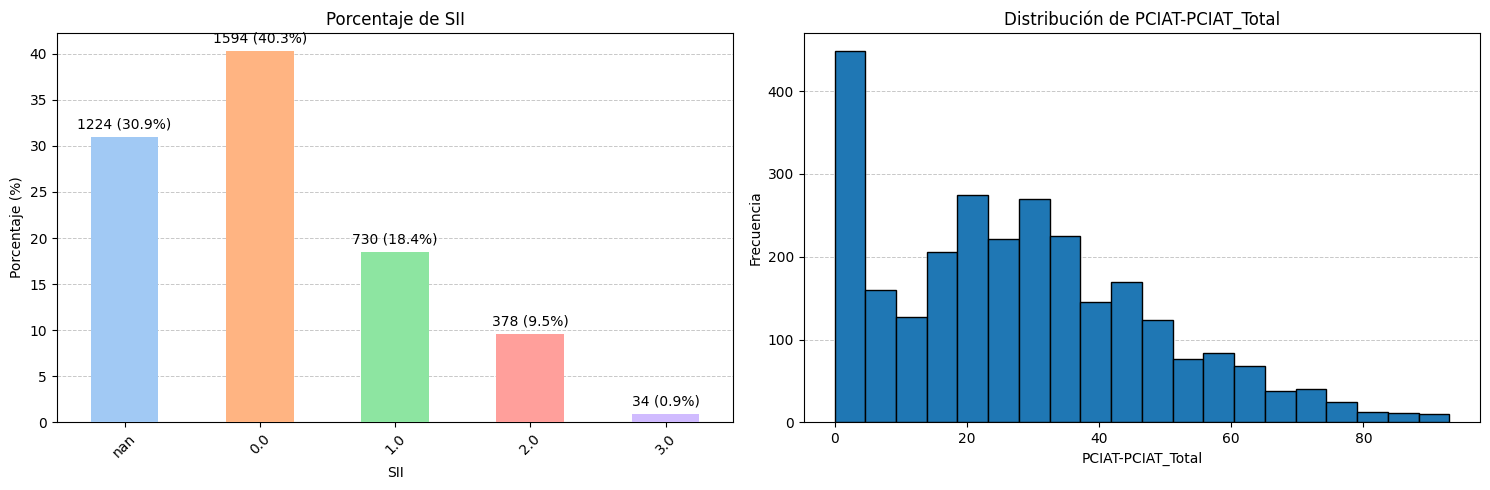

In [8]:
sii_counts = df_train["sii"].value_counts(dropna=False)
sii_percentages = (sii_counts / sii_counts.sum()) * 100

sii_counts = sii_counts.sort_index(na_position="first")
sii_percentages = sii_percentages.loc[sii_counts.index]

pciat_total_values = df_train["PCIAT-PCIAT_Total"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

colors = sns.color_palette("pastel", len(sii_percentages))
sii_percentages.plot(kind="bar", ax=axes[0], zorder=3, color=colors)

axes[0].set_title("Porcentaje de SII")
axes[0].set_xlabel("SII")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7, zorder=0)
axes[0].tick_params(axis="x", rotation=45)

for index, value in enumerate(sii_percentages):
    axes[0].text(index, value + 1, f"{sii_counts.iloc[index]} ({value:.1f}%)", ha="center")

pciat_total_values.plot(kind="hist", bins=20, ax=axes[1], edgecolor="black", zorder=3)

axes[1].set_title("Distribución de PCIAT-PCIAT_Total")
axes[1].set_xlabel("PCIAT-PCIAT_Total")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()


* Valores faltantes: La alta cantidad de NaN en SII sugiere que esta variable podría estar incompleta para una parte significativa de los participantes. Es necesario decidir cómo tratar estos valores (imputarlos, eliminarlos o analizarlos por separado).
* Distribución de impacto: La mayoría de los participantes tienen puntajes PCIAT bajos y pertenecen a SII = 0, lo que sugiere que el impacto de los cuestionarios está concentrado en las categorías menos severas.

#### Distribución del sii y PCIAT Total según el rango de edad

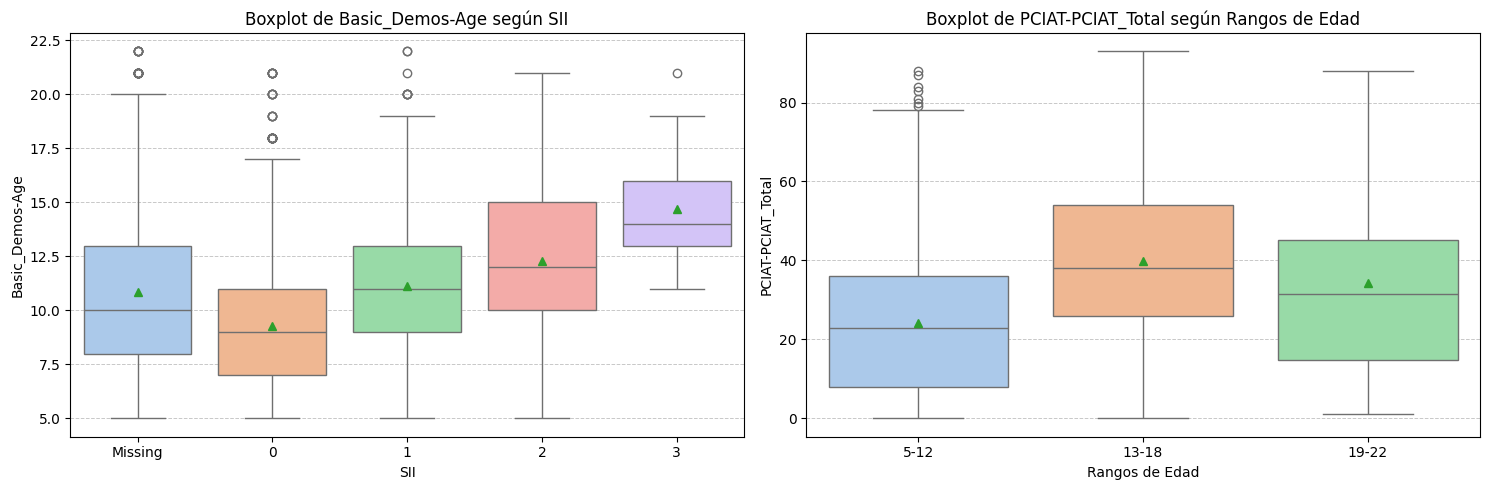

In [9]:
df_train["sii_categ"] = df_train["sii"].fillna("Missing")
labels = ["5-12", "13-18", "19-22"]

df_train["sii_categ"] = pd.Categorical(
    df_train["sii_categ"], categories=["Missing", 0, 1, 2, 3], ordered=True
)

df_train["Edad_Rango"] = pd.cut(df_train["Basic_Demos-Age"], bins=[4, 12, 18, 22], labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(
    x="sii_categ",
    y="Basic_Demos-Age",
    data=df_train,
    hue="sii_categ",
    ax=axes[0],
    showmeans=True,
    palette="pastel",
    dodge=False,
    legend=False,
)
axes[0].set_title("Boxplot de Basic_Demos-Age según SII")
axes[0].set_xlabel("SII")
axes[0].set_ylabel("Basic_Demos-Age")
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.boxplot(
    x="Edad_Rango",
    y="PCIAT-PCIAT_Total",
    data=df_train,
    hue="Edad_Rango",
    ax=axes[1],
    showmeans=True,
    palette="pastel",
    dodge=False,
    legend=False,
)
axes[1].set_title("Boxplot de PCIAT-PCIAT_Total según Rangos de Edad")
axes[1].set_xlabel("Rangos de Edad")
axes[1].set_ylabel("PCIAT-PCIAT_Total")
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


* Edad vs. SII:
    * Cuanto más mayores son los participantes, mayor es el impacto de Internet en sus vidas (al menos hasta los 18 años). SII y edad van de la mano.
* Adolescentes en el punto de mira:
    * Son el grupo más afectado, con las puntuaciones más altas en PCIAT_Total y un SII mayor. A esta edad, la tecnología empieza a interferir más en su día a día.
* Valores faltantes:
    * Hay un montón de datos sin completar (Missing en SII). Sería bueno analizarlos mejor para ver si son importantes o si los podemos ignorar.

#### Distribución del PCIAT Total según el sexo

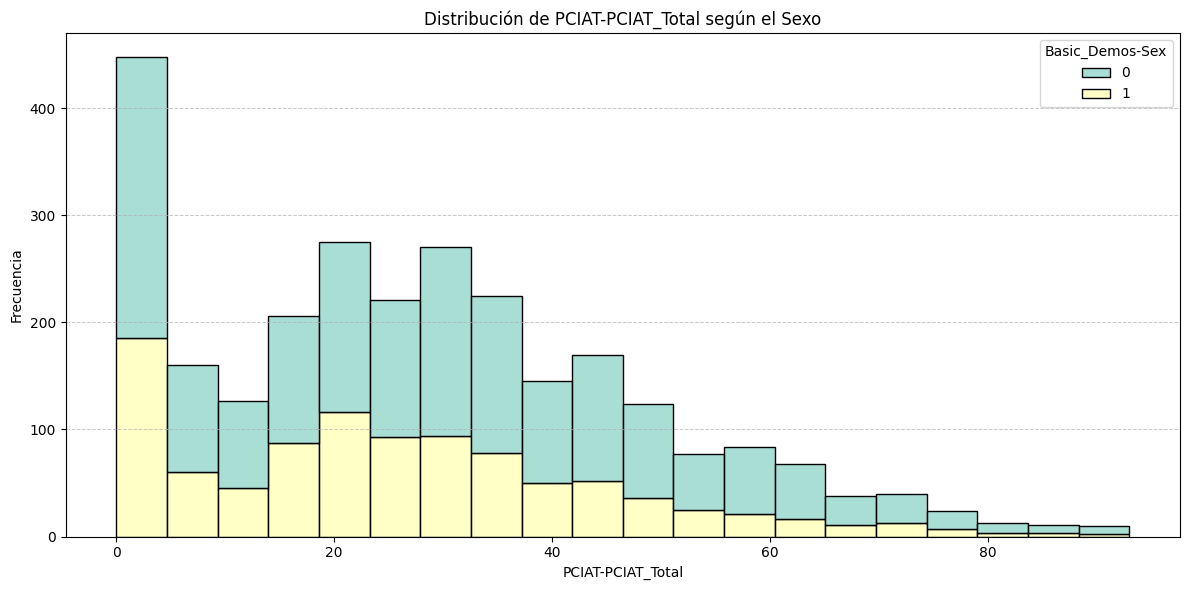

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=df_train,
    x="PCIAT-PCIAT_Total",
    hue="Basic_Demos-Sex",
    multiple="stack",
    palette="Set3",
    bins=20,
    ax=ax,
)

ax.set_title("Distribución de PCIAT-PCIAT_Total según el Sexo")
ax.set_xlabel("PCIAT-PCIAT_Total")
ax.set_ylabel("Frecuencia")
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


* Diferencia de género: Los hombres parecen estar más representados en general, especialmente en los puntajes bajos. Esto podría deberse a que son más propensos a usar Internet de forma moderada o simplemente a que hay más hombres en la muestra.
* Casos extremos: En los puntajes más altos (valores >60), hay menos participantes en general, lo que coincide con lo esperado: solo un pequeño grupo tiene problemas severos de uso de Internet.
* La mayoría de las personas no tienen problemas severos con el uso de Internet.
* Habría que investigar si la representación desigual entre hombres y mujeres es por diseño del estudio o si refleja una diferencia real en el uso de Internet.

#### Resultados sii según edad en gráficos pastel

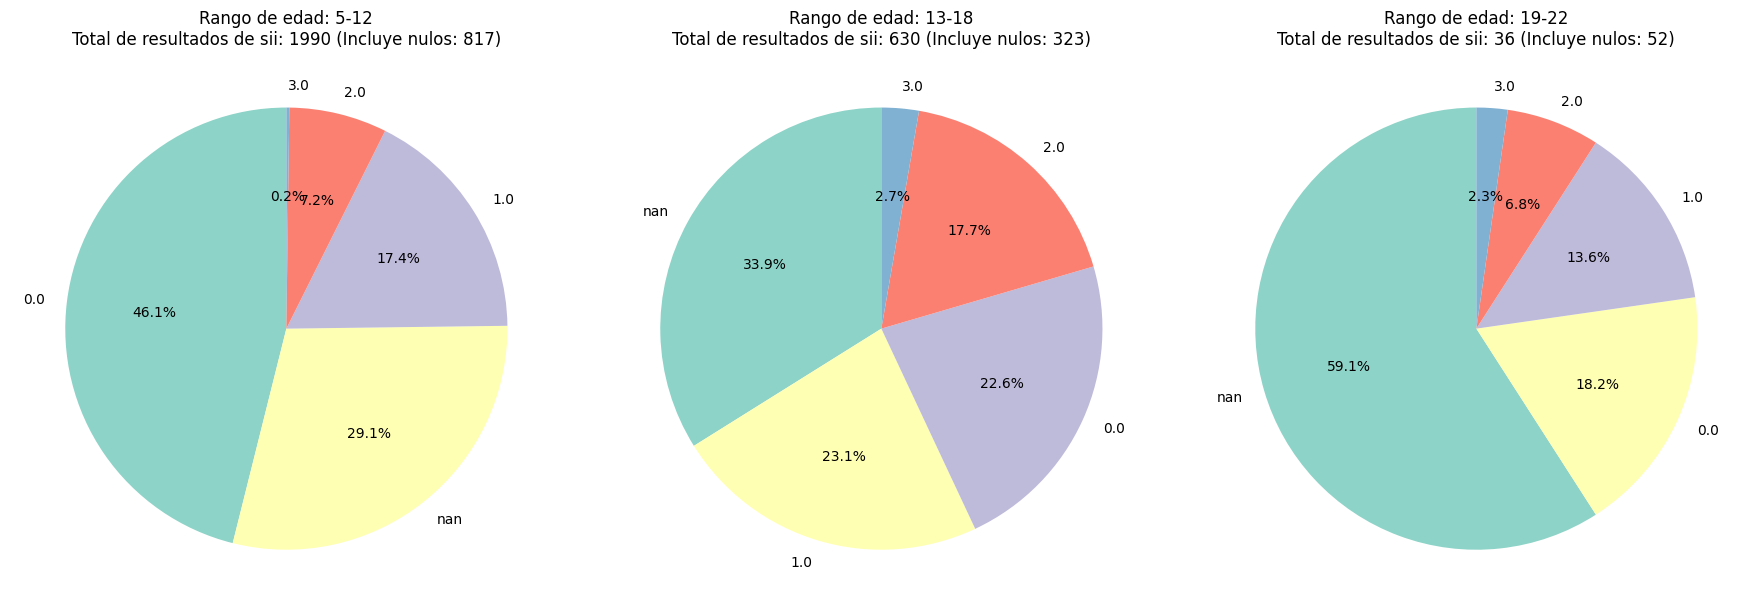

In [11]:
bins = [5, 12, 18, 22]
df_train["Edad_Rango"] = pd.cut(df_train["Basic_Demos-Age"], bins=bins, labels=labels, right=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, rango in enumerate(labels):
    grupo = df_train[df_train["Edad_Rango"] == rango]

    sii_counts = grupo["sii"].value_counts(normalize=True, dropna=False) * 100
    sii_labels = sii_counts.index
    sii_values = sii_counts.values

    titulo = f"Rango de edad: {rango}\nTotal de resultados de sii: {grupo['sii'].count()} (Incluye nulos: {grupo['sii'].isna().sum()})"

    axes[i].pie(
        sii_values,
        labels=sii_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set3"),
    )
    axes[i].set_title(titulo)

plt.tight_layout()
plt.show()


* Los niños (5-12): La mayoría no tiene problemas (SII = 0), y los casos graves son muy pocos.
* Los adolescentes (13-18): Aquí es donde las cosas se complican: más casos moderados y severos, lo que concuerda con que esta edad es la más crítica.
* Los adultos jóvenes (19-22): Vuelven a un uso más sano (SII = 0 domina), probablemente porque ya aprenden a regularse mejor.
* Los NaN: Los datos faltantes son más altos en los adolescentes, lo cual podría ser una señal de cuestionarios incompletos o problemas con la recolección de datos.

#### Estación del año en el que fue realizado los tipo test PCIAT

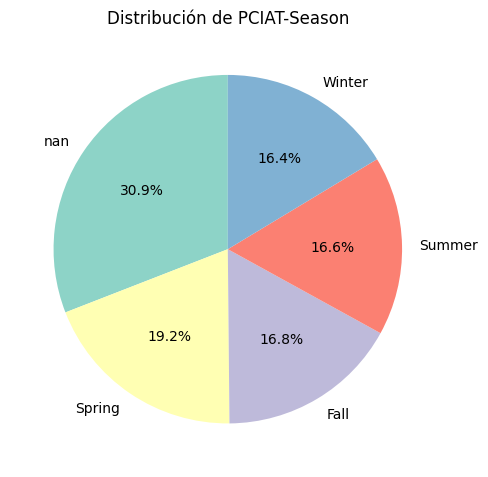

In [12]:
season_counts = df_train["PCIAT-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PCIAT-Season")

plt.tight_layout()
plt.show()


* Lo más importante aquí son los datos faltantes (nan). Si un tercio de la info no tiene estación registrada, podría ser útil analizar si esto afecta algo del modelo o de los análisis.
* Las estaciones no parecen tener una diferencia gigante entre ellas (cuando sí hay datos), así que probablemente no sea un factor crítico para el análisis.

### `Demographics`

In [13]:
# Vamos a ver el rango de edades:
unique_ages = sorted(df_train["Basic_Demos-Age"].dropna().unique().tolist())
unique_ages


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

#### Número de participantes según edad y sexo

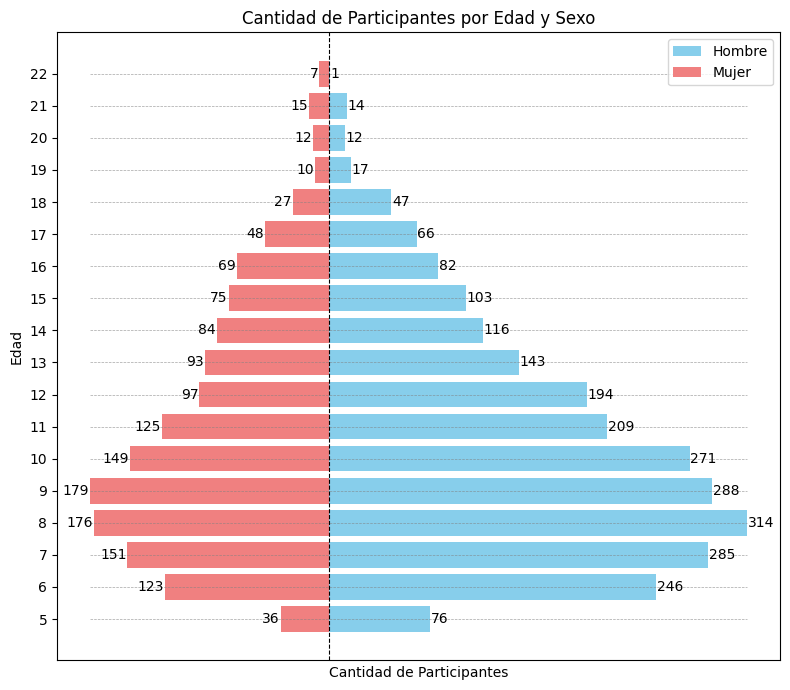

In [14]:
gender_age_counts = (
    df_train.groupby(["Basic_Demos-Age", "Basic_Demos-Sex"]).size().unstack(fill_value=0)
)

ages = sorted(df_train["Basic_Demos-Age"].dropna().unique())
male_counts = gender_age_counts.reindex(ages, fill_value=0).get(0, [0] * len(ages))
female_counts = gender_age_counts.reindex(ages, fill_value=0).get(1, [0] * len(ages))

fig, ax = plt.subplots(figsize=(8, 7))

male_bars = ax.barh(ages, male_counts, color="skyblue", label="Hombre")
female_bars = ax.barh(ages, -female_counts, color="lightcoral", label="Mujer")  # type: ignore


for bar in male_bars:
    width = bar.get_width()
    ax.text(
        width + 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="left"
    )
for bar in female_bars:
    width = abs(bar.get_width())
    ax.text(
        -width - 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="right"
    )


for age in ages:
    ax.hlines(
        y=age,
        xmin=-max(female_counts),
        xmax=max(male_counts),
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )


ax.set_title("Cantidad de Participantes por Edad y Sexo")
ax.set_xlabel("Cantidad de Participantes")
ax.set_ylabel("Edad")
ax.set_yticks(ages)
ax.axvline(0, color="black", linewidth=0.8, linestyle="--")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()


* Niños (5-10 años): Son el grueso del dataset, especialmente los hombres. Esto puede deberse a que es un rango donde es más fácil recopilar datos (padres involucrados).
* Adolescentes: Hay más equilibrio entre sexos, pero todavía predominan los hombres. Este grupo es clave para estudiar el impacto del uso de Internet.
* Adultos jóvenes: Son pocos en la muestra, lo que podría limitar los análisis para este rango de edad.

#### Número de participantes según el sexo

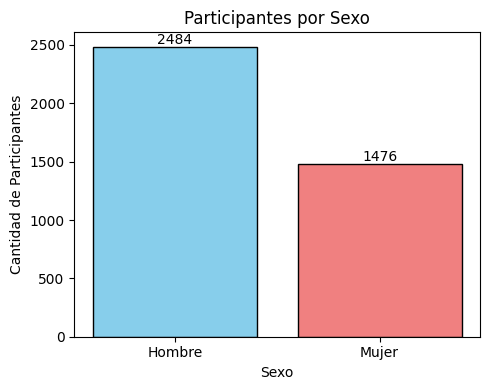

In [15]:
gender_counts = df_train["Basic_Demos-Sex"].value_counts()
gender_values = gender_counts.to_numpy()

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(
    ["Hombre", "Mujer"], gender_values, color=["skyblue", "lightcoral"], edgecolor="black"
)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 2, f"{int(height)}", ha="center", va="bottom"
    )

ax.set_title("Participantes por Sexo")
ax.set_xlabel("Sexo")
ax.set_ylabel("Cantidad de Participantes")

plt.tight_layout()
plt.show()


Como ya comentábamos en los análisis anteriores la participación de hombres en el estudio es significativamente mayor.

#### Estación del año de participación según el sexo

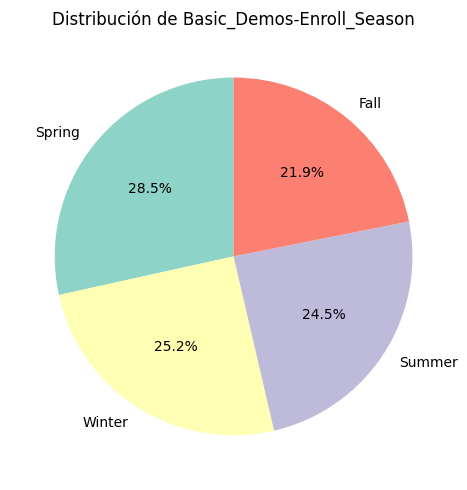

In [16]:
season_counts = (
    df_train["Basic_Demos-Enroll_Season"].value_counts(normalize=True, dropna=False) * 100
)

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Basic_Demos-Enroll_Season")

plt.tight_layout()
plt.show()


### `Children Global Assesment Scale(CGAS)`

In [17]:
stats = df_train["CGAS-CGAS_Score"].describe()

nulls = df_train["CGAS-CGAS_Score"].isna().sum()

stats_with_nulls = pd.concat([stats, pd.Series({"nulls": nulls})])


def conditional_round(x):
    if isinstance(x, (int, float)) and x == round(x):
        return f"{x:.1f}"
    return x


stats_with_nulls = stats_with_nulls.apply(conditional_round)

print(stats_with_nulls)


count       2421.0
mean     65.454771
std      22.341862
min           25.0
25%           59.0
50%           65.0
75%           75.0
max          999.0
nulls       1539.0
dtype: object


In [18]:
# Contar los valores por encima de 100, ya que eso es obviamente un fallo
outliers_count = df_train[df_train["CGAS-CGAS_Score"] > 100].shape[0]
print(f"Número de valores por encima de 100: {outliers_count}")


Número de valores por encima de 100: 1


`NOTA`: Enlace a a la página para comparar CGAS: https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/

#### Distribución de la puntuación de CGAS según categorías

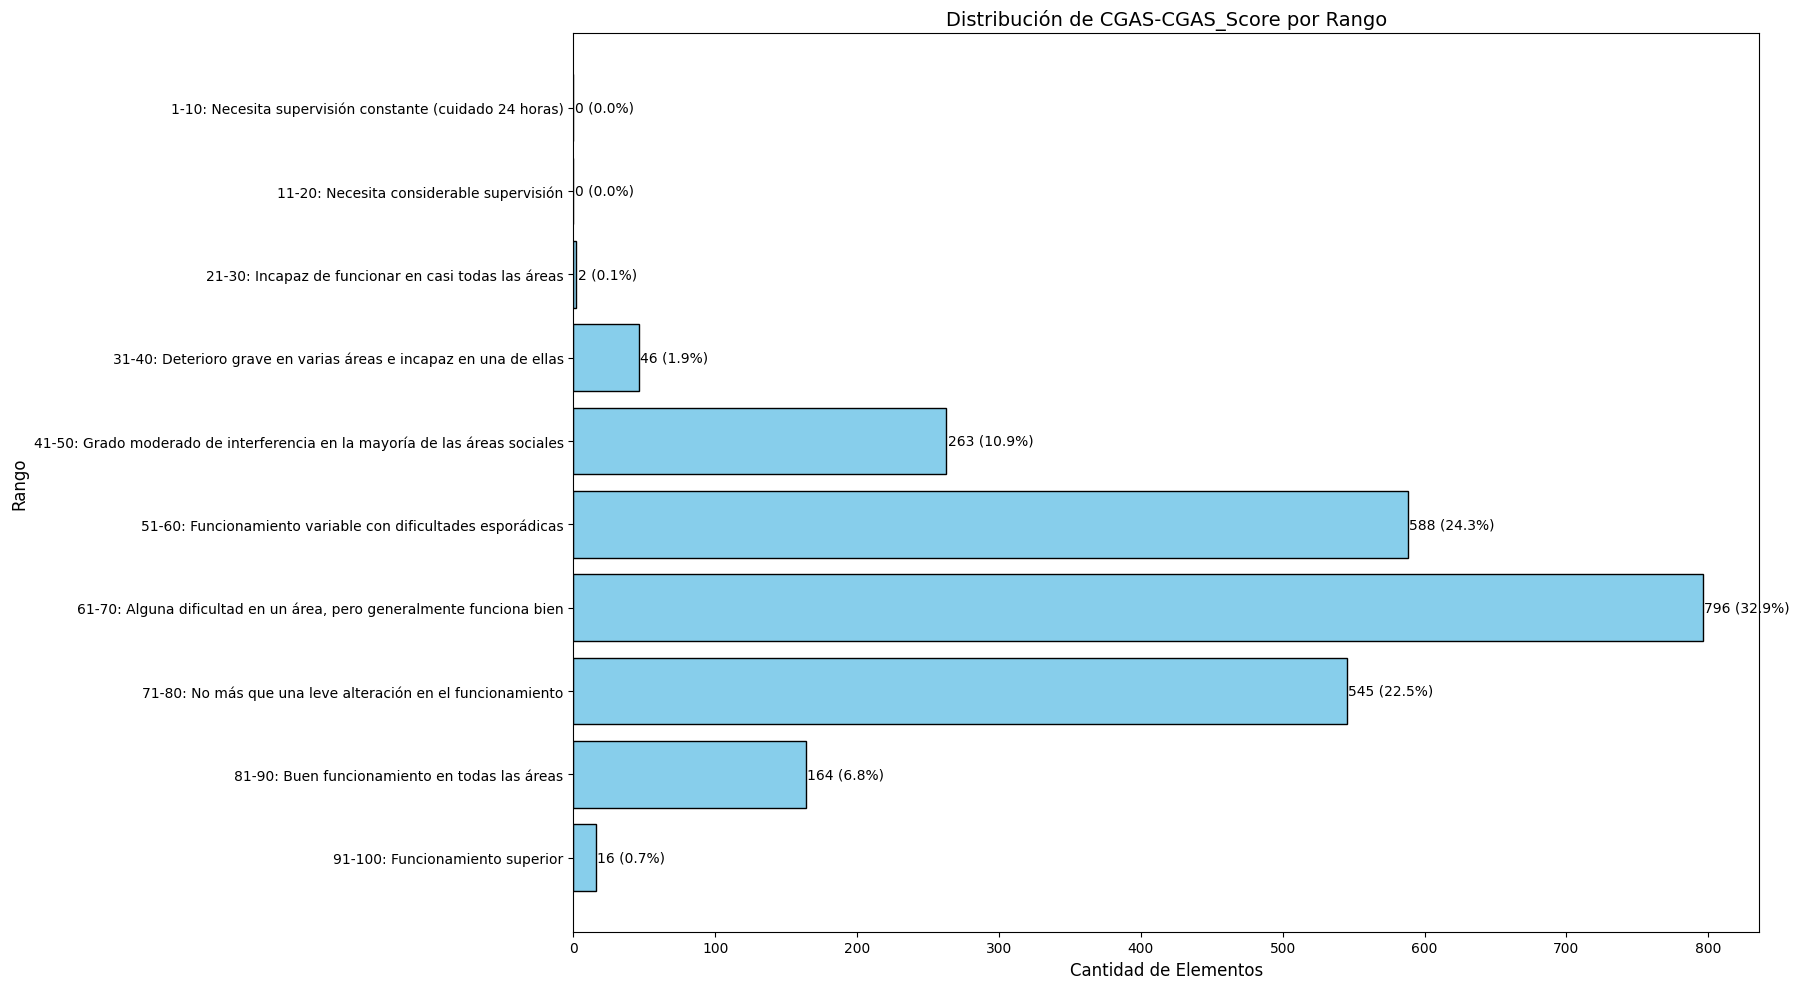

In [19]:
ranges = [
    (1, 10),
    (11, 20),
    (21, 30),
    (31, 40),
    (41, 50),
    (51, 60),
    (61, 70),
    (71, 80),
    (81, 90),
    (91, 100),
]

labels = [
    "1-10: Necesita supervisión constante (cuidado 24 horas)",
    "11-20: Necesita considerable supervisión",
    "21-30: Incapaz de funcionar en casi todas las áreas",
    "31-40: Deterioro grave en varias áreas e incapaz en una de ellas",
    "41-50: Grado moderado de interferencia en la mayoría de las áreas sociales",
    "51-60: Funcionamiento variable con dificultades esporádicas",
    "61-70: Alguna dificultad en un área, pero generalmente funciona bien",
    "71-80: No más que una leve alteración en el funcionamiento",
    "81-90: Buen funcionamiento en todas las áreas",
    "91-100: Funcionamiento superior",
]

counts = []
for low, high in ranges:
    count = df_train["CGAS-CGAS_Score"].between(low, high, inclusive="both").sum()
    counts.append(count)

total = sum(counts)
percentages = [(count / total) * 100 for count in counts]
data = pd.DataFrame({"Rango": labels, "Cantidad": counts, "Porcentaje": percentages})

data["Orden"] = range(len(data))
data = data.sort_values("Orden", ascending=False)

fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.barh(data["Rango"], data["Cantidad"], color="skyblue", edgecolor="black")

for index, bar in enumerate(bars):
    width = bar.get_width()
    percentage = data["Porcentaje"].iloc[index]
    ax.text(
        width + 1,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)} ({percentage:.1f}%)",
        va="center",
        ha="left",
    )

ax.set_title("Distribución de CGAS-CGAS_Score por Rango", fontsize=14)
ax.set_xlabel("Cantidad de Elementos", fontsize=12)
ax.set_ylabel("Rango", fontsize=12)

plt.tight_layout()
plt.show()


* La mayoría está en el rango 61-70, lo que indica que la población estudiada funciona bien en general, con problemas menores.
* Pocos casos extremos: Muy pocas personas están en los niveles más críticos (1-30) o en los más altos (91-100).
* Atención a los rangos moderados (31-50): Aunque menos representativos, aquí es donde se encuentran las dificultades más relevantes.

#### Puntuación CGAS según el sii

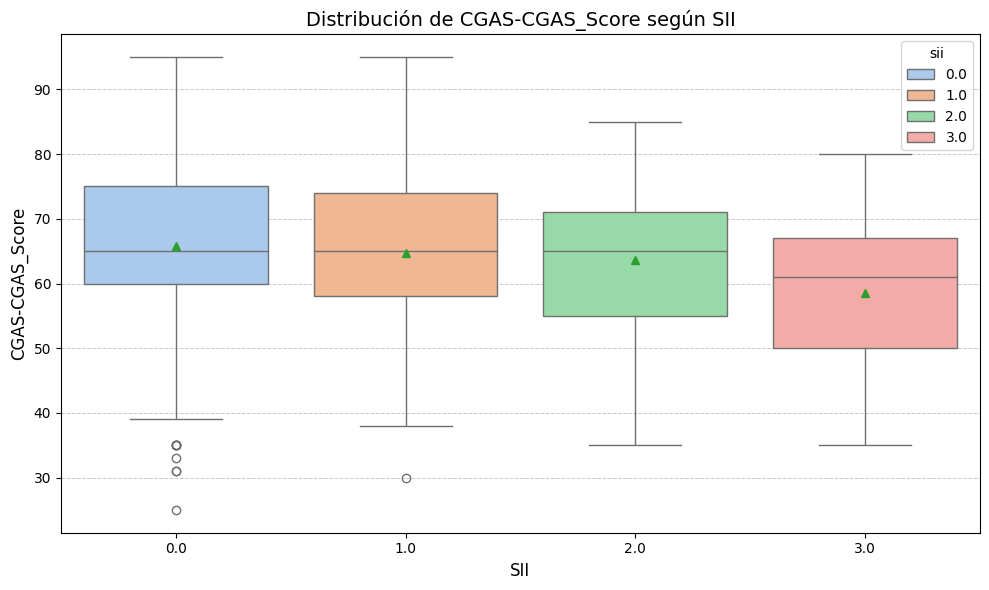

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="sii",
    y="CGAS-CGAS_Score",
    data=df_train,
    ax=ax,
    showmeans=True,
    palette="pastel",
    hue="sii",
)

ax.set_title("Distribución de CGAS-CGAS_Score según SII", fontsize=14)
ax.set_xlabel("SII", fontsize=12)
ax.set_ylabel("CGAS-CGAS_Score", fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Este gráfico refuerza la conexión entre el SII y el CGAS-CGAS_Score, mostrando cómo el uso problemático de Internet (medido por el PCIAT_Total y resumido en el SII) está directamente relacionado con el funcionamiento general. A medida que el SII aumenta, el impacto es evidente en el rango de puntuaciones CGAS, especialmente en los casos severos.

#### Distribución de PCIAT según categoría de CGAS

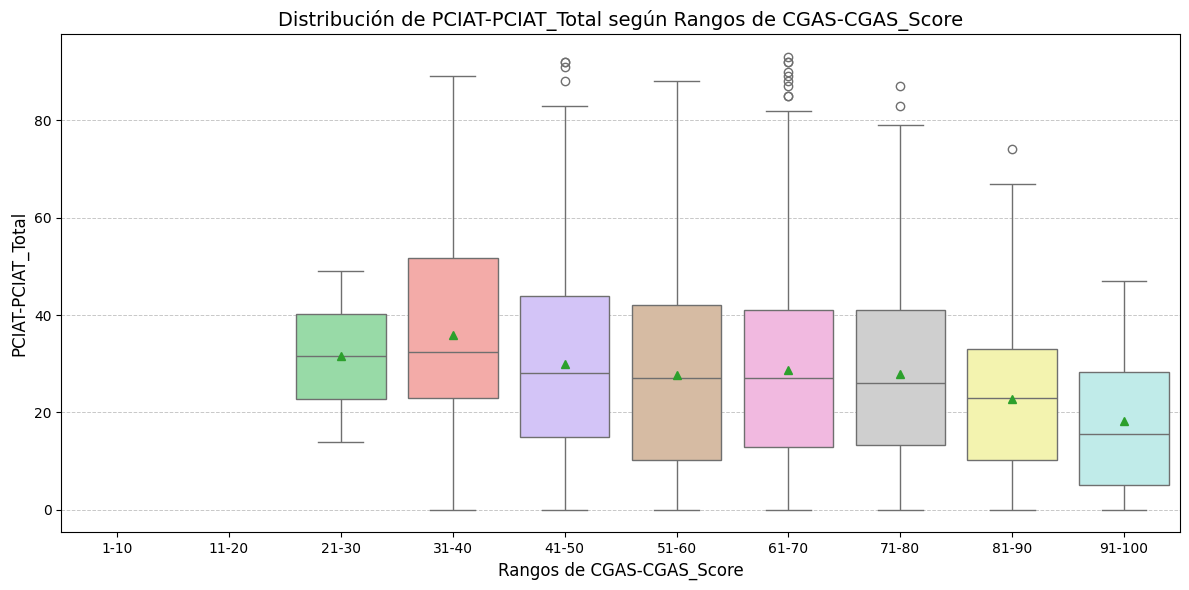

In [21]:
labels = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"]

df_train["CGAS_Range"] = pd.cut(
    df_train["CGAS-CGAS_Score"],
    bins=[low - 0.1 for low, _ in ranges] + [ranges[-1][1] + 0.1],
    labels=labels,
    right=True,
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="CGAS_Range",
    y="PCIAT-PCIAT_Total",
    data=df_train,
    ax=ax,
    showmeans=True,
    palette="pastel",
    hue="CGAS_Range",
    dodge=False,
)

ax.get_legend().remove()
ax.set_title("Distribución de PCIAT-PCIAT_Total según Rangos de CGAS-CGAS_Score", fontsize=14)
ax.set_xlabel("Rangos de CGAS-CGAS_Score", fontsize=12)
ax.set_ylabel("PCIAT-PCIAT_Total", fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico confirma la relación entre un bajo CGAS-CGAS_Score y valores más altos de PCIAT-PCIAT_Total, lo que indica que aquellos con peor evaluación en salud mental tienden a puntuar más alto en la escala de adicción a Internet. También muestra que, aunque en términos generales no hay una fuerte correlación, sí hay una tendencia en la que individuos con mejor salud mental tienen un menor PCIAT. Esto refuerza la idea mencionada en el PDF de que el uso problemático de Internet podría estar vinculado con una peor salud mental.

#### Estación del año correspondiente a la medida del CGAS

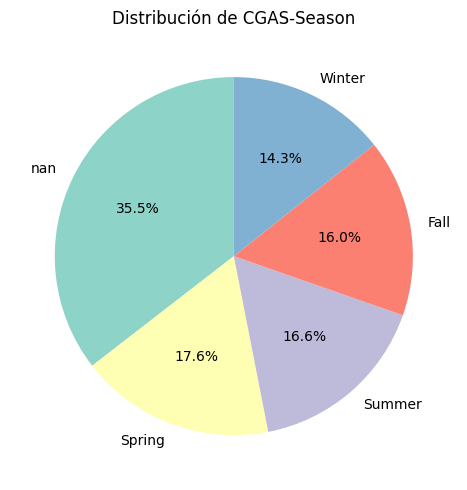

In [22]:
season_counts = df_train["CGAS-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de CGAS-Season")

plt.tight_layout()
plt.show()


### ` Physical Measures`

In [23]:
# Vemos rápidamente algunas caráterísticas de las columnas
columns_to_analyze = [
    "Physical-BMI",
    "Physical-Height",
    "Physical-Weight",
    "Physical-Waist_Circumference",
    "Physical-Diastolic_BP",
    "Physical-HeartRate",
    "Physical-Systolic_BP",
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                               count        mean        std   min        25%  \
Physical-BMI                  3022.0   19.331929   5.113934   0.0   15.86935   
Physical-Height               3027.0   55.946713   7.473764  33.0   50.00000   
Physical-Weight               3076.0   89.038615  44.569040   0.0   57.20000   
Physical-Waist_Circumference   898.0   27.278508   5.567287  18.0   23.00000   
Physical-Diastolic_BP         2954.0   69.648951  13.611226   0.0   61.00000   
Physical-HeartRate            2967.0   81.597236  13.665196  27.0   72.00000   
Physical-Systolic_BP          2954.0  116.983074  17.061225   0.0  107.00000   

                                     50%         75%         max   nulls  
Physical-BMI                   17.937682   21.571244   59.132048   938.0  
Physical-Height                55.000000   62.000000   78.500000   933.0  
Physical-Weight                77.000000  113.800000  315.000000   884.0  
Physical-Waist_Circumference   26.000000   30.000000   50.0

#### Histograma de las medidas físicas

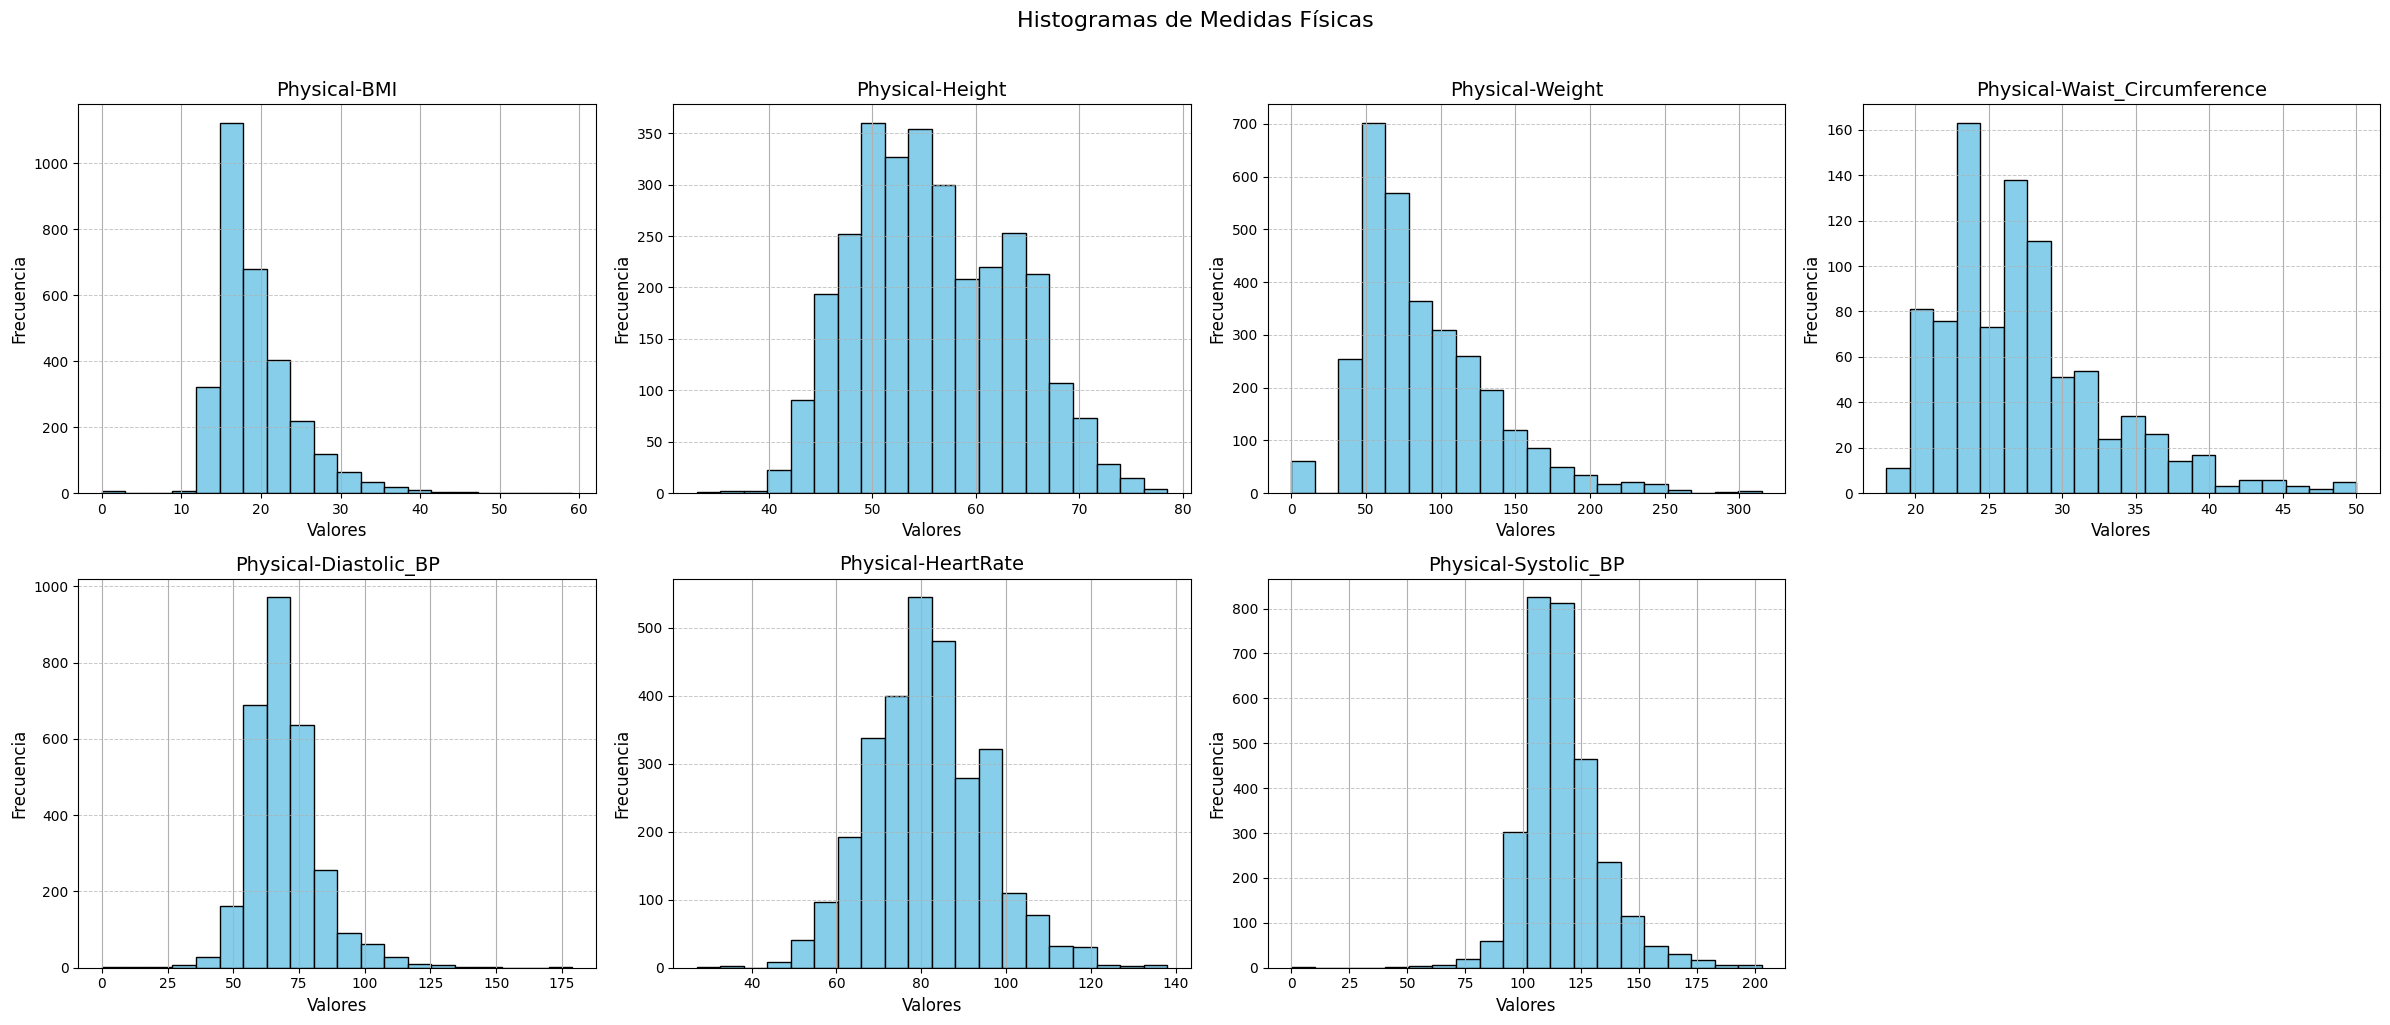

In [24]:
plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(columns_to_analyze) // n_cols + 1

for i, col in enumerate(columns_to_analyze):
    plt.subplot(n_rows, n_cols, i + 1)
    df_train[col].hist(bins=20, color="skyblue", edgecolor="black")
    plt.title(col, fontsize=14)
    plt.xlabel("Valores", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Histogramas de Medidas Físicas", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


Los datos físicos muestran tendencias esperadas, pero también revelan posibles errores y valores extremos en peso, presión sanguínea y circunferencia de cintura. Además, el análisis confirma las observaciones del PDF en cuanto a una posible relación entre IMC elevado y PIU, así como posibles errores en las mediciones de presión sanguínea. La información sugiere que individuos con alto PIU pueden presentar mayor riesgo de obesidad y problemas cardiovasculares, lo que refuerza la importancia de analizar estos factores con más detalle.

#### Recálculo de las medidas: Pulgadas a centímetros y libras a kilogramos

In [25]:
pulgadas_a_centimetros = 2.54
libras_a_kilos = 0.453592

df_train["Physical-Height"] *= pulgadas_a_centimetros
df_train["Physical-Waist_Circumference"] *= pulgadas_a_centimetros
df_train["Physical-Weight"] *= libras_a_kilos


# Importante recalcular el BMI
df_train["Physical-BMI"] = np.where(
    df_train["Physical-Weight"].notna() & df_train["Physical-Height"].notna(),
    df_train["Physical-Weight"] / ((df_train["Physical-Height"] / 100) ** 2),
    np.nan,
)


print(df_train[["Physical-Height", "Physical-Weight", "Physical-BMI"]].head())


   Physical-Height  Physical-Weight  Physical-BMI
0           116.84        23.042474     16.878972
1           121.92        20.865232     14.036968
2           143.51        34.291555     16.650330
3           142.24        37.013107     18.294143
4              NaN              NaN           NaN


#### Peso y altura según la edad

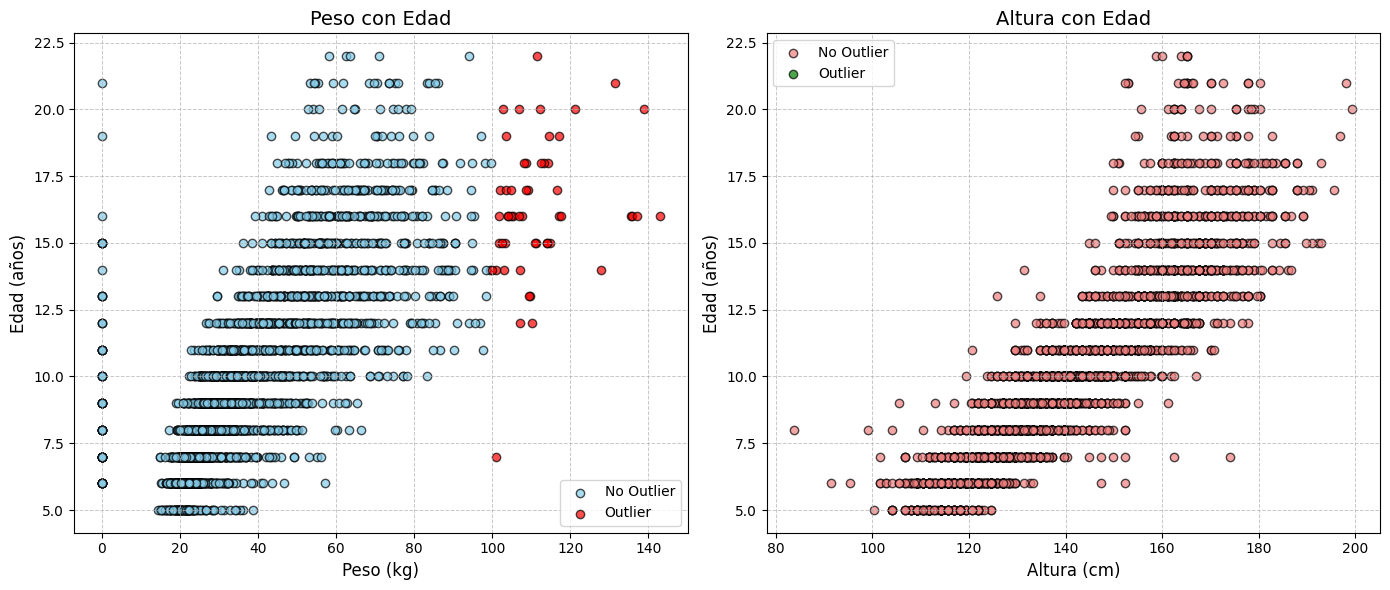

In [26]:
# Hay que revisar los outliers aquí
df_train["Weight_Outlier"] = df_train["Physical-Weight"] > 100
df_train["Height_Outlier"] = df_train["Physical-Height"] > 200

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    df_train.loc[~df_train["Weight_Outlier"], "Physical-Weight"],
    df_train.loc[~df_train["Weight_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="skyblue",
    label="No Outlier",
    edgecolor="black",
)
axes[0].scatter(
    df_train.loc[df_train["Weight_Outlier"], "Physical-Weight"],
    df_train.loc[df_train["Weight_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="red",
    label="Outlier",
    edgecolor="black",
)
axes[0].set_title("Peso con Edad", fontsize=14)
axes[0].set_xlabel("Peso (kg)", fontsize=12)
axes[0].set_ylabel("Edad (años)", fontsize=12)
axes[0].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0].legend()

axes[1].scatter(
    df_train.loc[~df_train["Height_Outlier"], "Physical-Height"],
    df_train.loc[~df_train["Height_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="lightcoral",
    label="No Outlier",
    edgecolor="black",
)
axes[1].scatter(
    df_train.loc[df_train["Height_Outlier"], "Physical-Height"],
    df_train.loc[df_train["Height_Outlier"], "Basic_Demos-Age"],
    alpha=0.7,
    color="green",
    label="Outlier",
    edgecolor="black",
)
axes[1].set_title("Altura con Edad", fontsize=14)
axes[1].set_xlabel("Altura (cm)", fontsize=12)
axes[1].set_ylabel("Edad (años)", fontsize=12)
axes[1].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


Los gráficos confirman que peso y altura aumentan con la edad, como era de esperar, pero también hay valores raros, sobre todo en el peso, con varios casos que superan los 100 kg en edades tempranas. Esto encaja con lo que decía el PDF sobre posibles errores o casos de obesidad. Además, la variabilidad en el peso es mayor en adolescentes, lo que podría estar ligado al PIU y un IMC más alto. La altura es más estable, aunque también tiene algunos valores que se salen de lo normal. Estos datos refuerzan la idea de revisar bien las anomalías y ver cómo afectan a la salud.

#### Peso con Medidas de la cintura

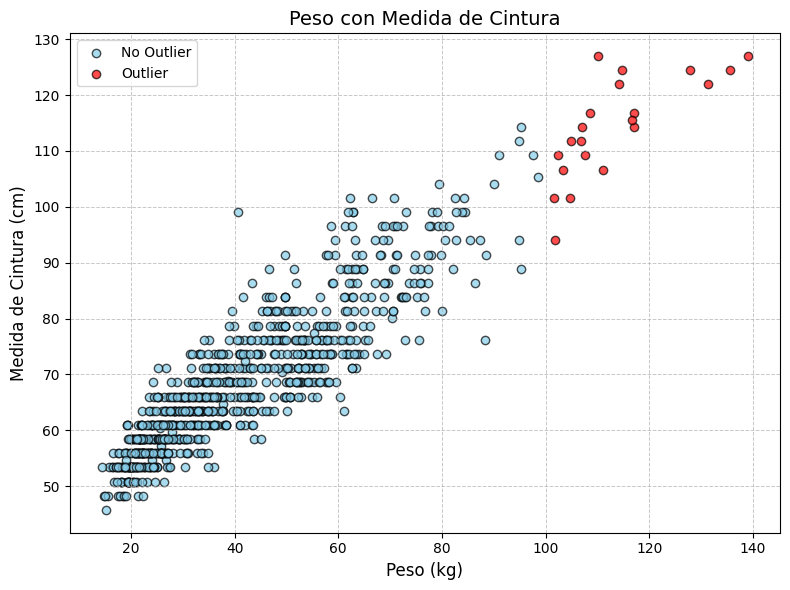

In [27]:
# Revisar los outliers
df_train["Outlier"] = (df_train["Physical-Weight"] > 100) | (
    df_train["Physical-Waist_Circumference"] > 150
)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_train.loc[~df_train["Outlier"], "Physical-Weight"],
    df_train.loc[~df_train["Outlier"], "Physical-Waist_Circumference"],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)

plt.scatter(
    df_train.loc[df_train["Outlier"], "Physical-Weight"],
    df_train.loc[df_train["Outlier"], "Physical-Waist_Circumference"],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)

plt.title("Peso con Medida de Cintura", fontsize=14)
plt.xlabel("Peso (kg)", fontsize=12)
plt.ylabel("Medida de Cintura (cm)", fontsize=12)
plt.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


El gráfico muestra una relación clara entre peso y medida de cintura, lo que es lógico: a mayor peso, mayor medida de cintura. Sin embargo, destacan varios outliers en la parte superior derecha, con pesos superiores a 100 kg y cinturas por encima de 110 cm, lo que coincide con lo mencionado en el PDF sobre valores extremos en peso y circunferencia de cintura. Esto refuerza la idea de que podría haber casos de obesidad o errores en los datos. Además, la relación con el PIU y el IMC alto podría ser relevante aquí, ya que el documento sugiere que un uso problemático de Internet puede estar ligado a un mayor peso corporal.

#### Latidos del corazón con presión sistólica y diastólica

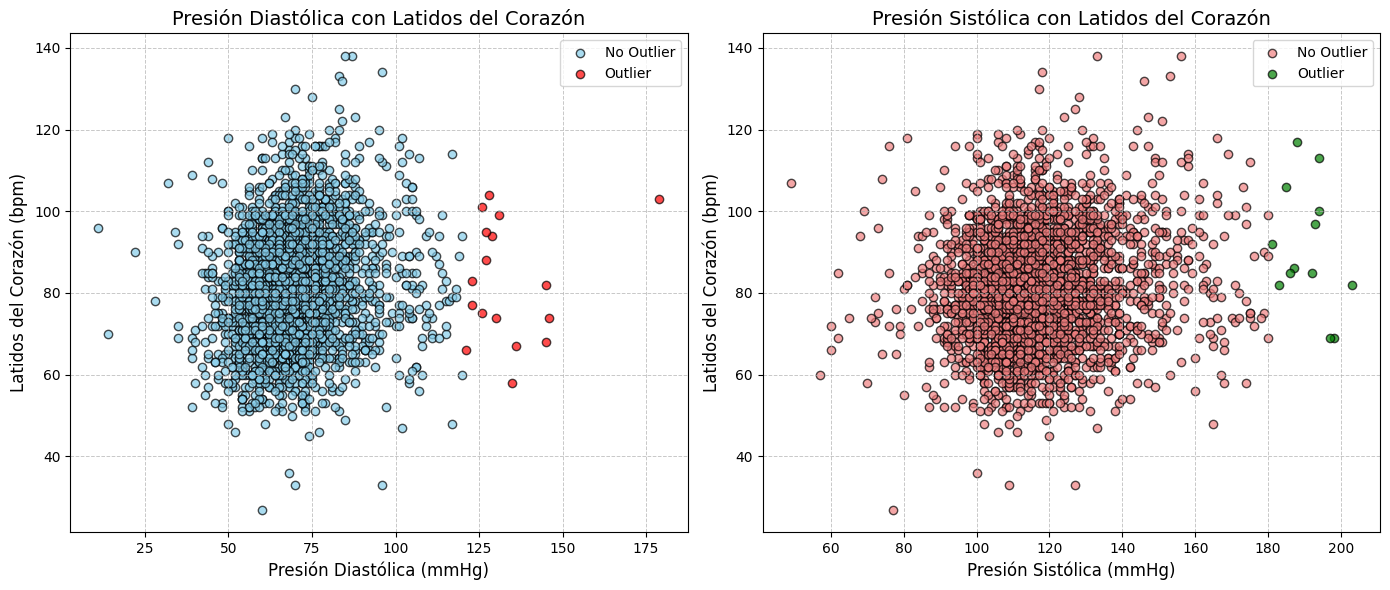

In [28]:
# Revisar outliers
df_train["Diastolic_Outlier"] = df_train["Physical-Diastolic_BP"] > 120
df_train["Systolic_Outlier"] = df_train["Physical-Systolic_BP"] > 180
df_train["HeartRate_Outlier"] = df_train["Physical-HeartRate"] > 150

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    df_train.loc[~df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"],
    df_train.loc[~df_train["Diastolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)
axes[0].scatter(
    df_train.loc[df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"],
    df_train.loc[df_train["Diastolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)
axes[0].set_title("Presión Diastólica con Latidos del Corazón", fontsize=14)
axes[0].set_xlabel("Presión Diastólica (mmHg)", fontsize=12)
axes[0].set_ylabel("Latidos del Corazón (bpm)", fontsize=12)
axes[0].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0].legend()

axes[1].scatter(
    df_train.loc[~df_train["Systolic_Outlier"], "Physical-Systolic_BP"],
    df_train.loc[~df_train["Systolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="lightcoral",
    edgecolor="black",
    label="No Outlier",
)
axes[1].scatter(
    df_train.loc[df_train["Systolic_Outlier"], "Physical-Systolic_BP"],
    df_train.loc[df_train["Systolic_Outlier"], "Physical-HeartRate"],
    alpha=0.7,
    color="green",
    edgecolor="black",
    label="Outlier",
)
axes[1].set_title("Presión Sistólica con Latidos del Corazón", fontsize=14)
axes[1].set_xlabel("Presión Sistólica (mmHg)", fontsize=12)
axes[1].set_ylabel("Latidos del Corazón (bpm)", fontsize=12)
axes[1].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


Los gráficos muestran la relación entre presión arterial (diastólica y sistólica) y la frecuencia cardíaca (bpm). Se observa que la mayoría de los valores siguen una distribución concentrada, pero hay outliers en ambos gráficos.

* En la presión diastólica, algunos valores superan los 125 mmHg, lo que coincide con lo mencionado en el PDF sobre errores en los datos de presión arterial.
* En la presión sistólica, hay algunos valores extremadamente altos (más de 180 mmHg), lo que es poco común y puede indicar errores de medición o casos extremos de hipertensión.
* En general, los latidos del corazón se concentran entre 60 y 100 bpm, lo cual es normal, pero hay algunos valores que se alejan bastante.

Estos datos refuerzan lo señalado en el PDF sobre la necesidad de revisar posibles errores en la presión sanguínea y cómo estas variaciones pueden estar relacionadas con otros factores como el PIU y la salud cardiovascular.

#### Presión diastólica y sistólica

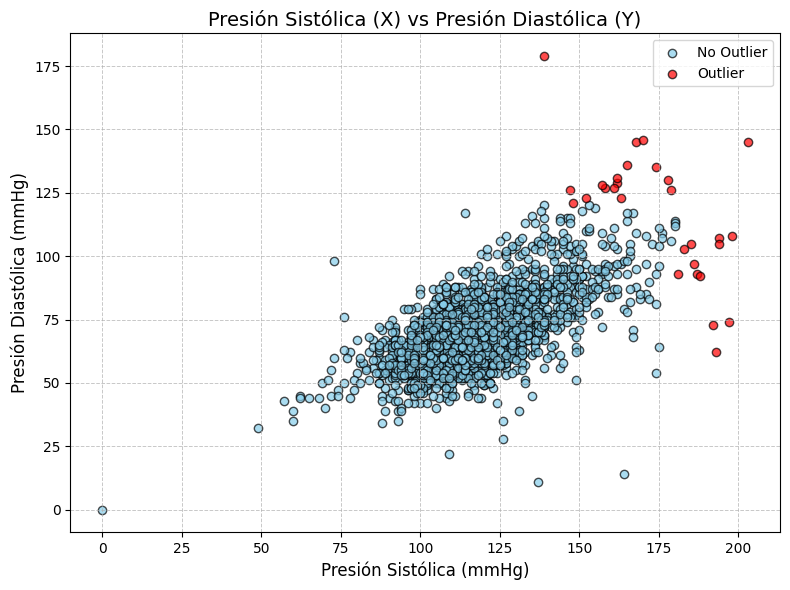

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    df_train.loc[
        ~df_train["Systolic_Outlier"] & ~df_train["Diastolic_Outlier"], "Physical-Systolic_BP"
    ],
    df_train.loc[
        ~df_train["Systolic_Outlier"] & ~df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"
    ],
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    label="No Outlier",
)

ax.scatter(
    df_train.loc[
        df_train["Systolic_Outlier"] | df_train["Diastolic_Outlier"], "Physical-Systolic_BP"
    ],
    df_train.loc[
        df_train["Systolic_Outlier"] | df_train["Diastolic_Outlier"], "Physical-Diastolic_BP"
    ],
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Outlier",
)

ax.set_title("Presión Sistólica (X) vs Presión Diastólica (Y)", fontsize=14)
ax.set_xlabel("Presión Sistólica (mmHg)", fontsize=12)
ax.set_ylabel("Presión Diastólica (mmHg)", fontsize=12)
ax.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


El gráfico muestra que la presión sistólica y diastólica están relacionadas, como era de esperar. Sin embargo, hay varios valores raros, sobre todo en la parte superior derecha, donde algunos registros tienen presiones súper altas (más de 175 mmHg sistólica y 125 mmHg diastólica). Esto encaja con lo que decía el PDF sobre posibles errores en los datos de presión arterial.

También hay algunos puntos sueltos en valores muy bajos, lo que podría ser un problema en la medición. Estos datos confirman que habría que revisar bien estas mediciones antes de sacar conclusiones sobre la relación entre presión arterial y otros factores.

#### Distribución del BMI

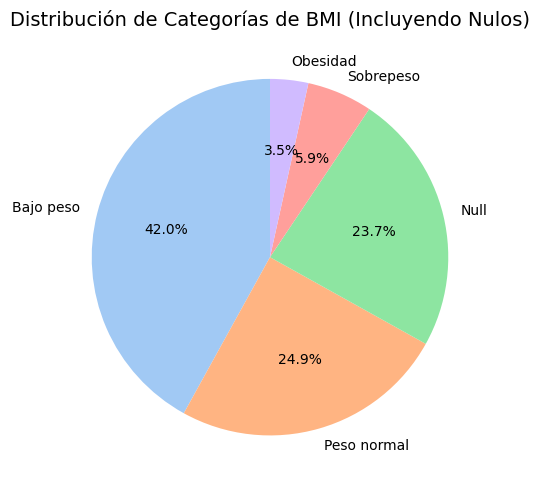

In [30]:
def classify_bmi(bmi):
    if np.isnan(bmi):
        return "Null"
    if bmi < 18.5:
        return "Bajo peso"
    if 18.5 <= bmi < 24.9:
        return "Peso normal"
    if 25 <= bmi < 29.9:
        return "Sobrepeso"
    return "Obesidad"


df_train["BMI_Category"] = df_train["Physical-BMI"].apply(classify_bmi)

bmi_category_counts = df_train["BMI_Category"].value_counts(normalize=True, dropna=False) * 100

fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(
    bmi_category_counts.values.tolist(),
    labels=bmi_category_counts.index.to_list(),
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel"),
)

ax.set_title("Distribución de Categorías de BMI (Incluyendo Nulos)", fontsize=14)

plt.tight_layout()
plt.show()


`NOTA:` Se ha utilizado los siguientes enlaces para sacar los intervalos:  
https://www.ine.es/jaxi/Tabla.htm?path=/t00/mujeres_hombres/tablas_1/l0/&file=d06001.px&L=0  
https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age

#### Matriz de correlación de las medidas físicas

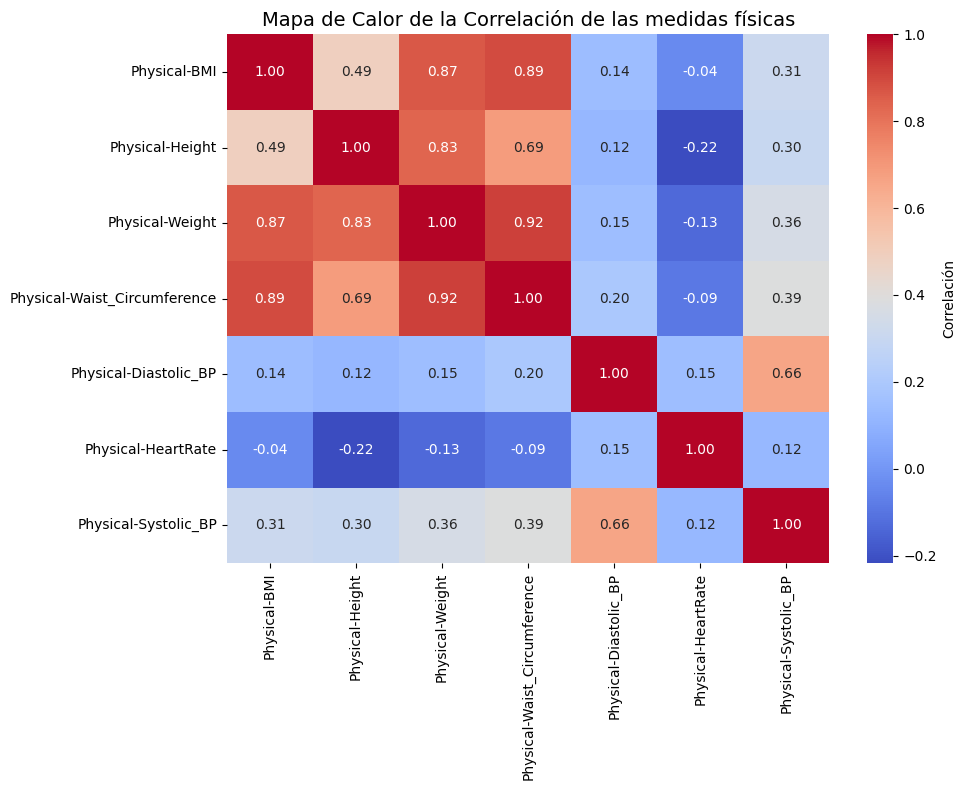

In [31]:
physical_columns = [
    col for col in df_train.columns if col.startswith("Physical") and col != "Physical-Season"
]
correlation_matrix = df_train[physical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Correlación"}
)

plt.title("Mapa de Calor de la Correlación de las medidas físicas", fontsize=14)

plt.tight_layout()
plt.show()


El mapa de calor muestra cómo se relacionan entre sí las diferentes medidas físicas, algunas cosas interesantes son las que siguen:

* El peso, el IMC y la circunferencia de la cintura están súper correlacionados (valores de 0.87 a 0.92), lo que tiene sentido porque una mayor masa corporal suele ir acompañada de una mayor circunferencia de cintura. Esto ya se mencionaba en el PDF.
* La presión diastólica y la presión sistólica están bastante relacionadas (0.66), lo cual es normal, pero sigue habiendo algunas inconsistencias en los datos como ya vimos en los gráficos anteriores.
* La altura tiene una correlación moderada con el peso y el IMC (0.49 y 0.83, respectivamente), lo que confirma que aunque la estatura influye, no es el único factor que determina el peso.
* La frecuencia cardíaca prácticamente no tiene relación con ninguna otra variable, lo que podría indicar que los latidos del corazón no dependen directamente de estas medidas físicas en este dataset.

En general, el gráfico confirma algunas de las relaciones esperadas y refuerza lo que se dijo en el PDF sobre la conexión entre peso, cintura e IMC. Pero también muestra que la presión arterial y la frecuencia cardíaca pueden necesitar un análisis más profundo, ya que no siguen un patrón tan claro.

#### Estación del año correspondiente a las medidas físicas

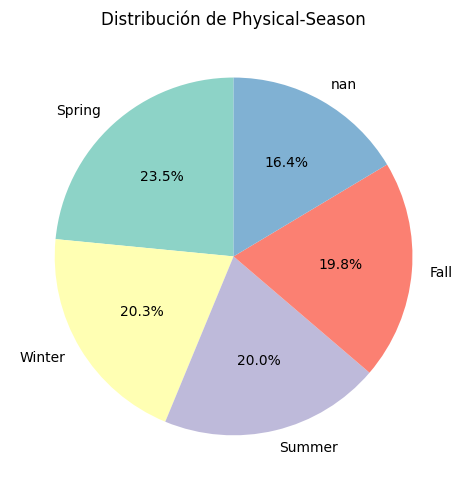

In [32]:
season_counts = df_train["Physical-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Physical-Season")

plt.tight_layout()
plt.show()


### `Bio-electric Impedance Analysis`

In [33]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("BIA") and col != "BIA-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                             count         mean          std          min  \
BIA-BIA_Activity_Level_num  1991.0     2.651431     1.028267     1.000000   
BIA-BIA_BMC                 1991.0     6.719826    92.586325    -7.789610   
BIA-BIA_BMI                 1991.0    19.367048     5.047848     0.048267   
BIA-BIA_BMR                 1991.0  1237.018187  1872.383246   813.397000   
BIA-BIA_DEE                 1991.0  2064.693747  2836.246272  1073.450000   
BIA-BIA_ECW                 1991.0    20.825346    73.266287     1.789450   
BIA-BIA_FFM                 1991.0    74.021708   199.433753    28.900400   
BIA-BIA_FFMI                1991.0    15.030554     5.792505     7.864850   
BIA-BIA_FMI                 1991.0     4.336495     6.356402  -194.163000   
BIA-BIA_Fat                 1991.0    16.855020   199.372119 -8745.080000   
BIA-BIA_Frame_num           1991.0     1.745354     0.680635     1.000000   
BIA-BIA_ICW                 1991.0    33.173380    56.272346    14.489000   

#### Histograma de los atributos BIA

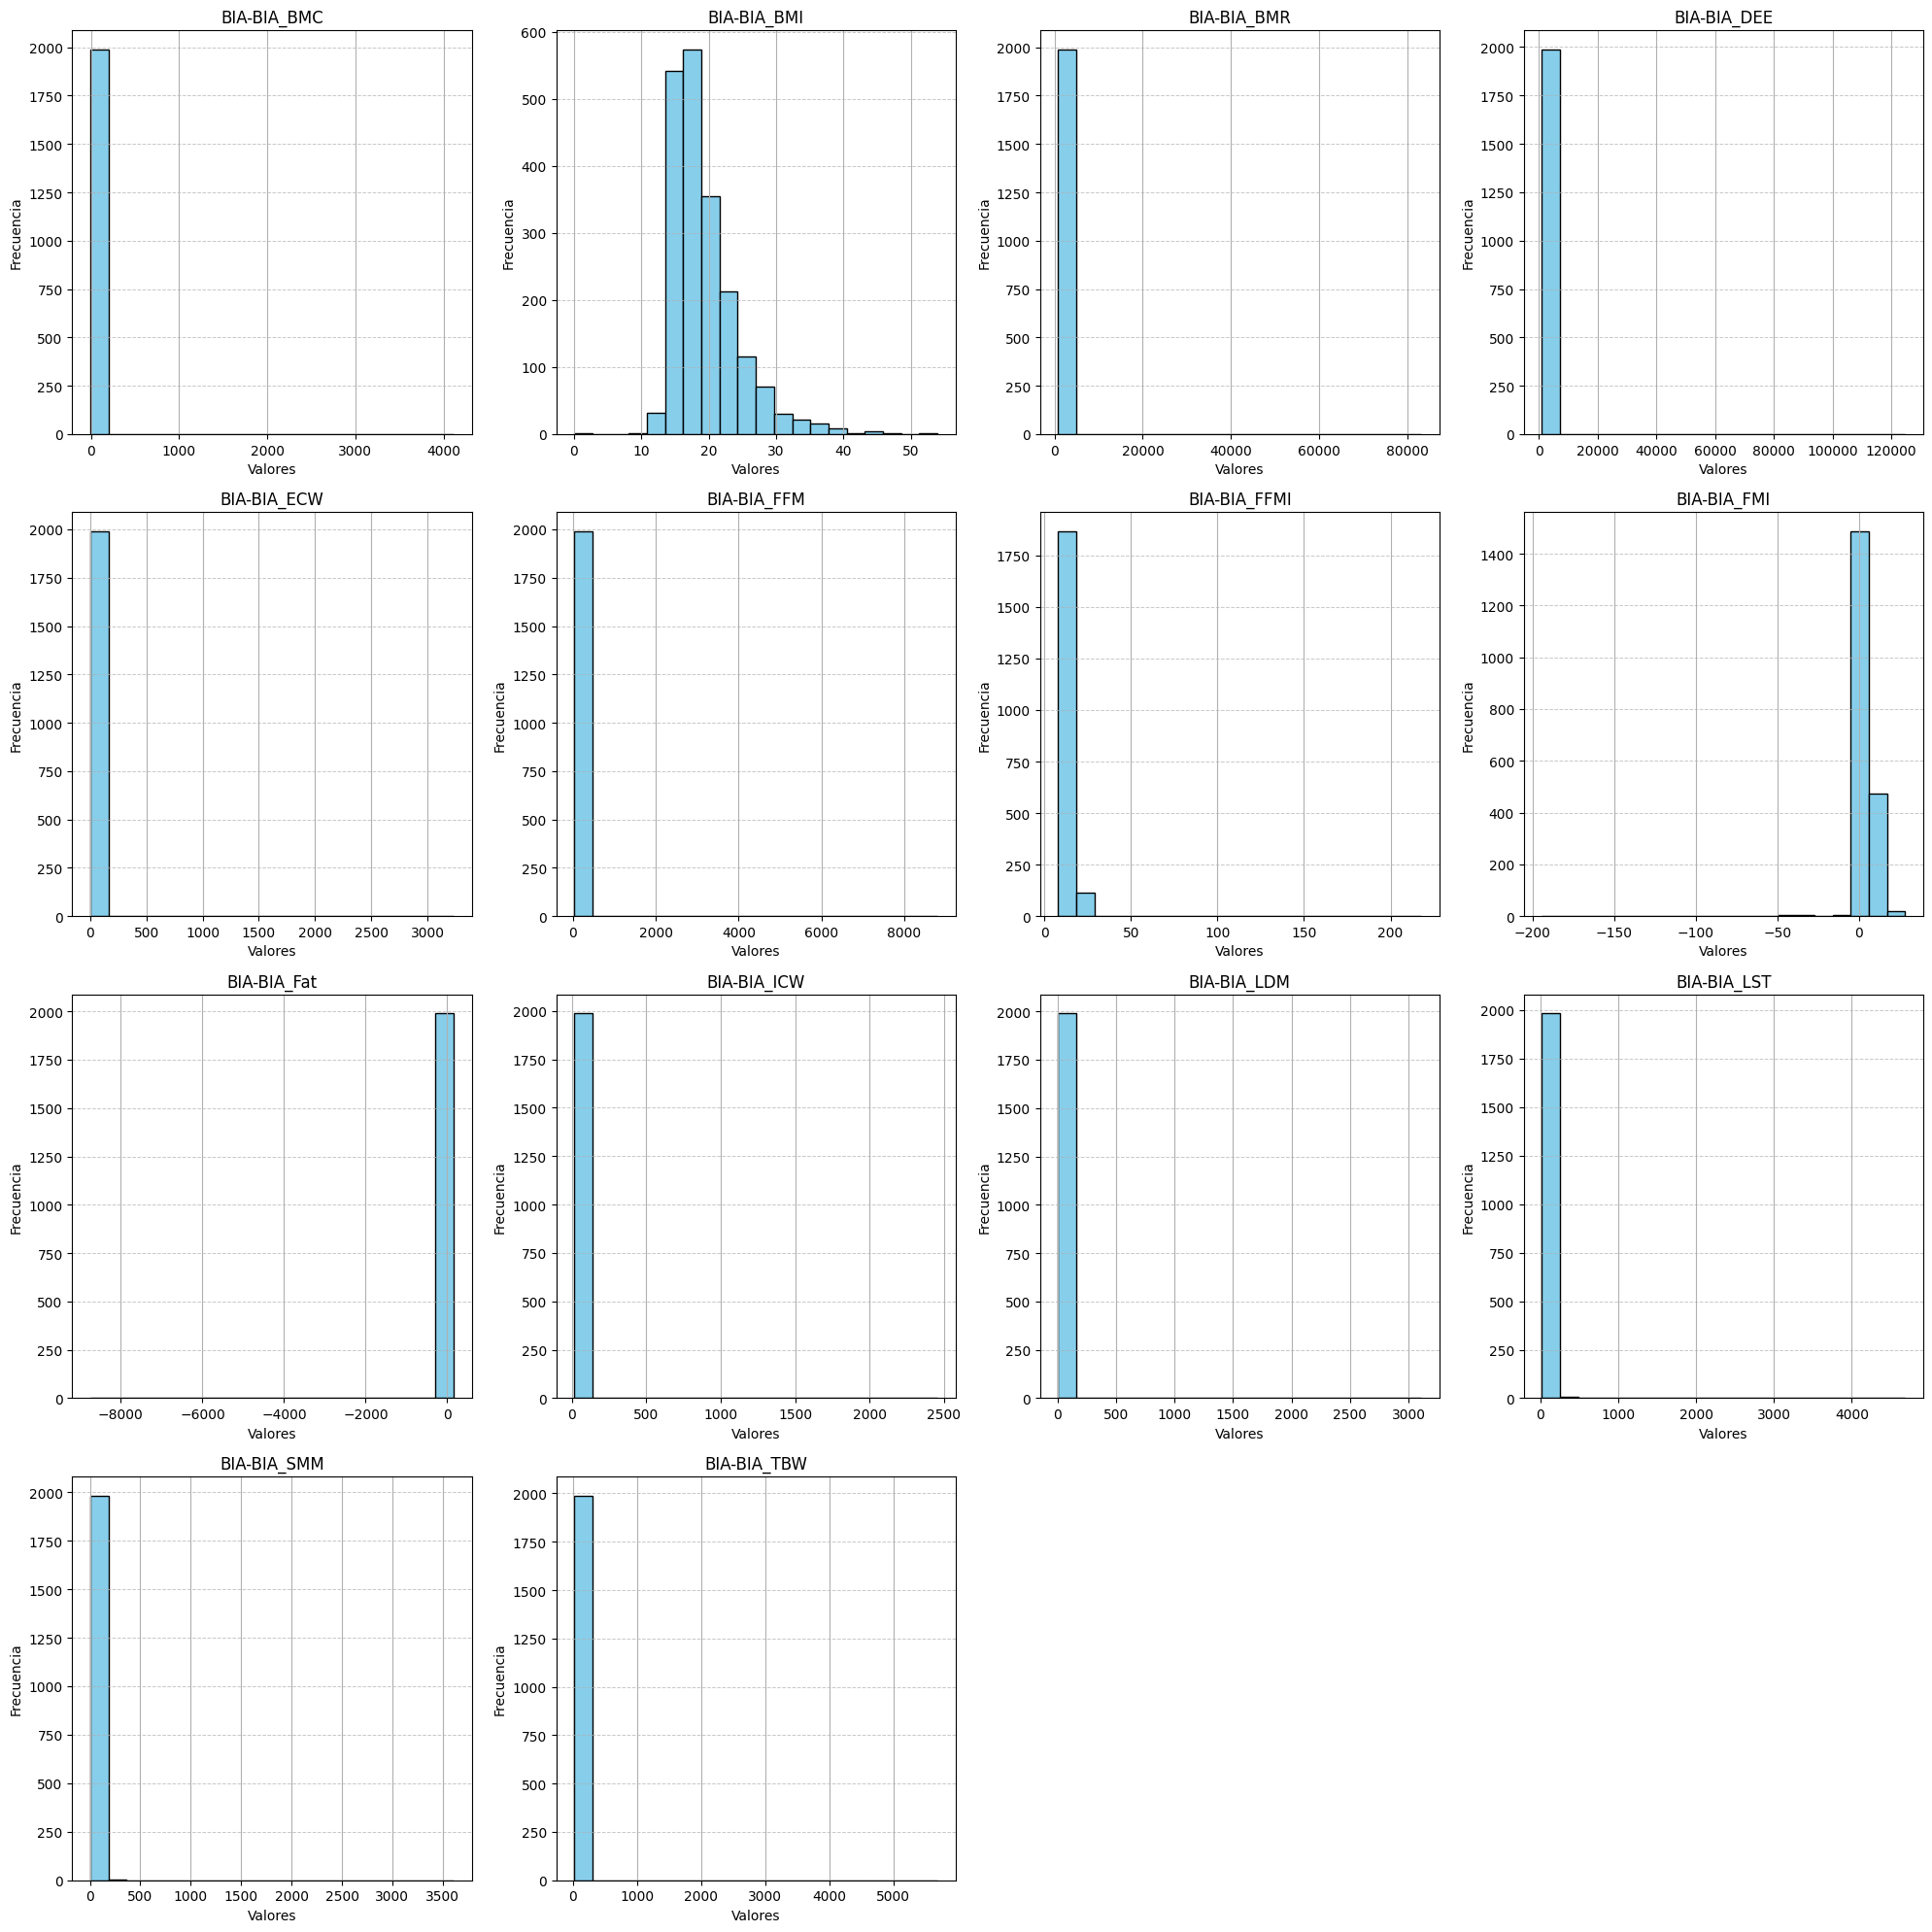

In [34]:
columns_to_analyze_filtered = [
    col
    for col in columns_to_analyze
    if col not in ["BIA-BIA_Activity_Level_num", "BIA-BIA_Frame_num"]
]

n_cols = 4
n_rows = len(columns_to_analyze_filtered) // n_cols + (
    len(columns_to_analyze_filtered) % n_cols > 0
)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(columns_to_analyze_filtered):
    ax = axes[i]
    df_train[col].hist(bins=20, ax=ax, color="skyblue", edgecolor="black")
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("Valores", fontsize=10)
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for j in range(len(columns_to_analyze_filtered), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Los histogramas muestran la distribución de varias mediciones de bioimpedancia (BIA), pero hay varios problemas visibles en los datos:

* Algunas variables tienen valores extremadamente altos o negativos, lo que ya se mencionaba en el PDF como un posible error en la medición o en el procesamiento de los datos.
* En muchos casos, los valores están comprimidos en un rango muy pequeño, lo que sugiere que hay poca variabilidad o que algunos datos pueden estar mal registrados.
* La distribución del IMC (BMI) parece normal, pero otras variables como Fat, FFM o ECW tienen picos muy raros o valores negativos, lo cual no tiene sentido.

Esto confirma lo que se decía en el PDF: las mediciones de BIA parecen ser inexactas y pueden estar sobreestimando o directamente conteniendo errores graves. Antes de usarlas en cualquier análisis, habría que hacer una limpieza y validación de los datos.

### Frecuencia en niveles de actividad y tipos de frame

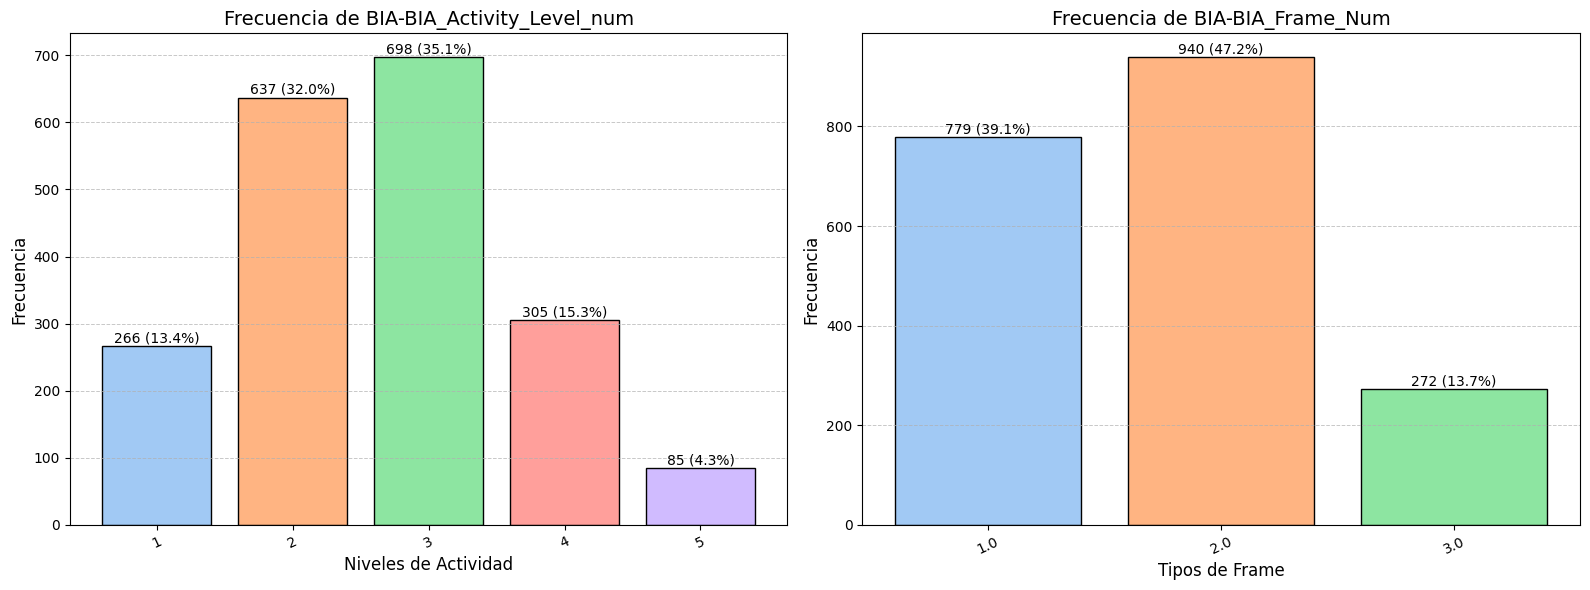

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_activity = sns.color_palette(
    "pastel", len(df_train["BIA-BIA_Activity_Level_num"].value_counts())
)
colors_frame = sns.color_palette("pastel", len(df_train["BIA-BIA_Frame_num"].value_counts()))

activity_counts = df_train["BIA-BIA_Activity_Level_num"].value_counts(normalize=False).sort_index()
activity_percentages = (
    df_train["BIA-BIA_Activity_Level_num"].value_counts(normalize=True).sort_index() * 100
)

bars = axes[0].bar(
    activity_counts.index, activity_counts.values, color=colors_activity, edgecolor="black"
)
axes[0].set_title("Frecuencia de BIA-BIA_Activity_Level_num", fontsize=14)
axes[0].set_xlabel("Niveles de Actividad", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for bar, count, percent in zip(bars, activity_counts.values, activity_percentages):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(count)} ({percent:.1f}%)",
        ha="center",
        va="bottom",
    )

axes[0].tick_params(axis="x", rotation=25)

frame_counts = df_train["BIA-BIA_Frame_num"].value_counts(normalize=False).sort_index()
frame_percentages = df_train["BIA-BIA_Frame_num"].value_counts(normalize=True).sort_index() * 100

bars = axes[1].bar(
    frame_counts.index.astype(str), frame_counts.values, color=colors_frame, edgecolor="black"
)
axes[1].set_title("Frecuencia de BIA-BIA_Frame_Num", fontsize=14)
axes[1].set_xlabel("Tipos de Frame", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for bar, count, percent in zip(bars, frame_counts.values, frame_percentages):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(count)} ({percent:.1f}%)",
        ha="center",
        va="bottom",
    )

axes[1].tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()


Los gráficos muestran la distribución de niveles de actividad y tipos de frame (estructura corporal) según el análisis de bioimpedancia (BIA).

* En niveles de actividad, la mayoría de las personas están en los niveles 2 y 3, lo que indica un nivel de actividad física moderado, mientras que los niveles más altos (4 y 5) son mucho menos frecuentes. Esto encaja con lo mencionado en el PDF sobre que la actividad física parece estable en niños y adolescentes, aunque algunos datos podrían estar sesgados por autoevaluación.
* En tipos de frame, la mayoría de las personas tienen una estructura mediana (tipo 2) o pequeña (tipo 1), mientras que los de frame grande (tipo 3) son los menos comunes.

Estos datos confirman que la mayoría de los participantes no tienen niveles de actividad física muy altos y que las estructuras corporales más comunes son las medianas y pequeñas.

#### Comparación entre BIA-BMI y Physical-BMI

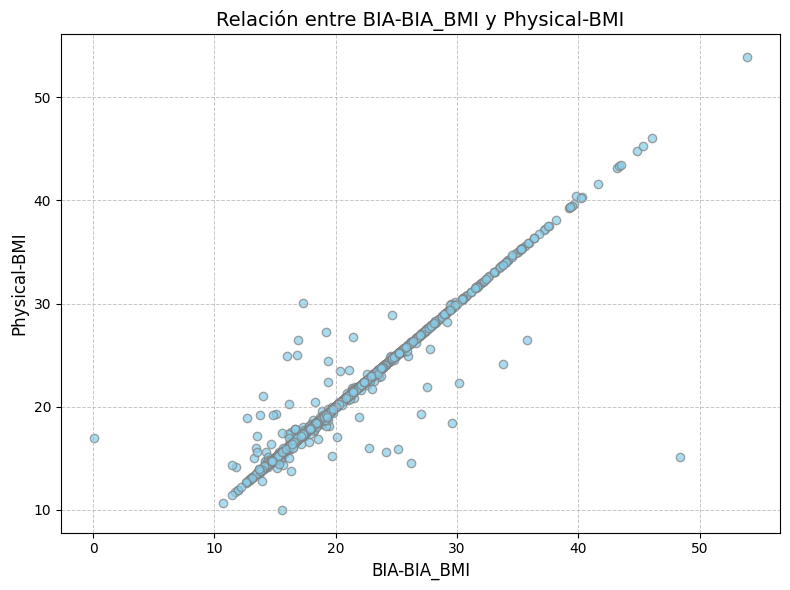

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df_train["BIA-BIA_BMI"], df_train["Physical-BMI"], alpha=0.7, color="skyblue", edgecolor="grey"
)
plt.title("Relación entre BIA-BIA_BMI y Physical-BMI", fontsize=14)
plt.xlabel("BIA-BIA_BMI", fontsize=12)
plt.ylabel("Physical-BMI", fontsize=12)
plt.grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico muestra una correlación casi perfecta entre el BIA-BMI y el Physical-BMI, lo que indica que ambos métodos de cálculo del IMC están muy alineados. Sin embargo, hay algunos puntos que se desvían de la línea principal, lo que sugiere que en ciertos casos los valores del BIA pueden sobrestimar o subestimar el BMI real.

En el PDF se mencionaba que las mediciones de BIA podrían ser inexactas, y aunque en la mayoría de los casos parecen coincidir bastante bien con los valores físicos reales, estos puntos fuera de la tendencia refuerzan la idea de que el BIA no es siempre 100% preciso y puede tener errores en ciertos individuos.

#### Estación del año correspondiente a las medidas de BIA

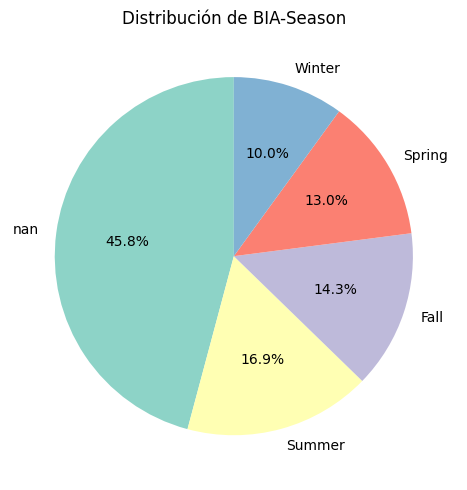

In [37]:
season_counts = df_train["BIA-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de BIA-Season")

plt.tight_layout()
plt.show()


### `FitnessGram Vitals and Treadmill`

In [38]:
columns_to_analyze = [
    col
    for col in df_train.columns
    if col.startswith("Fitness_Endurance") and col != "Fitness_Endurance-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                             count       mean        std  min    25%   50%  \
Fitness_Endurance-Max_Stage  743.0   4.989233   2.014072  0.0   4.00   5.0   
Fitness_Endurance-Time_Mins  740.0   7.370270   3.189662  0.0   6.00   7.0   
Fitness_Endurance-Time_Sec   740.0  27.581081  17.707751  0.0  12.75  28.0   

                              75%   max   nulls  
Fitness_Endurance-Max_Stage   6.0  28.0  3217.0  
Fitness_Endurance-Time_Mins   9.0  20.0  3220.0  
Fitness_Endurance-Time_Sec   43.0  59.0  3220.0  


#### Histogramas del tiempo en minutos y segundos separados

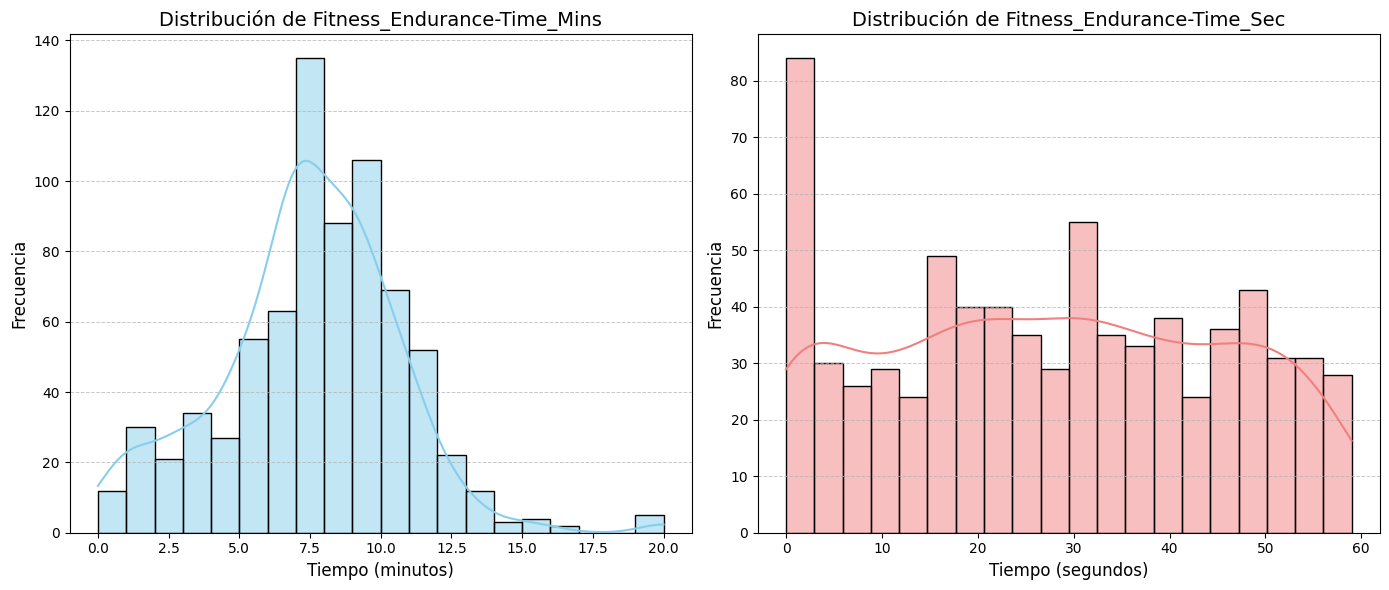

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=df_train,
    x="Fitness_Endurance-Time_Mins",
    kde=True,
    ax=axes[0],
    color="skyblue",
    bins=20,
    edgecolor="black",
)
axes[0].set_title("Distribución de Fitness_Endurance-Time_Mins", fontsize=14)
axes[0].set_xlabel("Tiempo (minutos)", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.histplot(
    data=df_train,
    x="Fitness_Endurance-Time_Sec",
    kde=True,
    ax=axes[1],
    color="lightcoral",
    bins=20,
    edgecolor="black",
)
axes[1].set_title("Distribución de Fitness_Endurance-Time_Sec", fontsize=14)
axes[1].set_xlabel("Tiempo (segundos)", fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Los histogramas muestran la distribución del tiempo en minutos y segundos en la prueba de resistencia cardiovascular (Fitness Endurance).

* En la distribución de minutos, la mayoría de los participantes completaron la prueba entre 5 y 10 minutos, con un pico alrededor de los 7-8 minutos. Esto sugiere que la resistencia promedio se encuentra en ese rango.
* En la distribución de segundos, hay una acumulación importante en 0 segundos, lo que puede indicar que algunos participantes no completaron la prueba o no lograron avanzar en ella. 
Esto ya se mencionaba en el PDF como una posibilidad, sugiriendo que algunas personas fallaron en la etapa inicial.

Estos datos confirman que la mayoría de los participantes tienen una resistencia media, pero también muestran que hay una parte que no logra completar ni un minuto de prueba, lo que puede estar relacionado con factores como el nivel de actividad física o la condición de salud.

#### Dsttibución de los Stage por temporadas

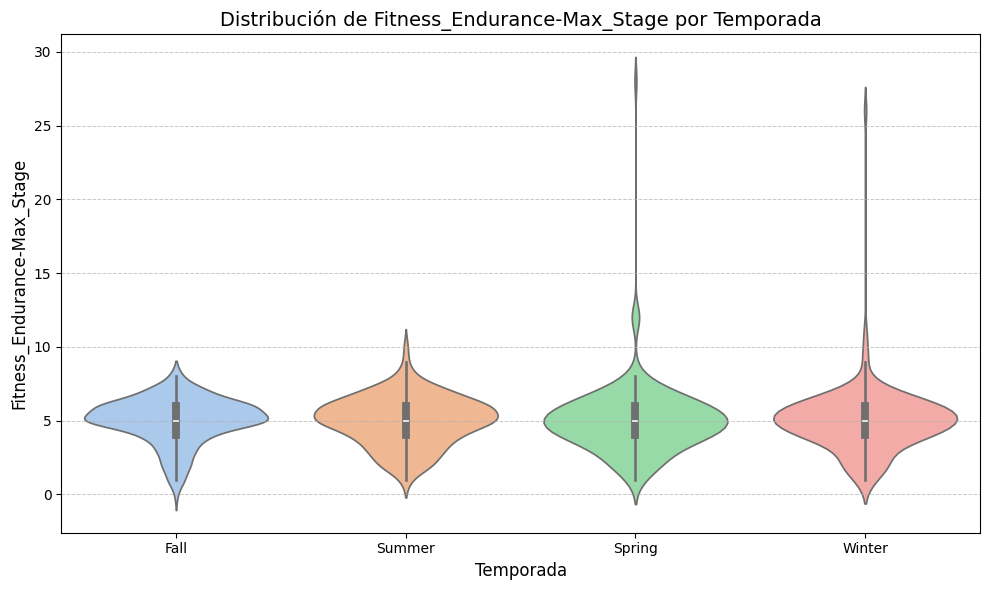

In [40]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_train,
    x="Fitness_Endurance-Season",
    hue="Fitness_Endurance-Season",
    legend=False,
    y="Fitness_Endurance-Max_Stage",
    palette="pastel",
)

plt.title("Distribución de Fitness_Endurance-Max_Stage por Temporada", fontsize=14)
plt.xlabel("Temporada", fontsize=12)
plt.ylabel("Fitness_Endurance-Max_Stage", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico de violín muestra la distribución de Fitness_Endurance-Max_Stage según la temporada en la que se realizó la prueba.

* En general, la mayoría de los participantes alcanzan un máximo de 4 a 6 etapas, sin importar la temporada.
* Se observan valores extremos en primavera y, en menor medida, en invierno, con algunos casos que llegan hasta más de 25 etapas, lo cual parece bastante inusual. Esto podría indicar errores en los datos o individuos con una resistencia fuera de lo común.
* La distribución es bastante similar entre todas las temporadas, lo que no confirma ninguna variación estacional importante en la resistencia de los participantes.

#### Distribución de los stage por las edades

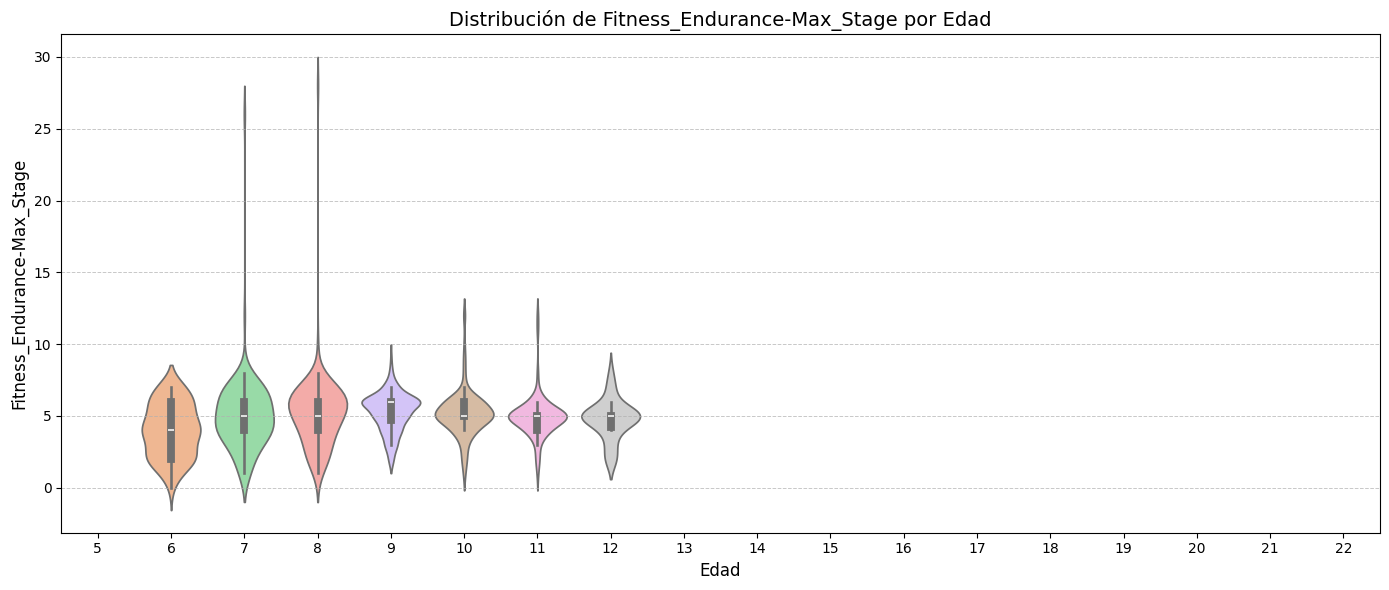

In [41]:
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=df_train,
    x="Basic_Demos-Age",
    hue="Basic_Demos-Age",
    y="Fitness_Endurance-Max_Stage",
    palette="pastel",
    legend=False,
)

plt.title("Distribución de Fitness_Endurance-Max_Stage por Edad", fontsize=14)
plt.xlabel("Edad", fontsize=12)
plt.ylabel("Fitness_Endurance-Max_Stage", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico muestra la distribución del Fitness_Endurance-Max_Stage según la edad, y hay algunas observaciones clave:

* La mayoría de los participantes alcanzan entre 4 y 6 etapas, sin importar la edad, lo que sugiere que el rendimiento promedio es bastante estable en todas las edades.
* Se observan algunos valores extremos en edades más bajas (6-8 años), donde algunos individuos alcanzan más de 25 etapas, lo cual es bastante inusual y podría ser un error de medición o casos excepcionales.
* A partir de los 10 años, la variabilidad disminuye, y la distribución es más uniforme, lo que indica que la resistencia tiende a estabilizarse.

En el PDF se mencionaba que los adolescentes tenían mayor resistencia, pero aquí los datos reales muestran que el rendimiento es similar en todas las edades, con algunas excepciones en los valores extremos. Esto podría indicar que la edad no es un factor tan determinante en esta prueba como se pensaba inicialmente.

#### Histograma de minutos y segundos combinados

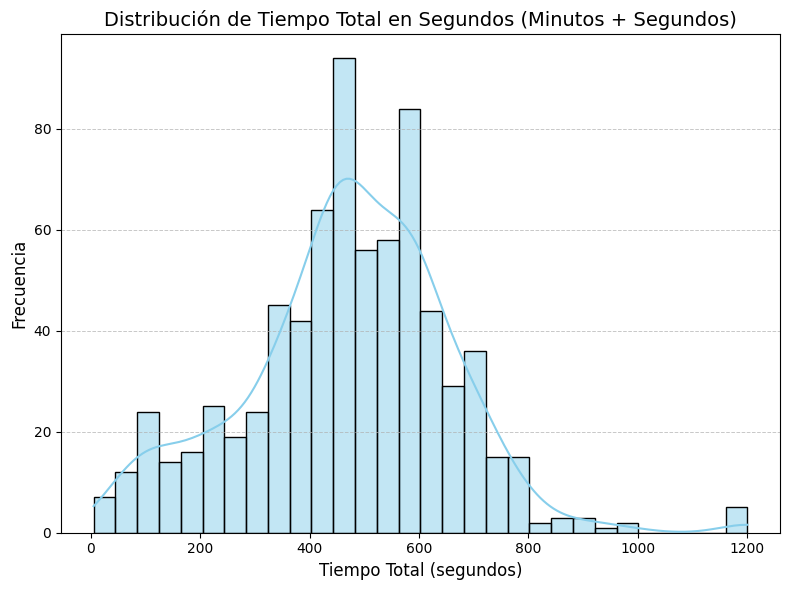

In [42]:
df_train["Fitness_Endurance-Total_Seconds"] = (
    df_train["Fitness_Endurance-Time_Mins"] * 60 + df_train["Fitness_Endurance-Time_Sec"]
)

plt.figure(figsize=(8, 6))
sns.histplot(
    df_train,
    x="Fitness_Endurance-Total_Seconds",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
)

plt.title("Distribución de Tiempo Total en Segundos (Minutos + Segundos)", fontsize=14)
plt.xlabel("Tiempo Total (segundos)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El histograma muestra la distribución del tiempo total en segundos (minutos + segundos) en la prueba de resistencia, y hay algunos puntos clave:

* La mayoría de los participantes completan la prueba en 400 a 700 segundos (aproximadamente 6-11 minutos), lo que indica que este es el rango más común de resistencia.
* Hay algunos valores en los extremos, con participantes que registran tiempos muy bajos (menos de 100 segundos) y algunos que superan los 1000 segundos, lo que es bastante raro y podría ser un error en la medición o casos muy excepcionales.
* La distribución tiene una forma sesgada a la derecha, lo que indica que hay más participantes con tiempos moderados que con tiempos extremadamente largos.

Estos datos encajan con lo que se observó en gráficos anteriores, donde la resistencia promedio se mantenía en torno a los 7-10 minutos y algunos individuos no lograban completar la prueba. También refuerzan la idea de que los valores extremos deben revisarse, ya que podrían afectar la interpretación general de la resistencia en la muestra.

#### Estación del año correspondiente a las medidas de Fitness_Endurance

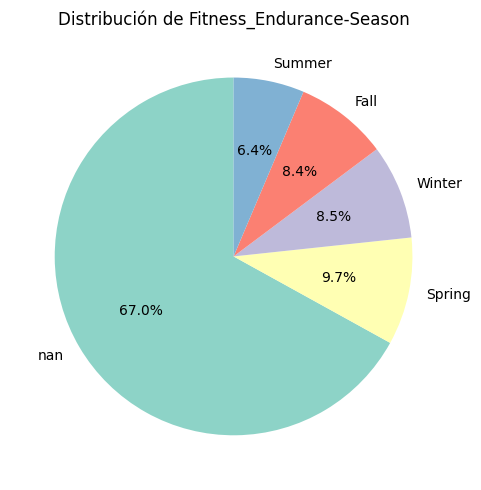

In [43]:
season_counts = (
    df_train["Fitness_Endurance-Season"].value_counts(normalize=True, dropna=False) * 100
)

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de Fitness_Endurance-Season")

plt.tight_layout()
plt.show()


### `FitnessGram Child`

In [44]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("FGC") and col != "FGC-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count       mean        std  min   25%    50%     75%  \
FGC-FGC_CU         2322.0  11.259690  11.807781  0.0   3.0   9.00  15.750   
FGC-FGC_CU_Zone    2282.0   0.476337   0.499549  0.0   0.0   0.00   1.000   
FGC-FGC_GSND       1074.0  22.420438  10.833995  0.0  15.1  20.05  26.600   
FGC-FGC_GSND_Zone  1062.0   1.829567   0.612585  1.0   1.0   2.00   2.000   
FGC-FGC_GSD        1074.0  23.518622  11.148951  0.0  16.2  21.20  28.175   
FGC-FGC_GSD_Zone   1063.0   1.904045   0.612344  1.0   2.0   2.00   2.000   
FGC-FGC_PU         2310.0   5.579654   7.390161  0.0   0.0   3.00   9.000   
FGC-FGC_PU_Zone    2271.0   0.330251   0.470407  0.0   0.0   0.00   1.000   
FGC-FGC_SRL        2305.0   8.694924   3.429301  0.0   7.0   9.00  11.000   
FGC-FGC_SRL_Zone   2267.0   0.618880   0.485769  0.0   0.0   1.00   1.000   
FGC-FGC_SRR        2307.0   8.805635   3.422167  0.0   7.0   9.00  11.000   
FGC-FGC_SRR_Zone   2269.0   0.620097   0.485469  0.0   0.0   1.00   1.000   

#### Histogramas de los atributos de FGC

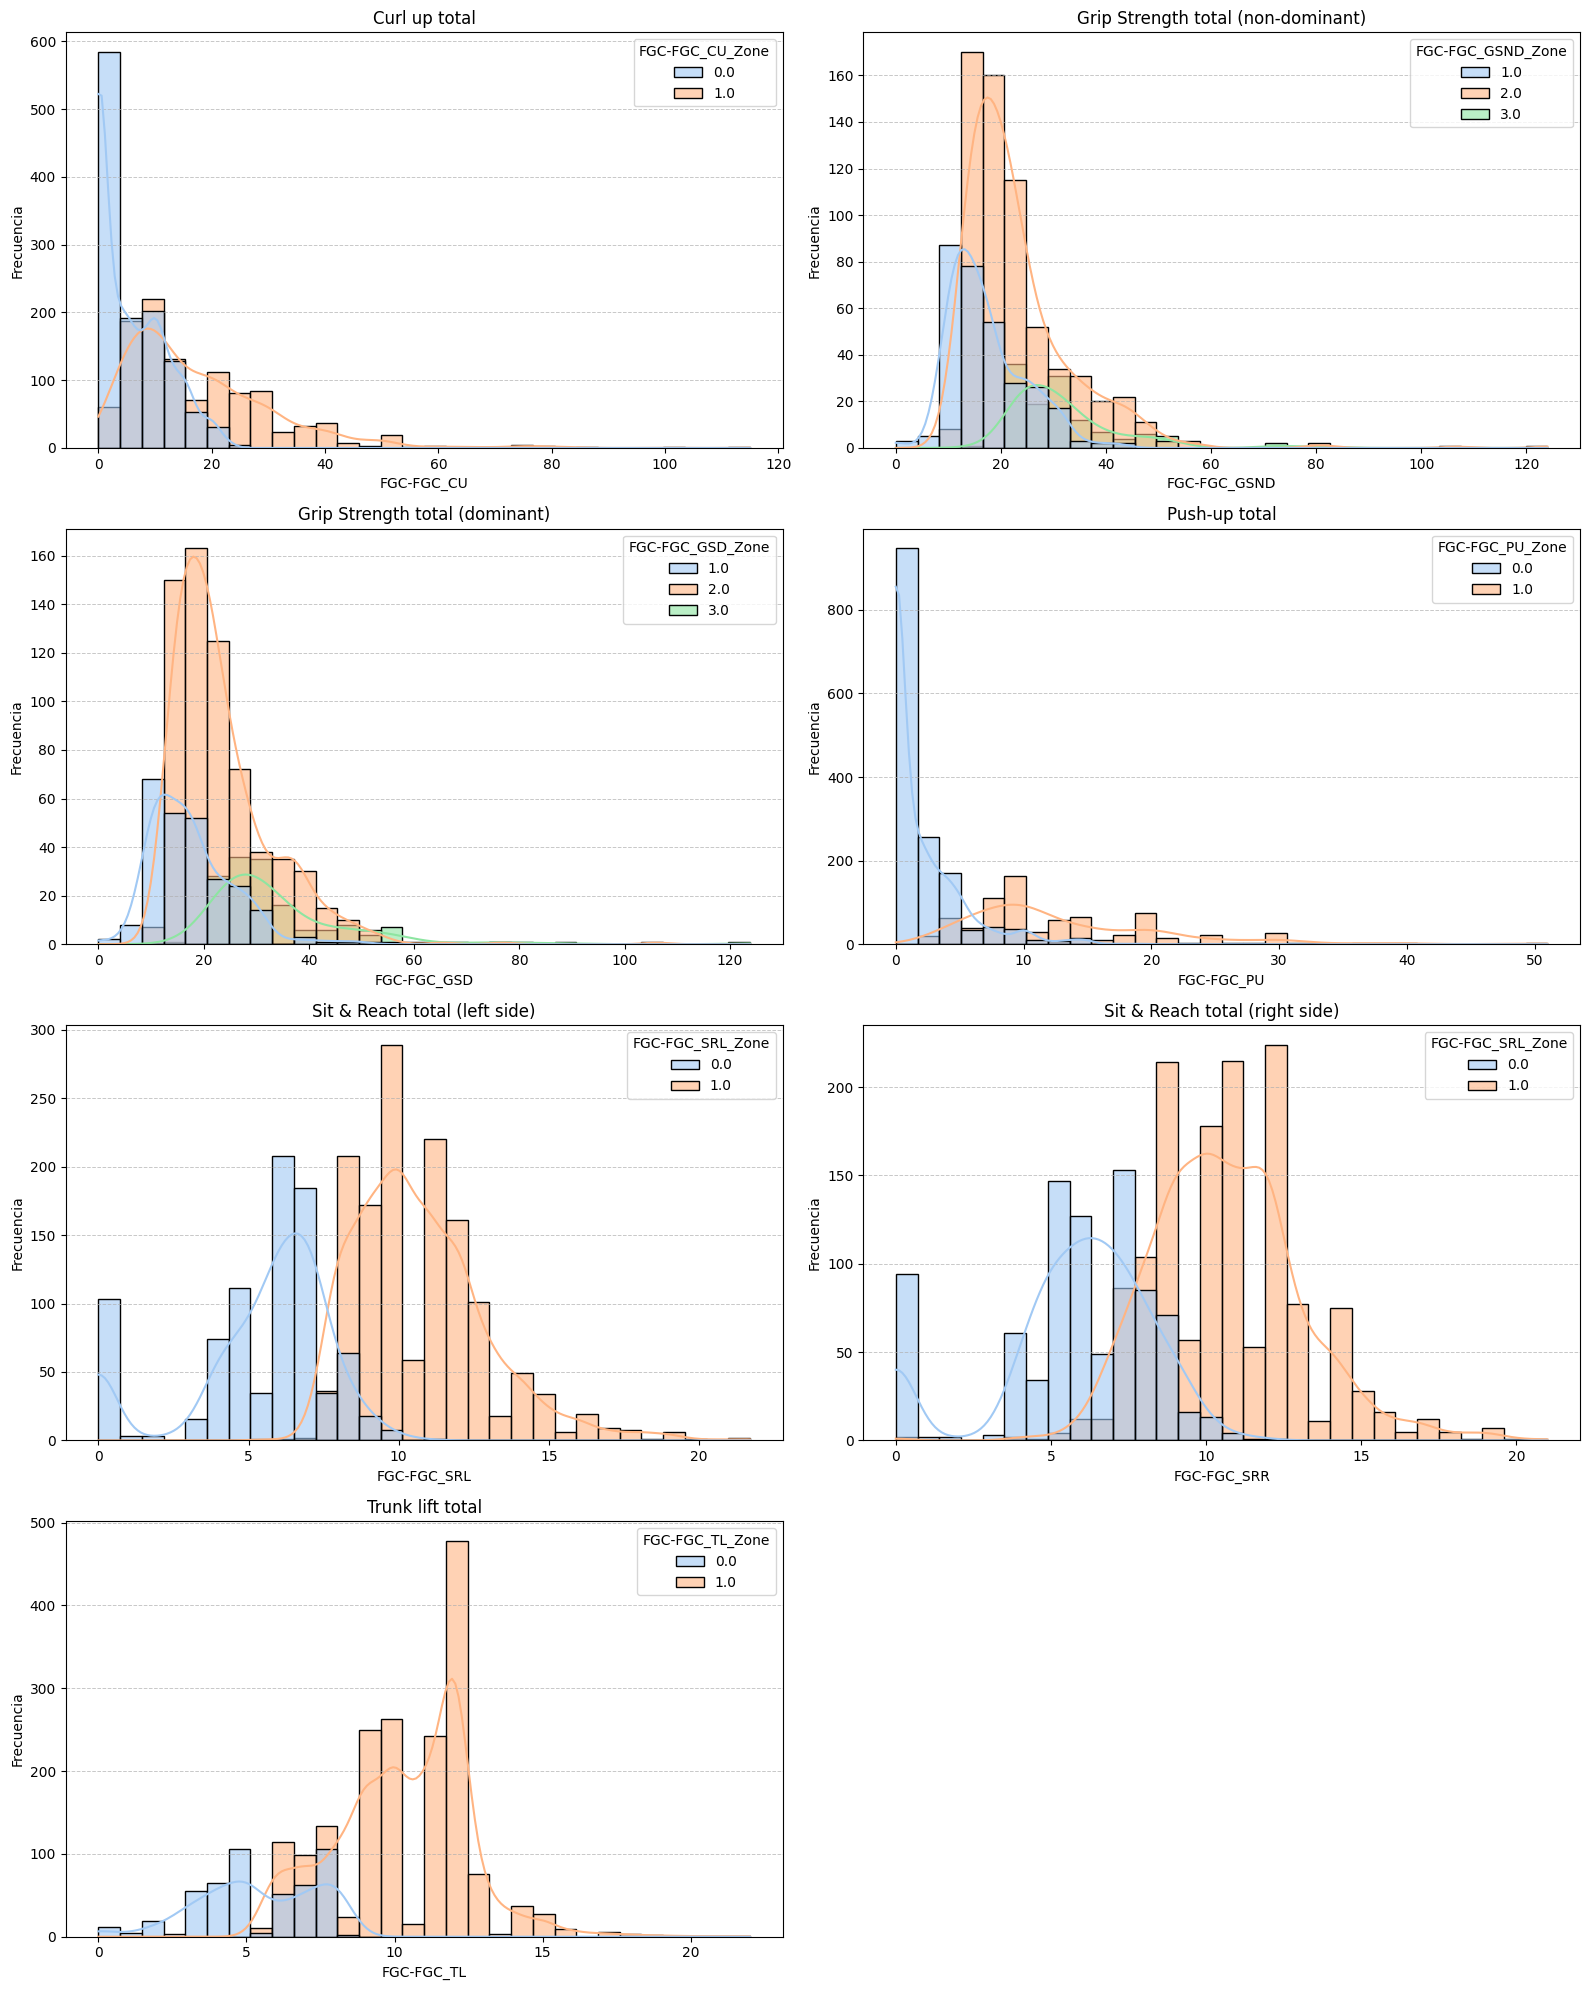

In [45]:
column_pairs = [
    ("FGC-FGC_CU", "FGC-FGC_CU_Zone"),
    ("FGC-FGC_GSND", "FGC-FGC_GSND_Zone"),
    ("FGC-FGC_GSD", "FGC-FGC_GSD_Zone"),
    ("FGC-FGC_PU", "FGC-FGC_PU_Zone"),
    ("FGC-FGC_SRL", "FGC-FGC_SRL_Zone"),
    ("FGC-FGC_SRR", "FGC-FGC_SRL_Zone"),
    ("FGC-FGC_TL", "FGC-FGC_TL_Zone"),
]

n_cols = 2
n_rows = len(column_pairs) // n_cols + (len(column_pairs) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, (x_col, hue_col) in enumerate(column_pairs):
    sns.histplot(
        data=df_train,
        x=x_col,
        hue=hue_col,
        kde=True,
        multiple="layer",
        alpha=0.6,
        bins=30,
        palette="pastel",
        edgecolor="black",
        ax=axes[i],
    )

    description = df_dictionary.loc[df_dictionary["Field"] == x_col, "Description"].values
    title = description[0] if len(description) > 0 else f"Distribución de {x_col} por {hue_col}"

    axes[i].set_title(title, fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel("Frecuencia", fontsize=10)
    axes[i].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

for j in range(len(column_pairs), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Los gráficos muestran la distribución de diferentes pruebas físicas realizadas en el FitnessGram Child (FGC), diferenciadas por zonas de clasificación de rendimiento. Algunas observaciones clave:

* Curl-ups, push-ups y fuerza de agarre (dominante y no dominante) tienen una distribución sesgada a la derecha, con la mayoría de los participantes registrando valores bajos y pocos logrando puntajes altos. Esto indica que la mayoría tiene un rendimiento bajo o moderado en estas pruebas de fuerza y resistencia.
* Sit & Reach (flexibilidad lateral) y Trunk Lift (levantamiento de tronco) tienen distribuciones más equilibradas, lo que sugiere que la flexibilidad y la movilidad del tronco son más homogéneas entre los participantes.
* Se observa que los individuos clasificados en zonas de mejor rendimiento (categoría 1) suelen tener valores más altos en todas las pruebas, lo que confirma que la clasificación refleja diferencias reales en desempeño físico.

En el PDF se mencionaba que había una correlación entre fuerza de agarre y flexibilidad, lo cual se puede notar en los gráficos, ya que las distribuciones muestran una clara segmentación en función del nivel de rendimiento. Además, el documento sugería que algunos valores parecían inconsistentes, pero aquí la distribución sigue patrones esperados, lo que sugiere que los datos son bastante coherentes.

#### Comparación extremidad dominante vs no dominante

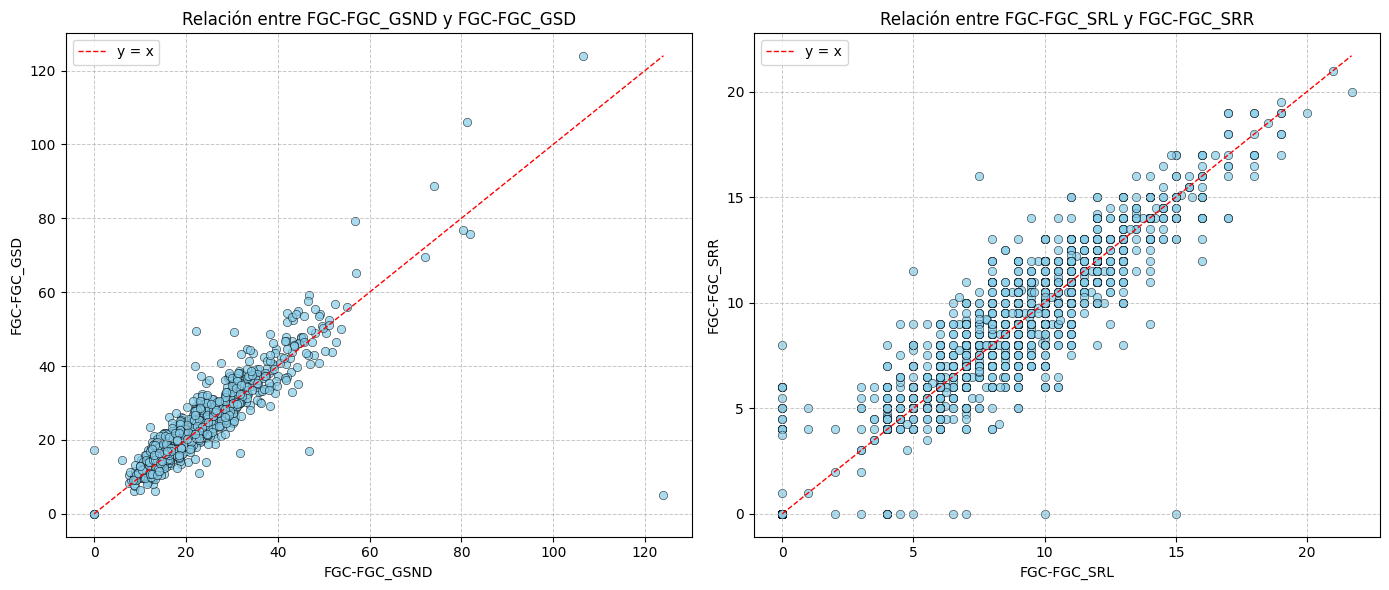

In [46]:
scatter_pairs = [("FGC-FGC_GSND", "FGC-FGC_GSD"), ("FGC-FGC_SRL", "FGC-FGC_SRR")]

fig, axes = plt.subplots(1, len(scatter_pairs), figsize=(14, 6))

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(
        data=df_train, x=x_col, y=y_col, alpha=0.7, color="skyblue", edgecolor="black", ax=axes[i]
    )

    axes[i].set_title(f"Relación entre {x_col} y {y_col}", fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel(y_col, fontsize=10)
    axes[i].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

    min_val = min(df_train[x_col].min(), df_train[y_col].min())
    max_val = max(df_train[x_col].max(), df_train[y_col].max())
    axes[i].plot(
        [min_val, max_val],
        [min_val, max_val],
        color="red",
        linestyle="--",
        linewidth=1,
        label="y = x",
    )
    axes[i].legend()

plt.tight_layout()
plt.show()


Los gráficos muestran la relación entre fuerza de agarre en ambas manos (izquierda) y flexibilidad en ambos lados (derecha).

* En fuerza de agarre (dominante vs. no dominante), hay una fuerte correlación positiva, lo que indica que quienes tienen más fuerza en una mano también la tienen en la otra, aunque con algunas excepciones. Hay unos pocos valores que se alejan de la diagonal, lo que sugiere que en ciertos casos hay una diferencia notable entre ambas manos.
* En flexibilidad (lado izquierdo vs. derecho), la correlación también es alta, lo que confirma que la mayoría de los participantes tienen una flexibilidad equilibrada en ambos lados. Sin embargo, hay más dispersión que en la fuerza de agarre, lo que podría indicar que hay personas con diferencias significativas en su flexibilidad dependiendo del lado del cuerpo.

Los datos muestran que la mayoría de los participantes tienen un desarrollo bastante simétrico, aunque en algunos casos hay diferencias notables. Esto confirma que las mediciones son coherentes y siguen patrones esperados, sin grandes anomalías.

#### Correlaciones entre los atributos de FGC

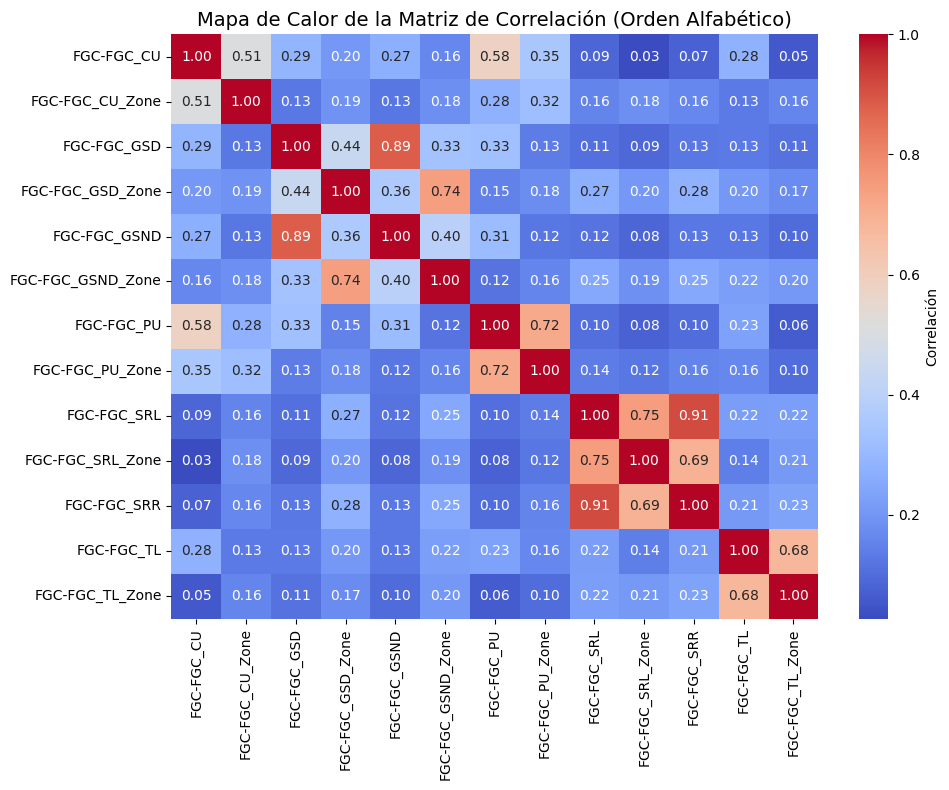

In [47]:
all_columns = sorted(list(set([col for pair in column_pairs for col in pair])))

correlation_matrix = df_train[all_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Correlación"}
)

plt.title("Mapa de Calor de la Matriz de Correlación (Orden Alfabético)", fontsize=14)

plt.tight_layout()
plt.show()


El mapa de calor muestra la correlación entre diferentes pruebas físicas, y se pueden destacar algunos puntos clave:

* Las correlaciones más altas se encuentran entre las versiones izquierda y derecha de la misma prueba, como en Sit & Reach (SRL-SRR, 0.91) y en las zonas de clasificación de flexibilidad y fuerza, lo que tiene sentido ya que son mediciones relacionadas.
* La fuerza de agarre dominante y no dominante (GSD-GSND) tienen una correlación alta (0.89), lo que confirma que quienes tienen más fuerza en una mano también suelen tenerla en la otra, aunque no es completamente simétrico.
* Las correlaciones con Push-ups y Curl-ups son moderadas (0.58 y 0.51 entre sí), lo que sugiere que hay una relación entre la fuerza del core y la resistencia muscular.
* La flexibilidad (SRL, SRR) tiene correlaciones bajas con otras pruebas de fuerza, lo que indica que no hay una relación clara entre la movilidad y la fuerza muscular en este dataset.

En general, los datos reflejan patrones esperados, sin grandes sorpresas ni inconsistencias evidentes. Se confirma que las pruebas que miden atributos similares están bien relacionadas, lo que indica que las mediciones son consistentes.

#### Estación del año correspondiente a las medidas de FGC

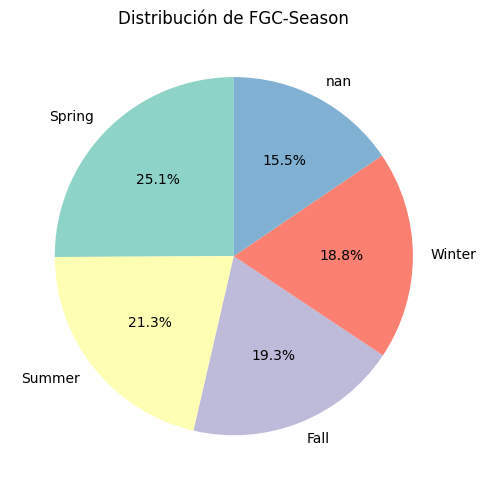

In [48]:
season_counts = df_train["FGC-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de FGC-Season")

plt.tight_layout()
plt.show()


### `Sleep Disturbance Scale(SDS)`

In [49]:
columns_to_analyze = [
    col for col in df_train.columns if col.startswith("SDS") and col != "SDS-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count       mean        std   min   25%   50%   75%  \
SDS-SDS_Total_Raw  2609.0  41.088923  10.427433  17.0  33.0  39.0  46.0   
SDS-SDS_Total_T    2606.0  57.763622  13.196091  38.0  47.0  55.0  64.0   

                     max   nulls  
SDS-SDS_Total_Raw   96.0  1351.0  
SDS-SDS_Total_T    100.0  1354.0  


#### Histograma de ambas puntuaciones de SDS

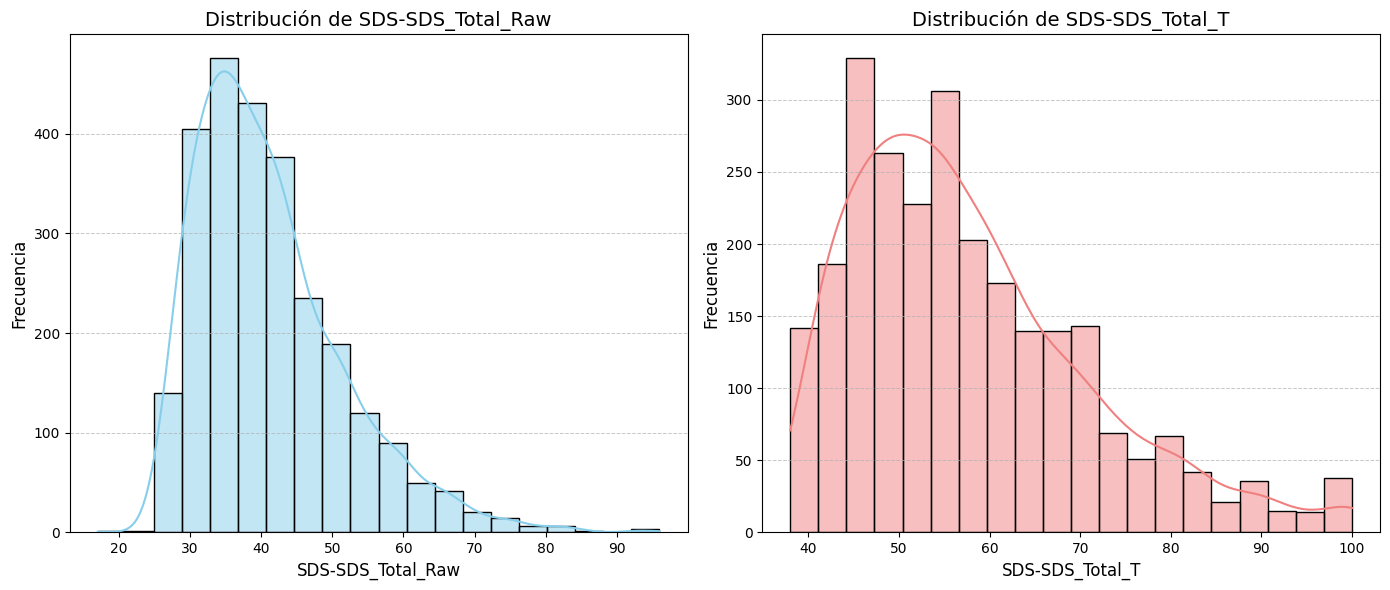

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=df_train,
    x=columns_to_analyze[0],
    kde=True,
    bins=20,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title(f"Distribución de {columns_to_analyze[0]}", fontsize=14)
axes[0].set_xlabel(columns_to_analyze[0], fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.histplot(
    data=df_train,
    x=columns_to_analyze[1],
    kde=True,
    bins=20,
    color="lightcoral",
    edgecolor="black",
    ax=axes[1],
)
axes[1].set_title(f"Distribución de {columns_to_analyze[1]}", fontsize=14)
axes[1].set_xlabel(columns_to_analyze[1], fontsize=12)
axes[1].set_ylabel("Frecuencia", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Los histogramas muestran la distribución de dos variables del Sleep Disturbance Scale (SDS), que miden problemas del sueño en los participantes.

* Ambas distribuciones tienen una forma similar, con una clara asimetría a la derecha, lo que indica que la mayoría de los participantes tienen puntajes bajos o moderados en la escala, mientras que hay menos casos con puntajes muy altos.
* La mayoría de los valores en SDS_Total_Raw están entre 30 y 50, mientras que en SDS_Total_T se concentran entre 40 y 60, lo que sugiere que la transformación T tiende a desplazar ligeramente los valores hacia arriba.
* Hay algunos valores extremos por encima de 80 en ambas distribuciones, lo que sugiere que hay un pequeño grupo con problemas de sueño severos.

Estos datos confirman que la mayoría de los participantes no presentan grandes problemas de sueño, aunque hay una minoría con puntajes elevados que podrían indicar trastornos más serios. La tendencia general parece coherente y sin anomalías evidentes.

#### Comparación puntuación total y raw

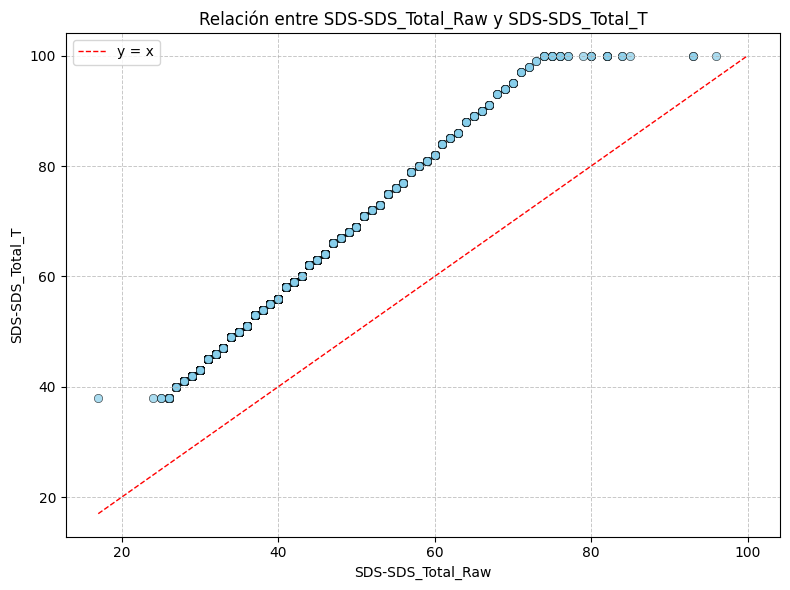

In [51]:
scatter_pairs = [(columns_to_analyze[0], columns_to_analyze[1])]

fig, axes = plt.subplots(1, len(scatter_pairs), figsize=(8, 6))

if len(scatter_pairs) == 1:
    axes = [axes]

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(
        data=df_train, x=x_col, y=y_col, alpha=0.7, color="skyblue", edgecolor="black", ax=axes[i]
    )

    axes[i].set_title(f"Relación entre {x_col} y {y_col}", fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel(y_col, fontsize=10)
    axes[i].grid(axis="both", linestyle="--", linewidth=0.7, alpha=0.7)

    min_val = min(df_train[x_col].min(), df_train[y_col].min())
    max_val = max(df_train[x_col].max(), df_train[y_col].max())
    axes[i].plot(
        [min_val, max_val],
        [min_val, max_val],
        color="red",
        linestyle="--",
        linewidth=1,
        label="y = x",
    )
    axes[i].legend()

plt.tight_layout()
plt.show()


El gráfico muestra que SDS_Total_Raw y SDS_Total_T están súper alineados, lo que indica que la transformación de los datos sigue un patrón claro y sin sorpresas.

* La relación es casi perfectamente lineal, así que no parece haber errores en la conversión.
* Hay un puntito raro en la parte baja, pero en general, todo sigue la tendencia esperada.
* SDS_Total_T siempre da valores más altos que SDS_Total_Raw, lo que seguramente se debe a una normalización o ajuste en la escala.

En resumen, todo está en orden con la conversión de los datos, y los valores parecen bien calculados sin anomalías evidentes

#### Estación del año correspondiente a las medidas de SDS

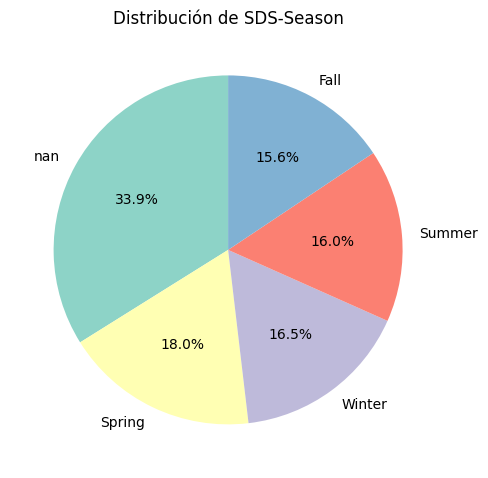

In [52]:
season_counts = df_train["SDS-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de SDS-Season")

plt.tight_layout()
plt.show()


### `Physical Activity Questionnaire(PAQ)`

In [53]:
columns_to_analyze = [
    col
    for col in df_train.columns
    if col.startswith("PAQ") and col != "PAQ_A-Season" and col != "PAQ_C-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)


                    count      mean       std   min   25%   50%   75%   max  \
PAQ_A-PAQ_A_Total   475.0  2.178853  0.849476  0.66  1.49  2.01  2.78  4.71   
PAQ_C-PAQ_C_Total  1721.0  2.589550  0.783937  0.58  2.02  2.54  3.16  4.79   

                    nulls  
PAQ_A-PAQ_A_Total  3485.0  
PAQ_C-PAQ_C_Total  2239.0  


#### Histograma + Distribución de puntuaciones de adolesentes

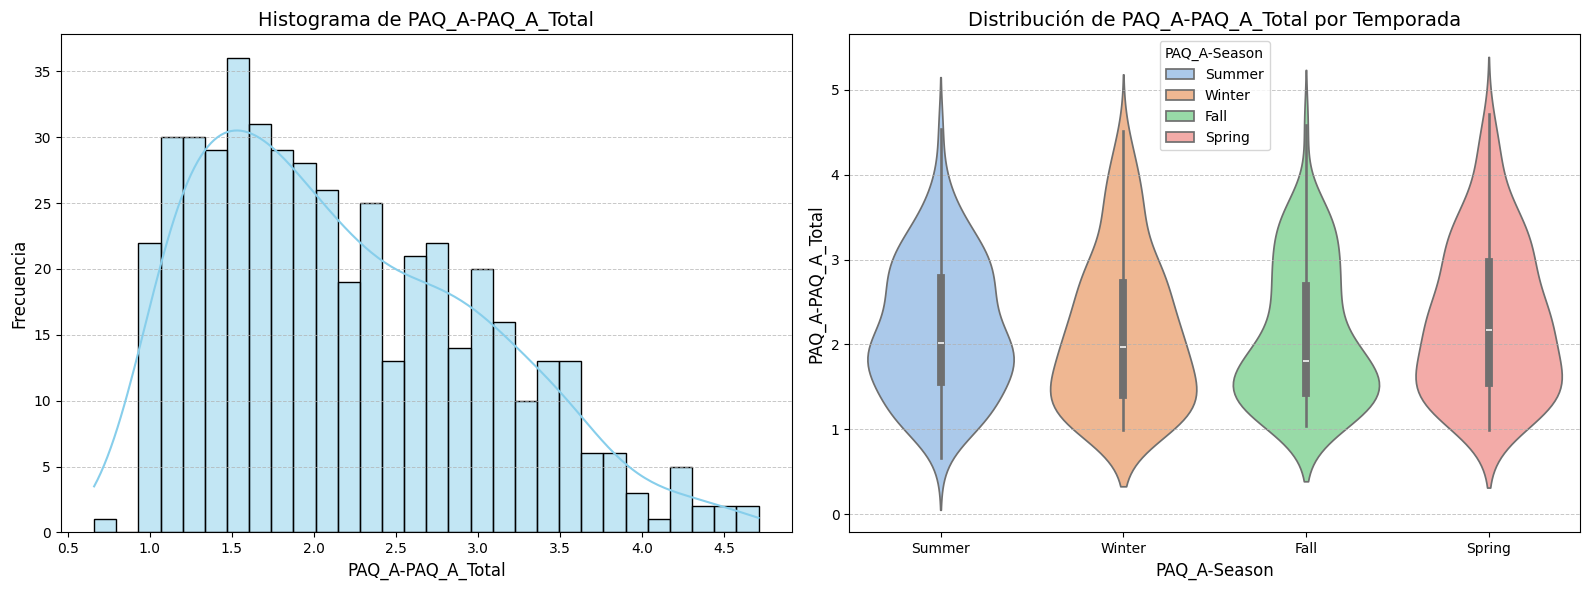

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(
    data=df_train,
    x="PAQ_A-PAQ_A_Total",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title("Histograma de PAQ_A-PAQ_A_Total", fontsize=14)
axes[0].set_xlabel("PAQ_A-PAQ_A_Total", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.violinplot(
    data=df_train,
    x="PAQ_A-Season",
    hue="PAQ_A-Season",
    y="PAQ_A-PAQ_A_Total",
    palette="pastel",
    ax=axes[1],
)
axes[1].set_title("Distribución de PAQ_A-PAQ_A_Total por Temporada", fontsize=14)
axes[1].set_xlabel("PAQ_A-Season", fontsize=12)
axes[1].set_ylabel("PAQ_A-PAQ_A_Total", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


* El histograma (izquierda) muestra que la mayoría de los participantes tienen una actividad física entre 1.5 y 3, con algunos casos llegando hasta 4.5. La distribución es algo sesgada a la derecha, lo que indica que hay menos personas con niveles muy altos de actividad.
* El gráfico de violín (derecha) muestra que la actividad física es bastante similar en todas las estaciones, aunque hay algo más de dispersión en verano y primavera. Esto sugiere que no hay una gran diferencia en los niveles de actividad según la temporada, aunque en verano algunos alcanzan valores más altos.

En el PDF se mencionaba que la actividad física podría no variar mucho entre estaciones, y estos datos confirman esa observación. No hay una diferencia clara entre invierno y verano, lo que sugiere que otros factores podrían estar influyendo más en la actividad física que la temporada en sí.

#### Estación del año correspondiente a las medidas de PAQ_A-Season

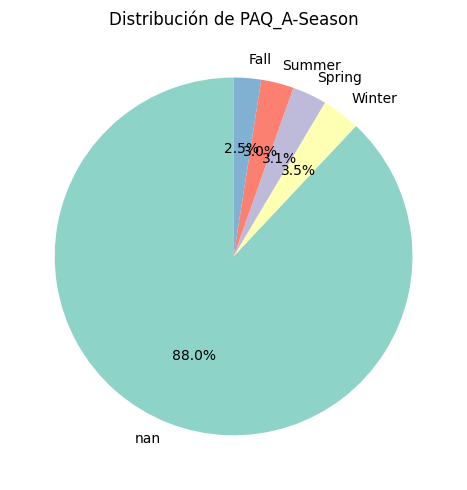

In [55]:
season_counts = df_train["PAQ_A-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PAQ_A-Season")

plt.tight_layout()
plt.show()


#### Histograma + Distribución de puntuaciones de niños

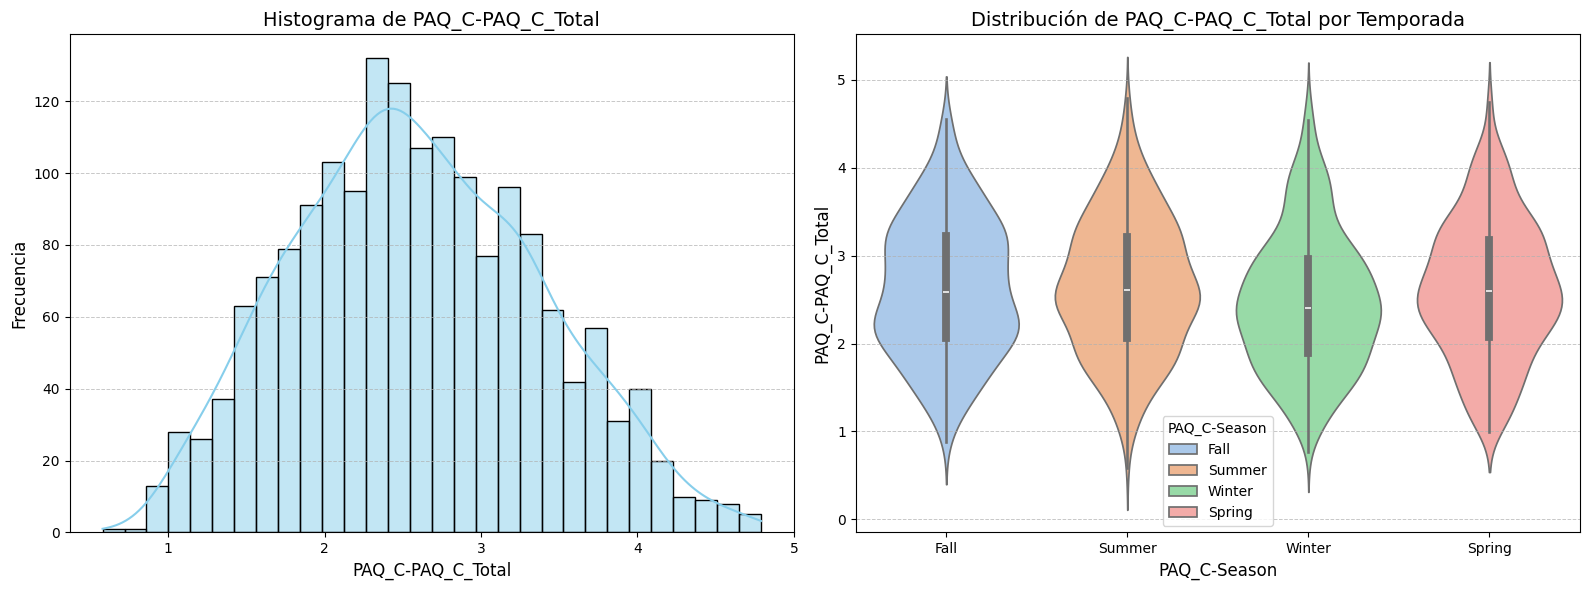

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(
    data=df_train,
    x="PAQ_C-PAQ_C_Total",
    kde=True,
    bins=30,
    color="skyblue",
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title("Histograma de PAQ_C-PAQ_C_Total", fontsize=14)
axes[0].set_xlabel("PAQ_C-PAQ_C_Total", fontsize=12)
axes[0].set_ylabel("Frecuencia", fontsize=12)
axes[0].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

sns.violinplot(
    data=df_train,
    x="PAQ_C-Season",
    hue="PAQ_C-Season",
    y="PAQ_C-PAQ_C_Total",
    palette="pastel",
    ax=axes[1],
)
axes[1].set_title("Distribución de PAQ_C-PAQ_C_Total por Temporada", fontsize=14)
axes[1].set_xlabel("PAQ_C-Season", fontsize=12)
axes[1].set_ylabel("PAQ_C-PAQ_C_Total", fontsize=12)
axes[1].grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Los gráficos muestran la distribución de PAQ_C_Total, que mide la actividad física en niños, y su variación según la temporada.

* El histograma (izquierda) tiene una forma bastante simétrica, con la mayoría de los valores entre 2 y 3.5, lo que sugiere que la actividad física de los niños es moderada en general. Hay menos participantes con valores extremos.
* El gráfico de violín (derecha) muestra que la actividad física es similar en todas las estaciones, con una ligera variabilidad en invierno, donde algunos niños reportan valores más bajos. Esto indica que la estación del año no parece afectar mucho la actividad física en este grupo.

Los datos encajan con lo visto en la actividad física de adolescentes (PAQ_A), donde tampoco había grandes diferencias estacionales. Esto sugiere que la actividad física en niños y adolescentes se mantiene bastante estable a lo largo del año, sin cambios drásticos según la temporada.

#### Estación del año correspondiente a las medidas de PAQ_C-Season

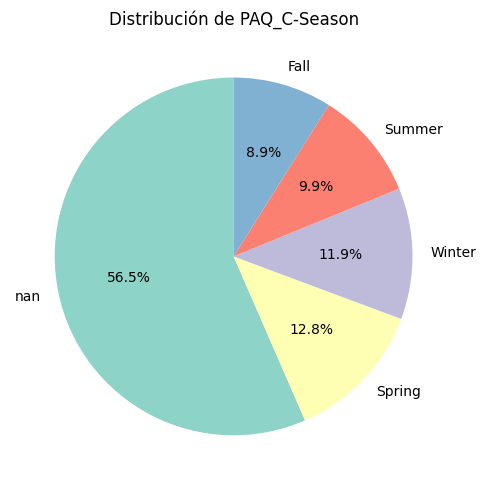

In [57]:
season_counts = df_train["PAQ_C-Season"].value_counts(normalize=True, dropna=False) * 100

season_labels = season_counts.index.tolist()
season_values = season_counts.values.tolist()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    season_values,
    labels=season_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set3"),
)

ax.set_title("Distribución de PAQ_C-Season")

plt.tight_layout()
plt.show()


In [58]:
data = df_train[df_train["PAQ_A-PAQ_A_Total"].notnull()]
age_range = data["Basic_Demos-Age"]
print(
    f"Rango de edad de adolescentes según PAQ_A-PAQ_A_Total: "
    f" {age_range.min()} - {age_range.max()} años"
)


Rango de edad de adolescentes según PAQ_A-PAQ_A_Total:  13 - 18 años


In [59]:
data = df_train[df_train["PAQ_C-PAQ_C_Total"].notnull()]
age_range = data["Basic_Demos-Age"]
print(
    f"Rango de edad de niños según PAQ_C-PAQ_C_Total:  {age_range.min()} - {age_range.max()} años"
)


Rango de edad de niños según PAQ_C-PAQ_C_Total:  7 - 17 años


`NOTA:` Parece que las edades que nos dan estos atributos no están en un rango correcto según los valores anteiormente vistos. 

### `Internet Use(PreInt)`

In [60]:
columns_to_analyze = [
    col
    for col in df_train.columns
    if col.startswith("PreInt") and col != "PreInt_EduHx-Season"
]
stats_table = calculate_stats_with_nulls(df_train, columns_to_analyze)

print(stats_table)

                                         count      mean       std  min  25%  \
PreInt_EduHx-computerinternet_hoursday  3301.0  1.060588  1.094875  0.0  0.0   

                                        50%  75%  max  nulls  
PreInt_EduHx-computerinternet_hoursday  1.0  2.0  3.0  659.0  


#### Histograma de las horas de internet

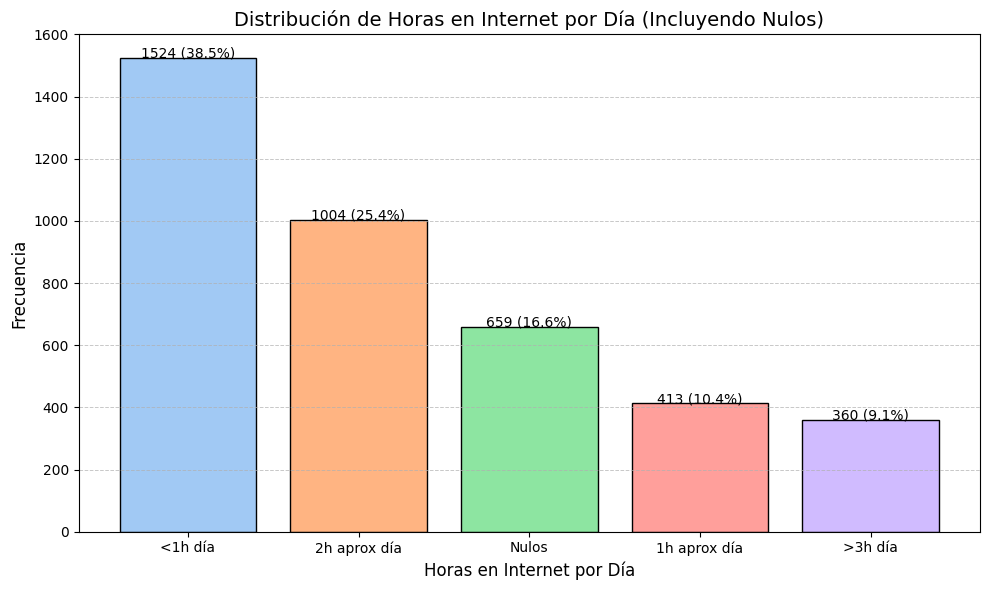

In [61]:
labels_mapping = {
    0: '<1h día',
    1: '1h aprox día',
    2: '2h aprox día',
    3: '>3h día'
}

df_train['PreInt_EduHx-mapped'] = df_train['PreInt_EduHx-computerinternet_hoursday'].map(labels_mapping)
counts = df_train['PreInt_EduHx-mapped'].value_counts(dropna=False)

counts.index = counts.index.fillna('Nulos') # type: ignore
percentages = (counts / counts.sum()) * 100

plt.figure(figsize=(10, 6))
colors = sns.color_palette("pastel", len(counts))

bars = plt.bar(
    counts.index,
    counts.values.tolist(),
    color=colors,
    edgecolor='black'
)

for bar, value, percentage in zip(bars, counts.values, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{value} ({percentage:.1f}%)',
        ha='center',
        fontsize=10
    )

plt.title('Distribución de Horas en Internet por Día (Incluyendo Nulos)', fontsize=14)
plt.xlabel('Horas en Internet por Día', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


La mayoría de los participantes usa Internet menos de 2 horas al día, con un 38.5% por debajo de 1 hora y un 25.4% en torno a 2 horas. El uso excesivo de más de 3 horas es menos común (9.1%), mientras que hay un 16.6% de valores nulos que podrían indicar datos faltantes o no reportados. En general, el consumo de Internet en esta muestra parece moderado.

#### Horas según edad y grupos de edad

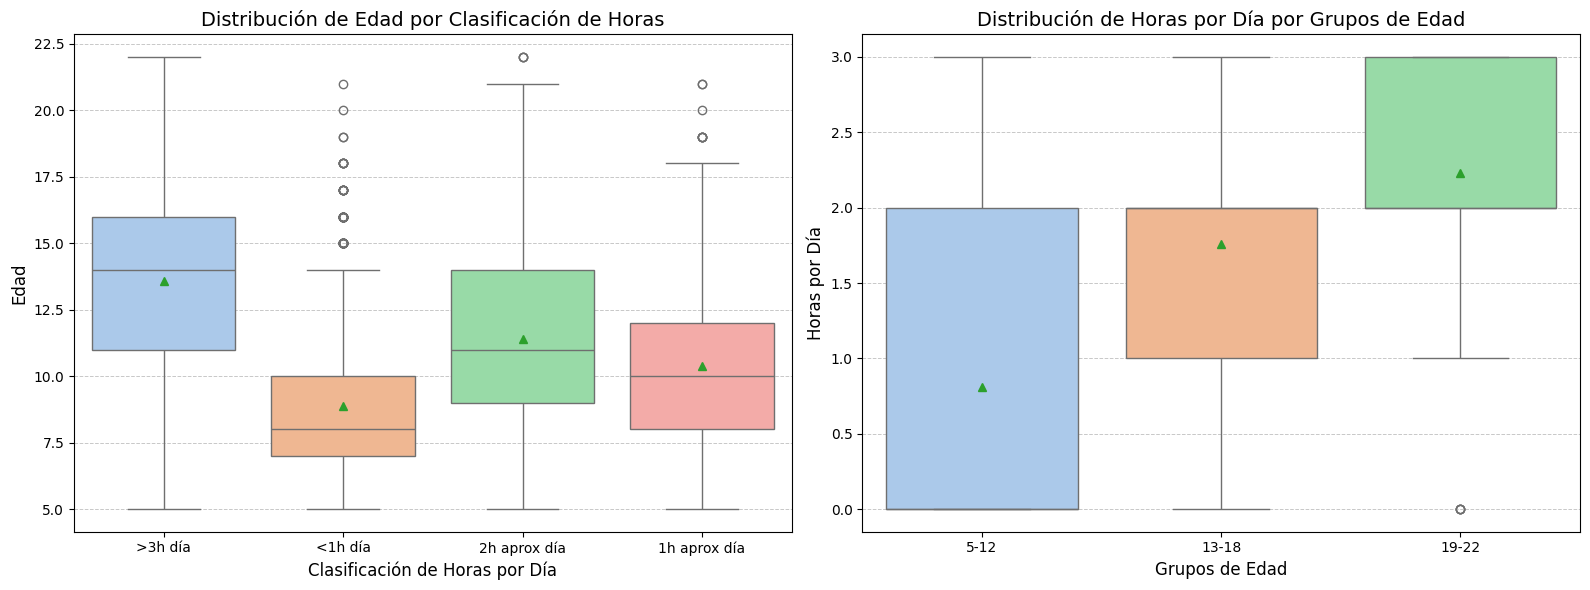

In [62]:
df_train['Edad_Rango'] = pd.cut(
    df_train['Basic_Demos-Age'], 
    bins=[4, 12, 18, 22], 
    labels=['5-12', '13-18', '19-22']
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=df_train,
    x='PreInt_EduHx-mapped',
    hue='PreInt_EduHx-mapped',
    legend=False,
    y='Basic_Demos-Age',
    palette="pastel",
    ax=axes[0],
    showmeans=True
)
axes[0].set_title('Distribución de Edad por Clasificación de Horas', fontsize=14)
axes[0].set_xlabel('Clasificación de Horas por Día', fontsize=12)
axes[0].set_ylabel('Edad', fontsize=12)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

sns.boxplot(
    data=df_train,
    x='Edad_Rango',
    hue='Edad_Rango',
    legend=False,
    y='PreInt_EduHx-computerinternet_hoursday',
    palette="pastel",
    ax=axes[1],
    showmeans=True
)
axes[1].set_title('Distribución de Horas por Día por Grupos de Edad', fontsize=14)
axes[1].set_xlabel('Grupos de Edad', fontsize=12)
axes[1].set_ylabel('Horas por Día', fontsize=12)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Los gráficos muestran la relación entre edad y uso de Internet. 
* Se observa que los niños más pequeños (5-12 años) usan menos Internet, mientras que los adolescentes (13-18 años) y jóvenes adultos (19-22 años) tienden a pasar más tiempo conectados. 
* En la clasificación por horas, quienes usan más de 3 horas al día suelen ser mayores, mientras que los que usan menos de 1 hora son principalmente los más jóvenes. Esto confirma que el uso de Internet aumenta con la edad, con una mayor variabilidad en adolescentes y jóvenes.

#### Distribución de horas según grupo de edad

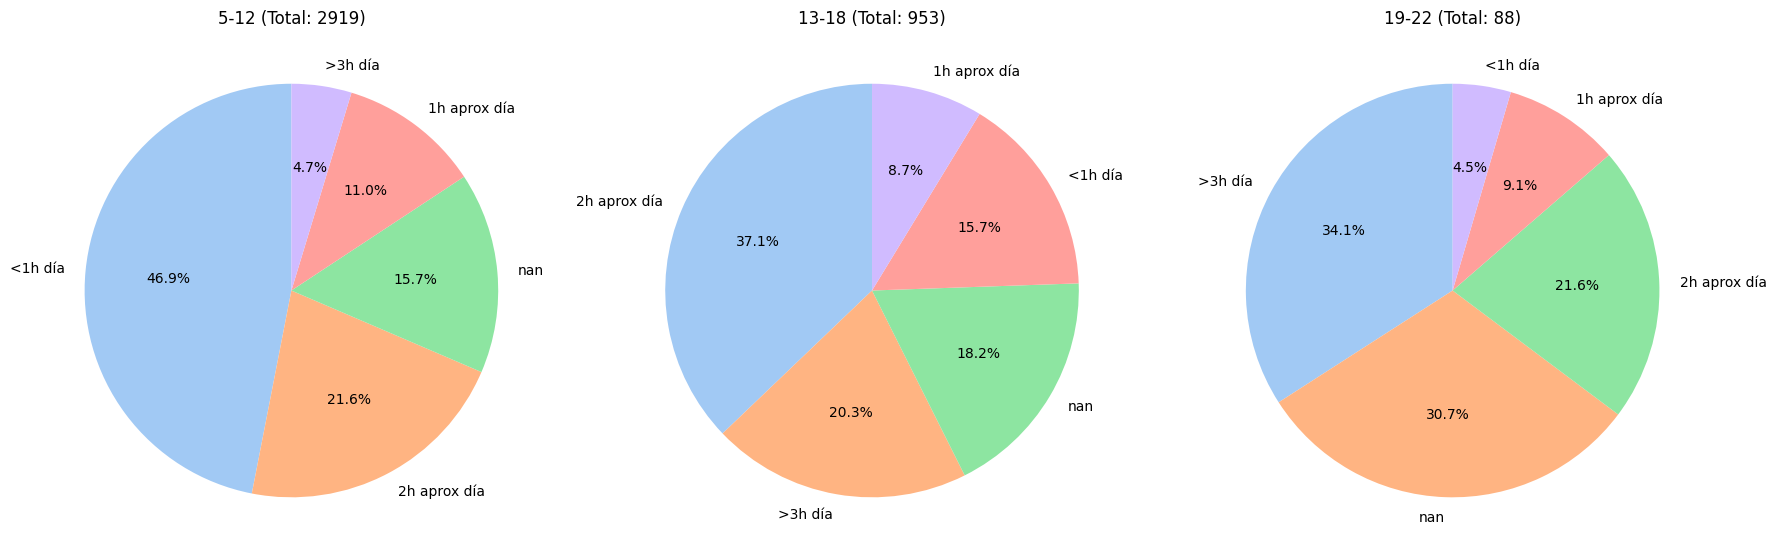

In [63]:
age_groups = ['5-12', '13-18', '19-22']
fig, axes = plt.subplots(1, len(age_groups), figsize=(18, 6))

for i, age_group in enumerate(age_groups):
    group_data = df_train[df_train['Edad_Rango'] == age_group]
    counts = group_data['PreInt_EduHx-mapped'].value_counts(dropna=False)
    percentages = (counts / counts.sum()) * 100

    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel"),
    )
    axes[i].set_title(f'{age_group} (Total: {counts.sum()})', fontsize=12)

plt.tight_layout()
plt.show()


El uso de Internet aumenta con la edad. 
* En el grupo de 5-12 años, casi la mitad usa menos de 1 hora al día, mientras que el uso intensivo (>3h) es mínimo. 
* En adolescentes (13-18 años), hay una distribución más equilibrada, con un aumento en el uso de más de 3 horas diarias. 
* En jóvenes adultos (19-22 años), el tiempo en Internet es aún mayor, con un 30.7% de datos nulos, lo que podría indicar menos respuestas en este grupo. 

En general, el patrón confirma que a mayor edad, más horas de conexión.

#### Cantidad de personas según PIU y sexo

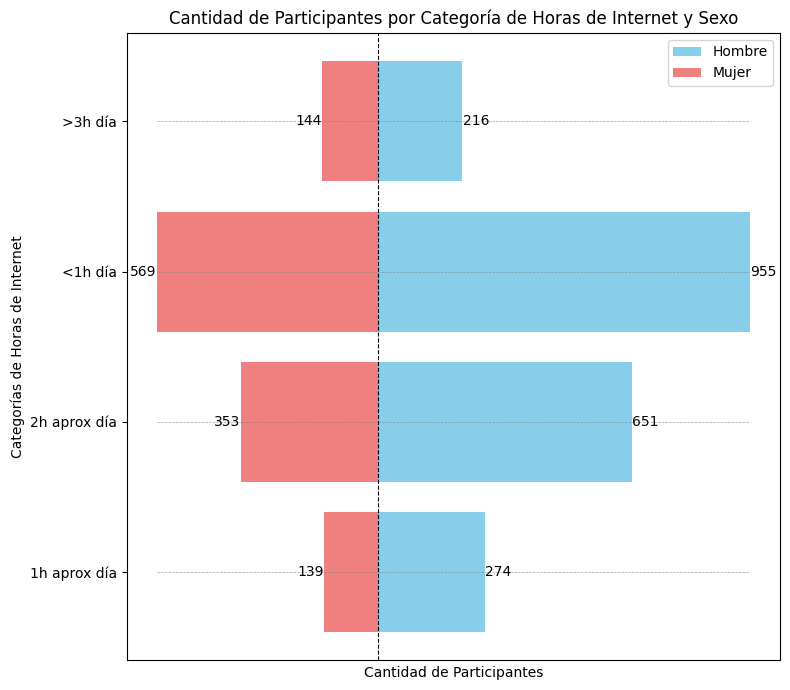

In [64]:
internet_gender_counts = (
    df_train.groupby(["PreInt_EduHx-mapped", "Basic_Demos-Sex"]).size().unstack(fill_value=0)
)

internet_categories = internet_gender_counts.index.tolist()
male_counts = internet_gender_counts.get(0, [0] * len(internet_categories))
female_counts = internet_gender_counts.get(1, [0] * len(internet_categories))

fig, ax = plt.subplots(figsize=(8, 7))

male_bars = ax.barh(internet_categories, male_counts, color="skyblue", label="Hombre")
female_bars = ax.barh(internet_categories, -female_counts, color="lightcoral", label="Mujer") # type: ignore

for bar in male_bars:
    width = bar.get_width()
    ax.text(
        width + 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="left"
    )
for bar in female_bars:
    width = abs(bar.get_width())
    ax.text(
        -width - 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="right"
    )

for category in internet_categories:
    ax.hlines(
        y=category,
        xmin=-max(female_counts),
        xmax=max(male_counts),
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )

ax.set_title("Cantidad de Participantes por Categoría de Horas de Internet y Sexo")
ax.set_xlabel("Cantidad de Participantes")
ax.set_ylabel("Categorías de Horas de Internet")
ax.axvline(0, color="black", linewidth=0.8, linestyle="--")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()


El uso de Internet es mayor en hombres que en mujeres en todas las categorías. La mayoría de los participantes, tanto hombres como mujeres, usan menos de 1 hora al día, aunque el número de hombres en esta categoría es significativamente mayor. En los grupos de uso más intensivo (>3h), los hombres también superan a las mujeres. Esto sugiere que, en esta muestra, los hombres tienden a pasar más tiempo en Internet que las mujeres.

#### Horas en Internet según SII

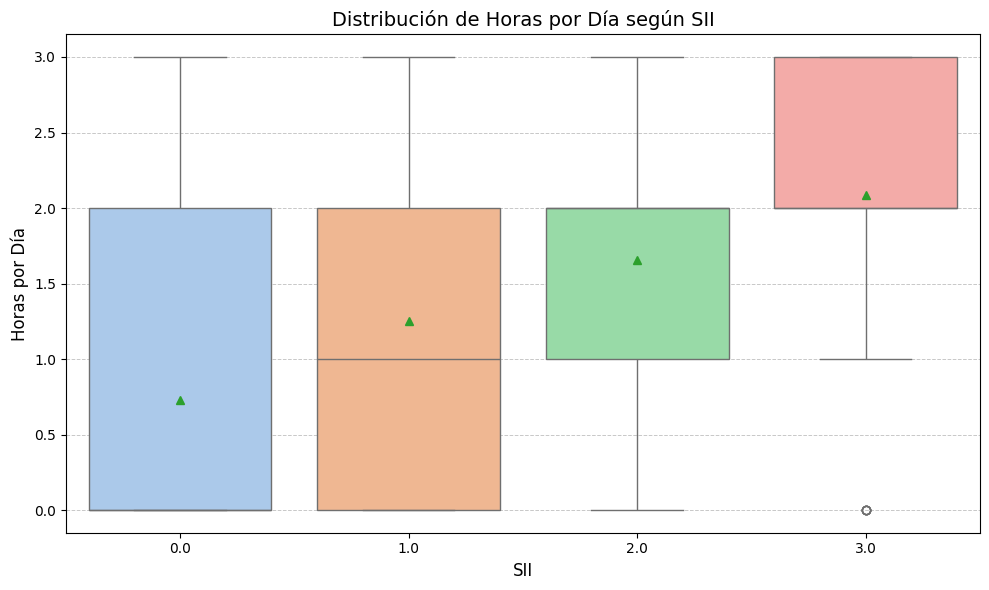

In [65]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_train,
    x='sii',
    hue='sii',
    legend=False,
    y='PreInt_EduHx-computerinternet_hoursday',
    palette="pastel",
    showmeans=True
)

plt.title('Distribución de Horas por Día según SII', fontsize=14)
plt.xlabel('SII', fontsize=12)
plt.ylabel('Horas por Día', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Se observa que el uso de Internet aumenta con el SII, ya que los valores más altos de SII tienden a mostrar medianas y promedios más elevados en el tiempo de conexión. Mientras que los valores más bajos de SII tienen una mayor variabilidad y una media más baja, los valores más altos muestran una mayor concentración en 2-3 horas diarias. Esto sugiere que puede haber una relación entre un mayor SII y un mayor uso de Internet.

#### Clasificación de PIU comparado con PCIAT Total

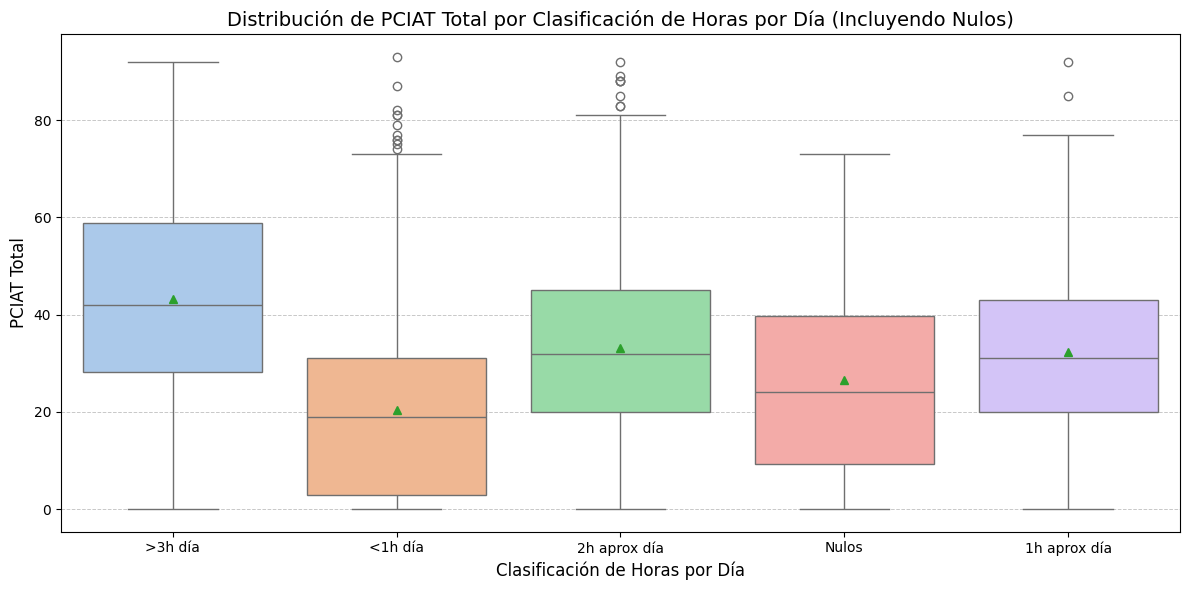

In [66]:
df_train['PreInt_EduHx-mapped'] = df_train['PreInt_EduHx-mapped'].fillna('Nulos')
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_train,
    x='PreInt_EduHx-mapped',
    hue='PreInt_EduHx-mapped',
    legend=False,
    y='PCIAT-PCIAT_Total',
    palette="pastel",
    showmeans=True
)

plt.title('Distribución de PCIAT Total por Clasificación de Horas por Día (Incluyendo Nulos)', fontsize=14)
plt.xlabel('Clasificación de Horas por Día', fontsize=12)
plt.ylabel('PCIAT Total', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico muestra que a más horas de Internet por día, mayor suele ser el PCIAT Total, lo que indica una posible relación entre el tiempo en línea y niveles más altos en la escala de adicción a Internet. Quienes usan más de 3 horas diarias tienen una mediana de PCIAT más alta, mientras que los que usan menos de 1 hora tienen valores más bajos en general. Sin embargo, hay bastante variabilidad en todas las categorías, con algunos valores extremos en cada grupo. Esto sugiere que, aunque hay una tendencia, no todos los que usan mucho Internet tienen puntajes altos en PCIAT, pero sí hay un patrón general que respalda la relación esperada.

#### Comparación PCIAT Total con clasificación de PIU y grupo de edad

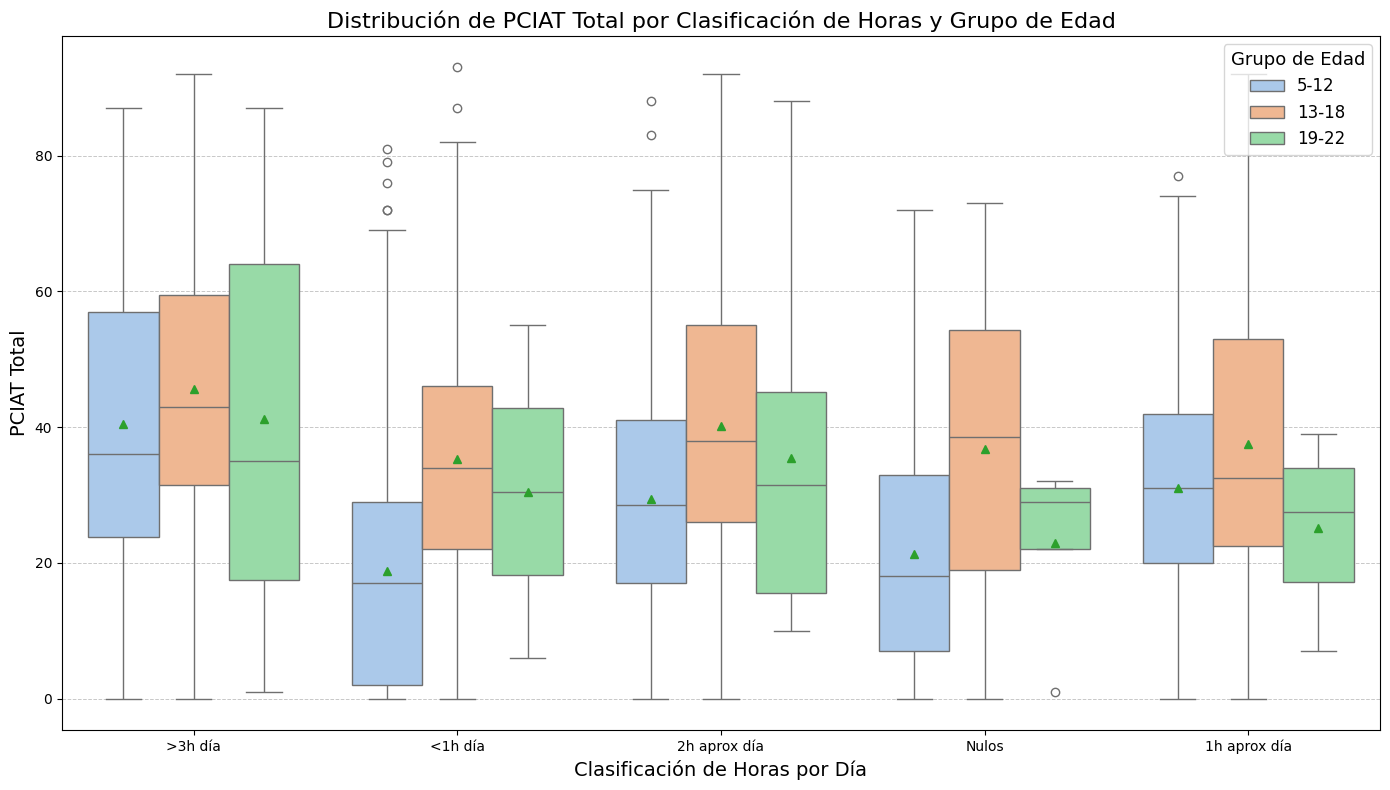

In [67]:
df_train['PreInt_EduHx-mapped'] = df_train['PreInt_EduHx-mapped'].fillna('Nulos')
plt.figure(figsize=(14, 8))

sns.boxplot(
    data=df_train,
    x='PreInt_EduHx-mapped',
    y='PCIAT-PCIAT_Total',
    hue='Edad_Rango',  
    palette="pastel",
    showmeans=True
)

plt.title('Distribución de PCIAT Total por Clasificación de Horas y Grupo de Edad', fontsize=16)
plt.xlabel('Clasificación de Horas por Día', fontsize=14)
plt.ylabel('PCIAT Total', fontsize=14)
plt.legend(title='Grupo de Edad', fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico confirma que el PCIAT Total tiende a ser más alto en quienes usan más horas de Internet, especialmente en adolescentes y jóvenes adultos. En todos los grupos de edad, aquellos que pasan más de 3 horas al día en Internet muestran las medianas más altas en PCIAT, lo que sugiere una relación entre mayor uso y posible adicción. Los niños (5-12 años) tienen valores más bajos en general, pero en los adolescentes (13-18 años) y jóvenes (19-22 años), el PCIAT es más variable y en algunos casos bastante alto, incluso en quienes usan menos horas diarias. Esto indica que, aunque el tiempo de conexión influye, otros factores también pueden estar afectando los niveles de PCIAT.

## Jose Antonio


### Estudio seasons


In [3]:
# Filtrar las columnas que contienen la palabra "Season"
season_columns = [col for col in df_train.columns if "Season" in col]

# Mostrar las columnas encontradas
print(season_columns)

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [4]:
df_train

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0     00008ff9                      Fall                5                0   
1     000fd460                    Summer                9                0   
2     00105258                    Summer               10                1   
3     00115b9f                    Winter                9                0   
4     0016bb22                    Spring               18                1   
...        ...                       ...              ...              ...   
3955  ff8a2de4                      Fall               13                0   
3956  ffa9794a                    Winter               10                0   
3957  ffcd4dbd                      Fall               11                0   
3958  ffed1dd5                    Spring               13                0   
3959  ffef538e                    Spring               11                0   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
0         Winter             51.0            Fall     16.877316   
1            NaN              NaN            Fall     14.035590   
2           Fall             71.0            Fall     16.648696   
3           Fall             71.0          Summer     18.292347   
4         Summer              NaN             NaN           NaN   
...          ...              ...             ...           ...   
3955      Spring             60.0            Fall     16.362460   
3956         NaN              NaN          Spring     18.764678   
3957      Spring             68.0          Winter     21.441500   
3958      Spring             70.0          Winter     12.235895   
3959         NaN              NaN          Winter           NaN   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
0                46.0             50.8  ...             4.0             2.0   
1                48.0             46.0  ...             0.0             0.0   
2                56.5             75.6  ...             2.0             1.0   
3                56.0             81.6  ...             3.0             4.0   
4                 NaN              NaN  ...             NaN             NaN   
...               ...              ...  ...             ...             ...   
3955             59.5             82.4  ...             1.0             1.0   
3956             53.5             76.4  ...             NaN             NaN   
3957             60.0            109.8  ...             1.0             0.0   
3958             70.7             87.0  ...             1.0             1.0   
3959              NaN              NaN  ...             NaN             NaN   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
0                4.0               55.0        NaN                NaN   
1                0.0                0.0       Fall               46.0   
2                1.0               28.0       Fall               38.0   
3                1.0               44.0     Summer               31.0   
4                NaN                NaN        NaN                NaN   
...              ...                ...        ...                ...   
3955             0.0               32.0     Winter               35.0   
3956             NaN                NaN        NaN                NaN   
3957             1.0               31.0     Winter               56.0   
3958             1.0               19.0     Spring               33.0   
3959             NaN                NaN        NaN                NaN   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
0                 NaN                 Fall   
1                64.0               Summer   
2                54.0               Summer   
3                45.0               Winter   
4                 NaN                  NaN   
...               ...                  ...   
3955             50.0                 Fall   
3956              NaN               Winter   
3957             77.0         

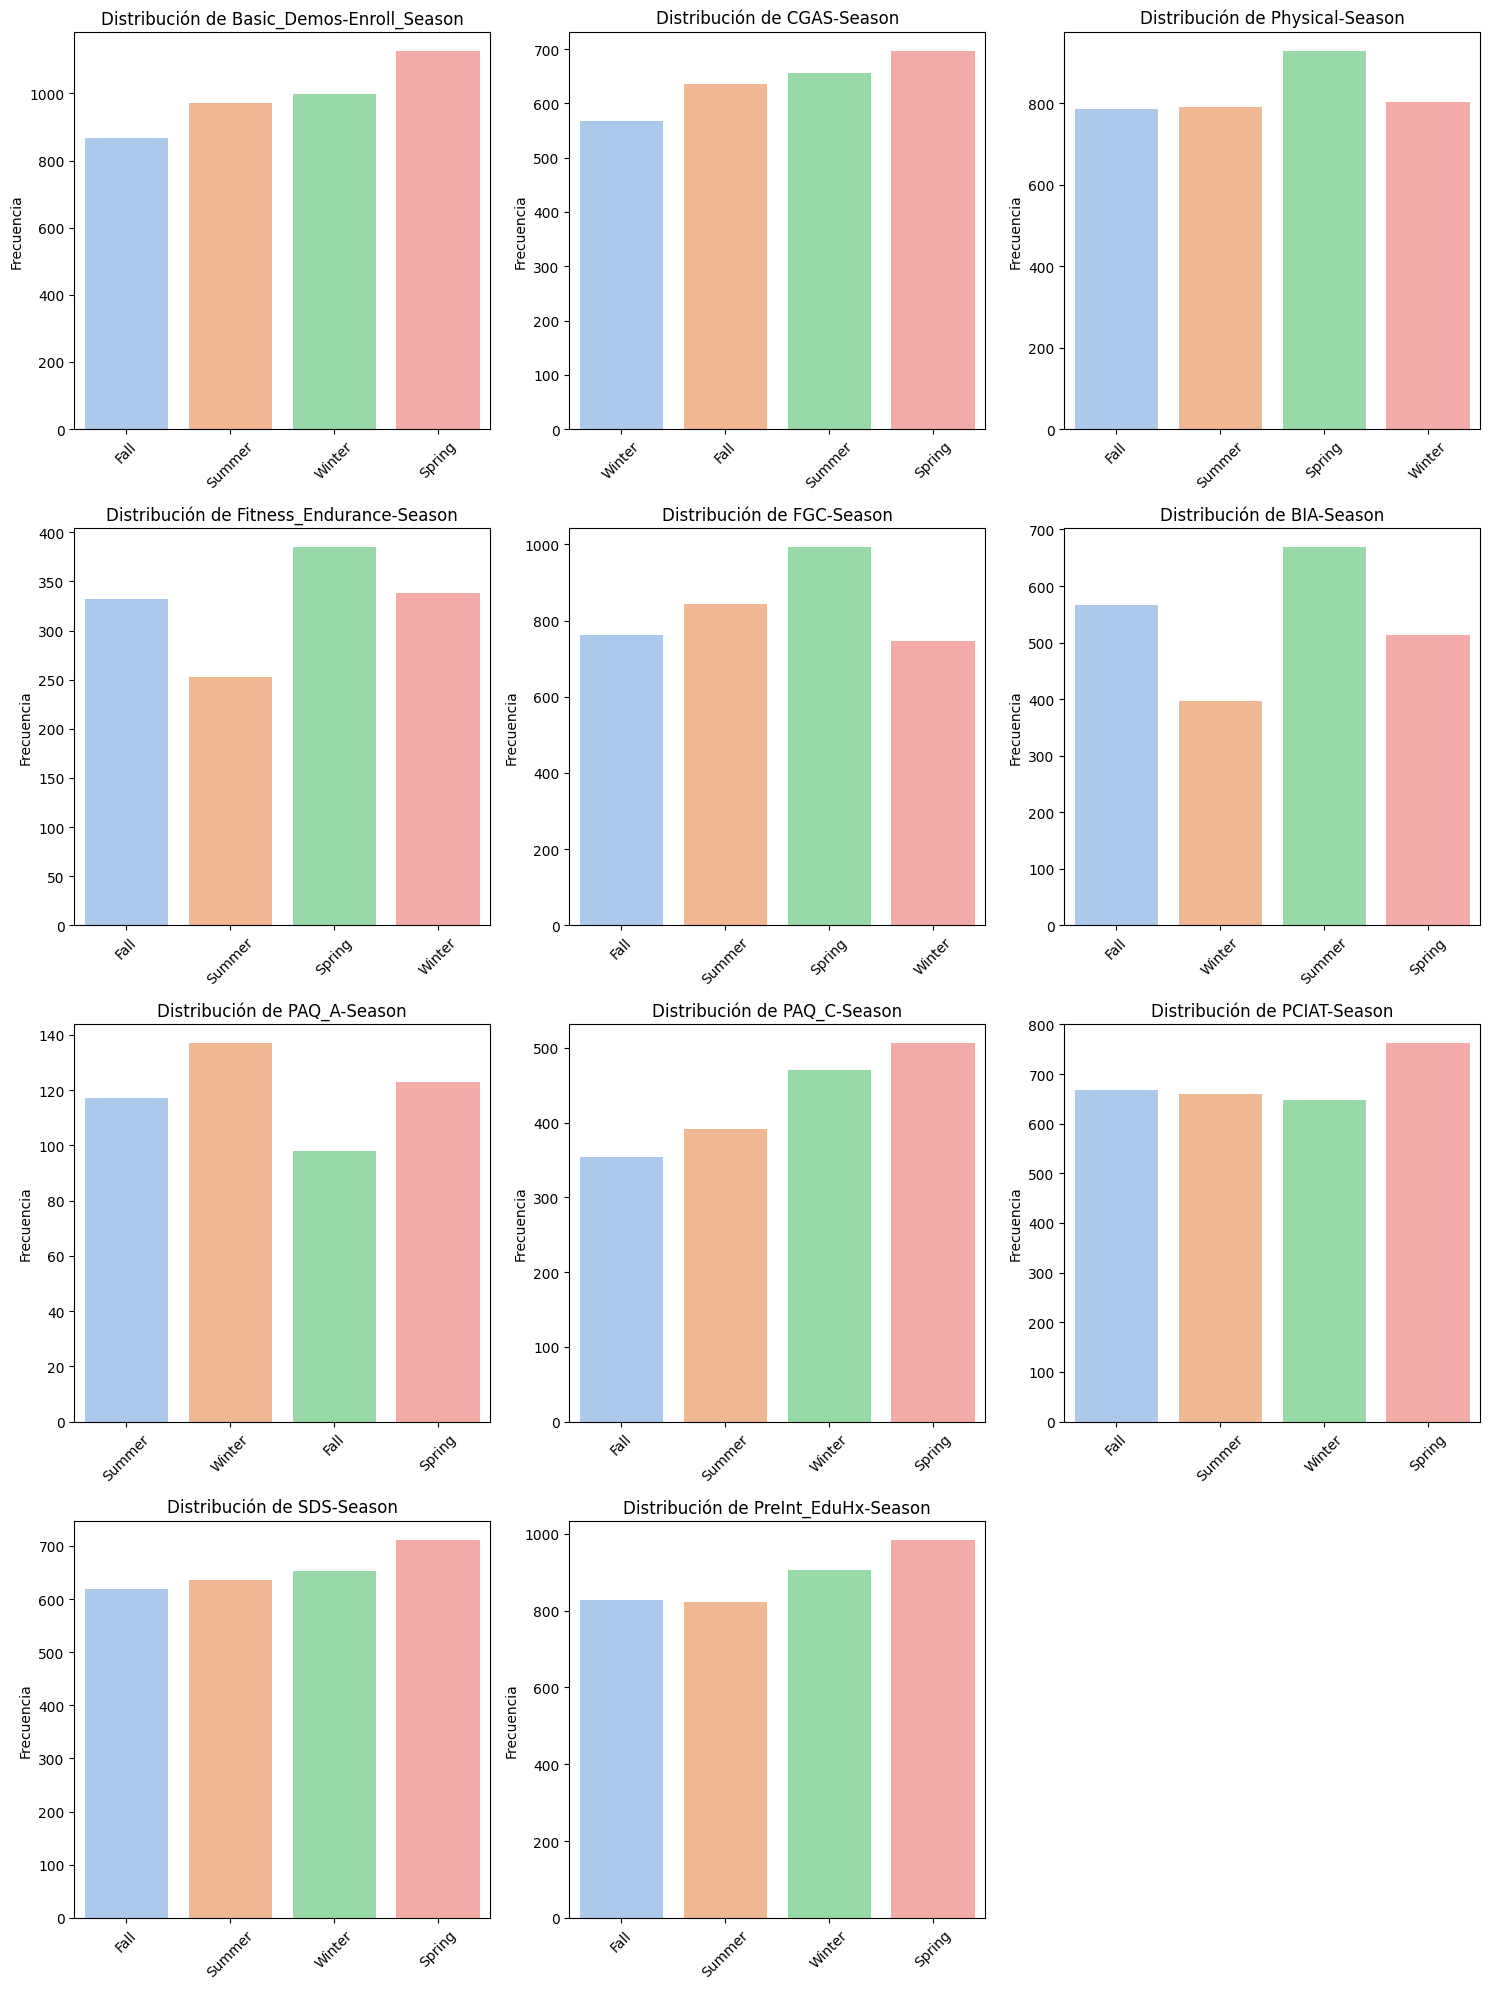

In [10]:
import math

num_cols = len(season_columns)
num_rows = math.ceil(num_cols / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, col in enumerate(season_columns):
    sns.countplot(x=df_train[col], hue=df_train[col], legend=False, ax=axes[i], palette="pastel")
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Distribución desigual entre estaciones:

    * Algunas pruebas parecen realizarse más en ciertas estaciones. Por ejemplo, el Fitness_Endurance-Season y Physical-Season pueden concentrarse más en verano y otoño, mientras que otras pruebas como SDS-Season y PCIAT-Season tienen distribuciones más uniformes.
    * Esto podría estar relacionado con el tipo de evaluación: algunas pueden depender del clima o del calendario escolar.

* Algunas estaciones dominan ciertos instrumentos:

    * En varios gráficos, se nota que una estación es más frecuente que las demás, lo que sugiere que ciertas pruebas tienen una época del año predeterminada para ser realizadas.
    * Esto puede indicar una estrategia de planificación en la recolección de datos.

* Presencia de datos faltantes o distribución sesgada:

    * En categorías con muy pocos datos, puede significar que ciertos instrumentos no se aplicaron en todas las estaciones o que hay registros incompletos.

In [11]:
tables = {}

for col in season_columns:
    tables[col] = df_train[col].value_counts().reset_index()
    tables[col].columns = ["Estación", "Frecuencia"]

for col, table in tables.items():
    print(f"\nTabla de Frecuencia para {col}")
    print(table)
    print("-" * 40)


Tabla de Frecuencia para Basic_Demos-Enroll_Season
  Estación  Frecuencia
0   Spring        1127
1   Winter         997
2   Summer         970
3     Fall         866
----------------------------------------

Tabla de Frecuencia para CGAS-Season
  Estación  Frecuencia
0   Spring         697
1   Summer         656
2     Fall         635
3   Winter         567
----------------------------------------

Tabla de Frecuencia para Physical-Season
  Estación  Frecuencia
0   Spring         929
1   Winter         804
2   Summer         791
3     Fall         786
----------------------------------------

Tabla de Frecuencia para Fitness_Endurance-Season
  Estación  Frecuencia
0   Spring         385
1   Winter         338
2     Fall         332
3   Summer         253
----------------------------------------

Tabla de Frecuencia para FGC-Season
  Estación  Frecuencia
0   Spring         993
1   Summer         844
2     Fall         763
3   Winter         746
----------------------------------------


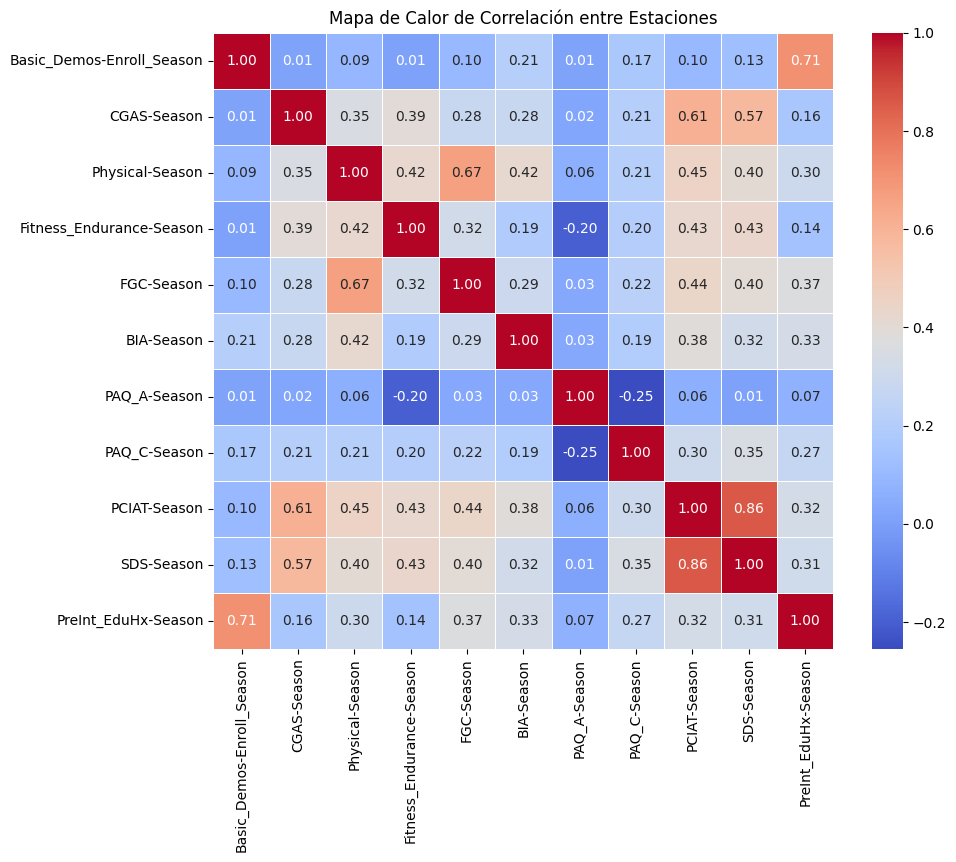

In [12]:
season_encoded = df_train[season_columns].apply(lambda x: pd.factorize(x)[0])

corr_matrix = season_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlación entre Estaciones")
plt.show()

* Alta correlación entre "PCIAI-Season" y "SDS-Season" (0.86)
Esto indica que cuando se realizan pruebas de PCIAT en una estación, también es muy probable que se realicen pruebas de SDS en la misma época. Puede deberse a que ambos instrumentos se aplican en conjunto en ciertos estudios o tienen una relación lógica en el contexto de la investigación.

* "Basic_Demos-Enroll_Season" y "Prelnt_EduHx-Season" tienen una correlación fuerte (0.71)
Esto sugiere que la época en la que se recolectan datos demográficos básicos coincide con la época en la que se evalúan los antecedentes educativos de los participantes. Es posible que estos dos aspectos sean parte de la misma fase inicial de la investigación.

* Correlación moderada entre "FGC-Season" y "Physical-Season" (0.67)
Indica que las pruebas físicas y las pruebas FGC tienden a realizarse juntas en las mismas estaciones, lo que podría estar relacionado con protocolos específicos de evaluación.

* Baja correlación entre "PAQ_A-Season" y otras estaciones (valores cercanos a 0 o negativos)
Esto sugiere que la recolección de datos de PAQ_A no sigue un patrón estacional definido y puede realizarse de manera más aleatoria a lo largo del año.

* "CGAS-Season" tiene una correlación significativa con "PCIAI-Season" (0.61)
Esto indica que las evaluaciones de CGAS suelen realizarse en la misma época que las de PCIAI, lo que podría deberse a que ambos instrumentos se aplican en la misma fase del estudio.

In [5]:
#Winter → 0 rad (corresponde a cos = 1, sin = 0)
#Spring → π/2 rad (corresponde a cos = 0, sin = 1)
#Summer → π rad (corresponde a cos = -1, sin = 0)
#Fall → 3π/2 rad (corresponde a cos = 0, sin = -1)

season_order = ['Winter', 'Spring', 'Summer', 'Fall']

season_to_angle = {season: i * (np.pi / 2) for i, season in enumerate(season_order)}

for col in season_columns:
    df_train[f'{col}_sin'] = df_train[col].map(season_to_angle).apply(lambda x: int(np.round(np.sin(x))) if pd.notna(x) else np.nan)
    df_train[f'{col}_cos'] = df_train[col].map(season_to_angle).apply(lambda x: int(np.round(np.cos(x))) if pd.notna(x) else np.nan)

# Mostrar las nuevas columnas transformadas
df_train[[col for col in df_train.columns if '_sin' in col or '_cos' in col]].head()



Basic_Demos-Enroll_Season_sin  Basic_Demos-Enroll_Season_cos  \
0                             -1                              0   
1                              0                             -1   
2                              0                             -1   
3                              0                              1   
4                              1                              0   

   CGAS-Season_sin  CGAS-Season_cos  Physical-Season_sin  Physical-Season_cos  \
0              0.0              1.0                 -1.0                  0.0   
1              NaN              NaN                 -1.0                  0.0   
2             -1.0              0.0                 -1.0                  0.0   
3             -1.0              0.0                  0.0                 -1.0   
4              0.0             -1.0                  NaN                  NaN   

   Fitness_Endurance-Season_sin  Fitness_Endurance-Season_cos  FGC-Season_sin  \
0                           NaN                           NaN            -1.0   
1                           NaN                           NaN            -1.0   
2                          -1.0                           0.0            -1.0   
3                           0.0                          -1.0             0.0   
4                           NaN                           NaN             NaN   

   FGC-Season_cos  ...  PAQ_A-Season_sin  PAQ_A-Season_cos  PAQ_C-Season_sin  \
0             0.0  ...               NaN               NaN               NaN   
1             0.0  ...               NaN               NaN              -1.0   
2             0.0  ...               NaN               NaN               0.0   
3            -1.0  ...               NaN               NaN               0.0   
4             NaN  ...               0.0              -1.0               NaN   

   PAQ_C-Season_cos  PCIAT-Season_sin  PCIAT-Season_cos  SDS-Season_sin  \
0               NaN              -1.0               0.0             NaN   
1               0.0              -1.0               0.0            -1.0   
2              -1.0              -1.0               0.0            -1.0   
3               1.0               0.0              -1.0             0.0   
4               NaN               NaN               NaN             NaN   

   SDS-Season_cos  PreInt_EduHx-Season_sin  PreInt_EduHx-Season_cos  
0             NaN                     -1.0                      0.0  
1             0.0                      0.0                     -1.0  
2             0.0                      0.0                     -1.0  
3            -1.0                      0.0                      1.0  
4             NaN                      NaN                      NaN  

[5 rows x 22 columns]

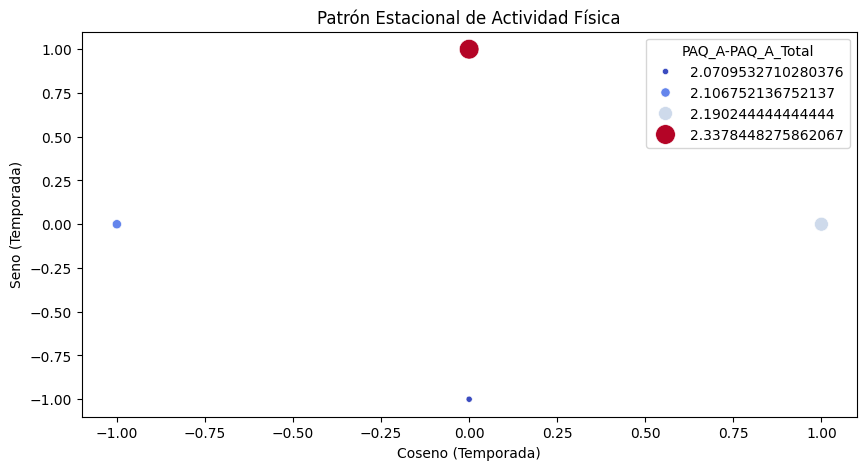

In [ ]:
# Promediar la variable objetivo según las estaciones en su representación circular
df_season_avg = df_train.groupby(['Basic_Demos-Enroll_Season_sin', 'Basic_Demos-Enroll_Season_cos'])['PAQ_A-PAQ_A_Total'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_season_avg, x='Basic_Demos-Enroll_Season_cos', y='Basic_Demos-Enroll_Season_sin', size='PAQ_A-PAQ_A_Total', hue='PAQ_A-PAQ_A_Total', palette='coolwarm', sizes=(20, 200))
plt.xlabel("Coseno (Temporada)")
plt.ylabel("Seno (Temporada)")
plt.title("Patrón Estacional de Actividad Física")
plt.show()

Este gráfico muestra cómo varía la actividad física a lo largo del año usando coordenadas seno y coseno para representar las estaciones.

* Más actividad en Primavera y Verano → El punto más grande y rojo en la parte superior indica que la gente se mueve más en esta época.
* Menos actividad en Otoño e Invierno → En estas estaciones la actividad cae bastante, lo que puede deberse al clima.
* Tendencia clara → La gente es más activa cuando hace mejor tiempo, lo que tiene sentido.

In [8]:
print(df_train.columns)

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight',
       ...
       'PAQ_A-Season_sin', 'PAQ_A-Season_cos', 'PAQ_C-Season_sin',
       'PAQ_C-Season_cos', 'PCIAT-Season_sin', 'PCIAT-Season_cos',
       'SDS-Season_sin', 'SDS-Season_cos', 'PreInt_EduHx-Season_sin',
       'PreInt_EduHx-Season_cos'],
      dtype='object', length=104)


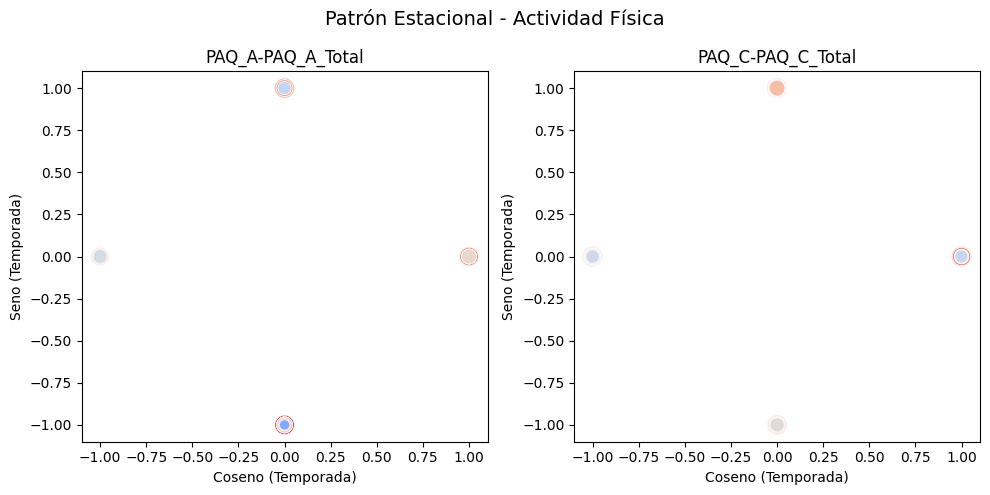

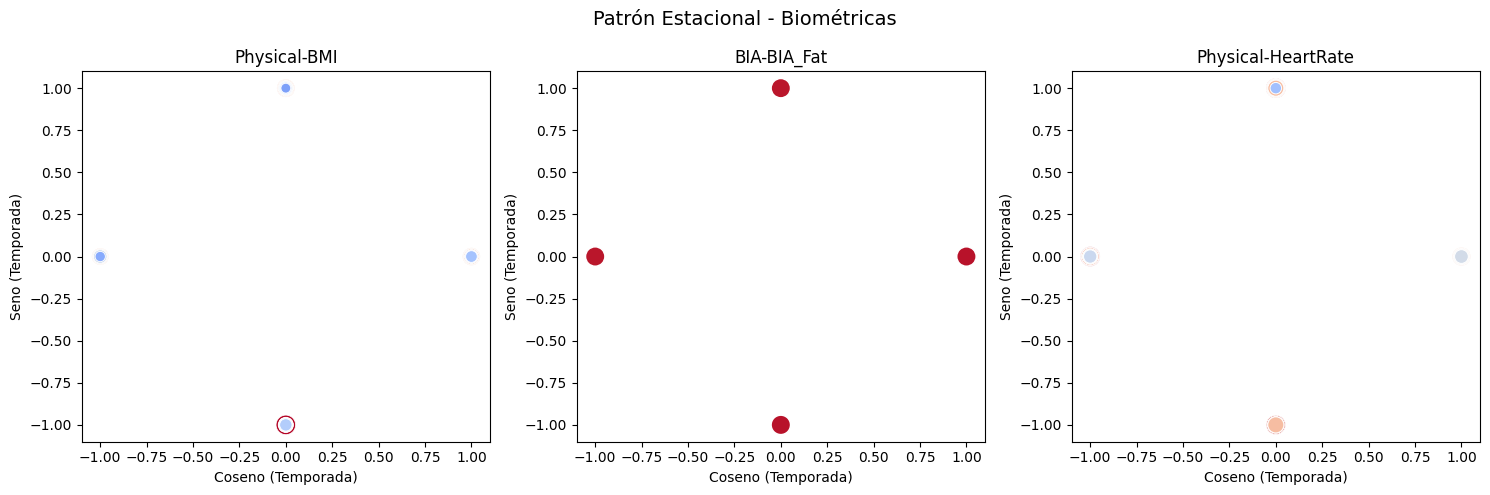

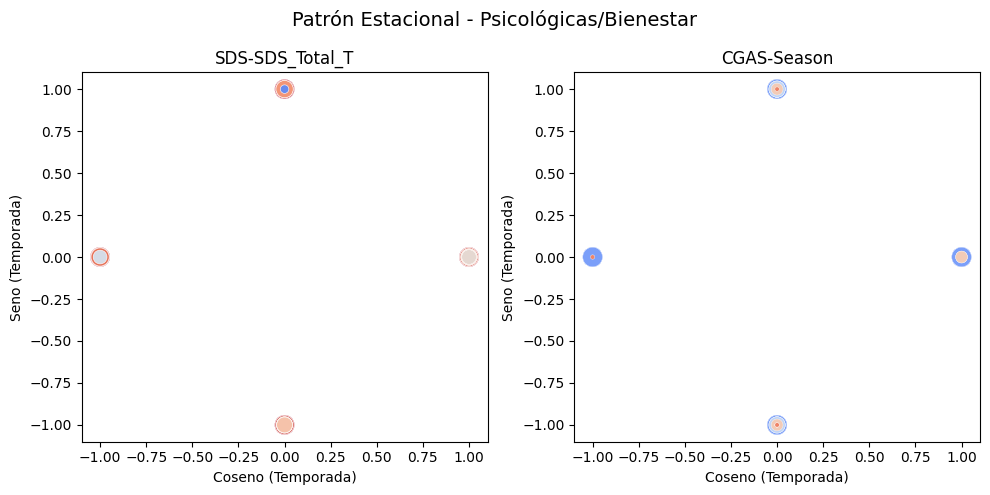

In [ ]:
actividad_fisica = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']
biometricas = ['Physical-BMI', 'BIA-BIA_Fat', 'Physical-HeartRate']
psicologicas = ['SDS-SDS_Total_T', 'CGAS-Season']

categorias = {
    'Actividad Física': actividad_fisica,
    'Biométricas': biometricas,
    'Psicológicas/Bienestar': psicologicas
}

season_col = 'Basic_Demos-Enroll_Season'

for categoria, variables in categorias.items():
    fig, axes = plt.subplots(1, len(variables), figsize=(len(variables) * 5, 5))
    fig.suptitle(f'Patrón Estacional - {categoria}', fontsize=14)
    
    if len(variables) == 1:
        axes = [axes]  
    
    for ax, var in zip(axes, variables):
        if var in df_train.columns:  
            sns.scatterplot(
                data=df_train,
                x=f'{season_col}_cos', y=f'{season_col}_sin', 
                size=var, hue=var, 
                palette='coolwarm', sizes=(10, 200), ax=ax, legend=False
            )
            ax.set_title(var)
            ax.set_xlabel("Coseno (Temporada)")
            ax.set_ylabel("Seno (Temporada)")
        else:
            ax.set_title(f"⚠️ {var} no existe en df_train")

    plt.tight_layout()
    plt.show()


Actividad Física

* En cuanto a PAQ_A y PAQ_C (actividad física auto-reportada), los valores más altos se concentran en invierno y verano, lo que sugiere que la actividad física puede fluctuar con la temporada, quizás más en vacaciones o cuando las condiciones climáticas son más extremas.

Variables Biométricas

* No parece haber una estación donde el BMI cambie drásticamente, lo que indica estabilidad en esta variable a lo largo del año.
* En cuanto a el Porcentaje de Grasa Corporal (BIA_Fat), se observa un patrón en invierno y verano con valores más altos, lo que podría relacionarse con cambios en la alimentación o actividad física según la estación.
* La Frecuencia Cardíaca (HeartRate) parece más alta en invierno y otoño, lo que podría estar vinculado a menor actividad física o condiciones ambientales.

Bienestar Psicológico

* SDS (Escala de Depresión): Los puntajes más altos aparecen en invierno y otoño, lo cual concuerda con la idea de que estos meses pueden afectar el estado de ánimo.
* CGAS (Funcionalidad Global): No hay una estacionalidad muy marcada, aunque en invierno y verano se observan algunos valores más extremos.

Parece haber patrones estacionales en la actividad física y algunas variables biométricas y psicológicas. La actividad física y la grasa corporal pueden cambiar con la estación, y el bienestar psicológico muestra posibles efectos estacionales, especialmente en invierno. Esto refuerza la idea de que el clima y la rutina influyen en la salud y el comportamiento de las personas

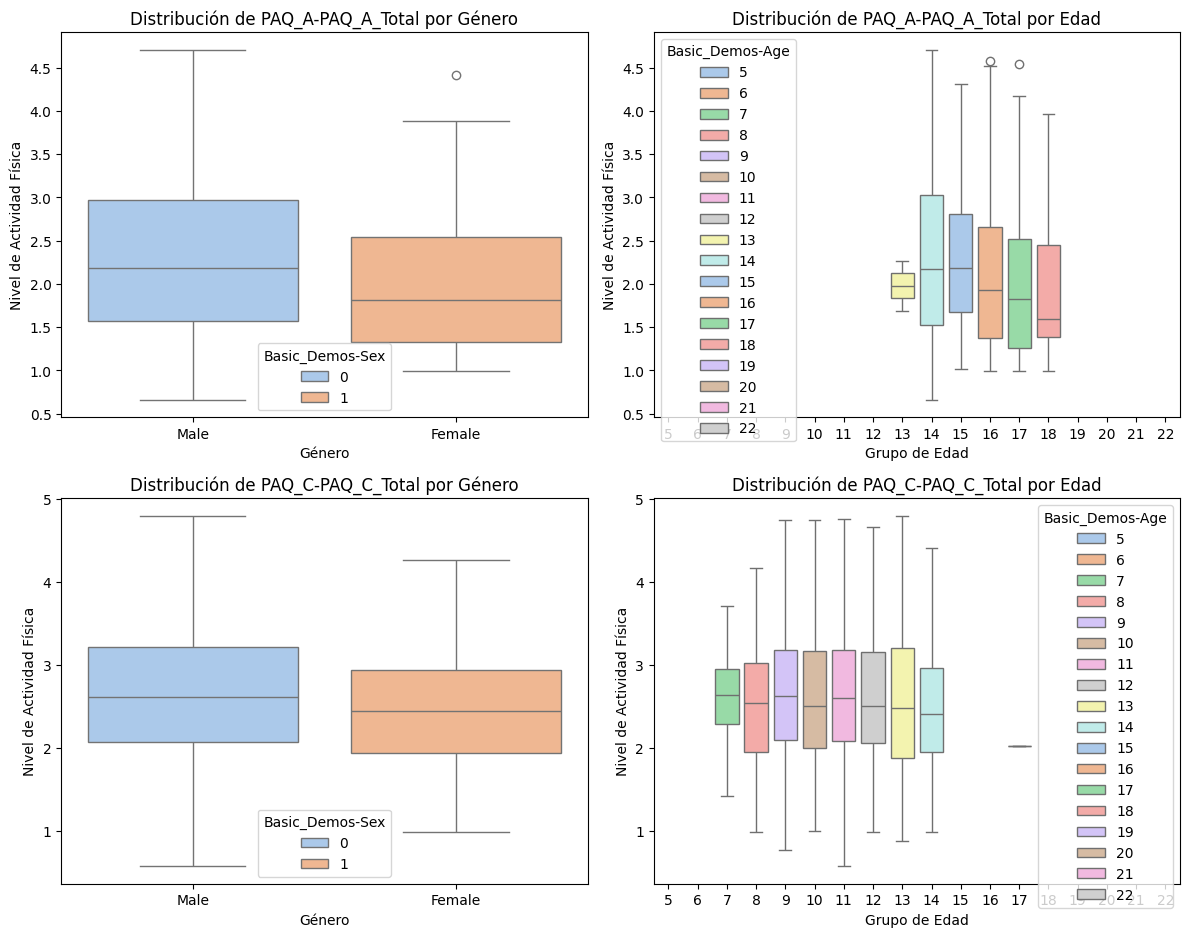

In [18]:
actividad_fisica = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']

fig, axes = plt.subplots(len(actividad_fisica), 2, figsize=(12, len(actividad_fisica) * 5))

gender_mapping = {0: 'Male', 1: 'Female'}

def map_gender(value):
    return gender_mapping.get(value, value)

for i, var in enumerate(actividad_fisica):
    # Por género
    sns.boxplot(x=df_train['Basic_Demos-Sex'].map(map_gender), y=var,hue="Basic_Demos-Sex", data=df_train, ax=axes[i, 0], palette="pastel")
    axes[i, 0].set_title(f'Distribución de {var} por Género')
    axes[i, 0].set_xlabel('Género')
    axes[i, 0].set_ylabel('Nivel de Actividad Física')
    
    # Por edad
    sns.boxplot(x='Basic_Demos-Age', y=var,hue="Basic_Demos-Age", data=df_train, ax=axes[i, 1], palette="pastel")
    axes[i, 1].set_title(f'Distribución de {var} por Edad')
    axes[i, 1].set_xlabel('Grupo de Edad')
    axes[i, 1].set_ylabel('Nivel de Actividad Física')

plt.tight_layout()
plt.show()



Diferencias por Género

No hay una diferencia clara entre hombres y mujeres en cuanto a actividad física. Ambos géneros tienen una distribución similar en sus niveles de actividad.
La dispersión de los datos sugiere que hay individuos de ambos géneros con niveles muy altos y muy bajos de actividad.

Diferencias por Edad

* Mayor actividad física en adolescentes: A partir de los 13-14 años hay más variabilidad en los niveles de actividad, lo que sugiere que algunos grupos de edad hacen más ejercicio que otros.
* Dispersión alta en edades tempranas y tardías: En niños más pequeños y mayores de 18 años, la actividad física parece más variable, con algunos individuos muy activos y otros con niveles bajos.
No hay una tendencia clara de aumento o disminución con la edad, aunque la actividad parece más consistente en la adolescencia.

El género no parece ser un factor determinante en la actividad física, ya que los niveles son similares en hombres y mujeres.
La edad influye más, con mayor variabilidad en la adolescencia, posiblemente debido a la escolarización, actividades deportivas o hábitos de vida.

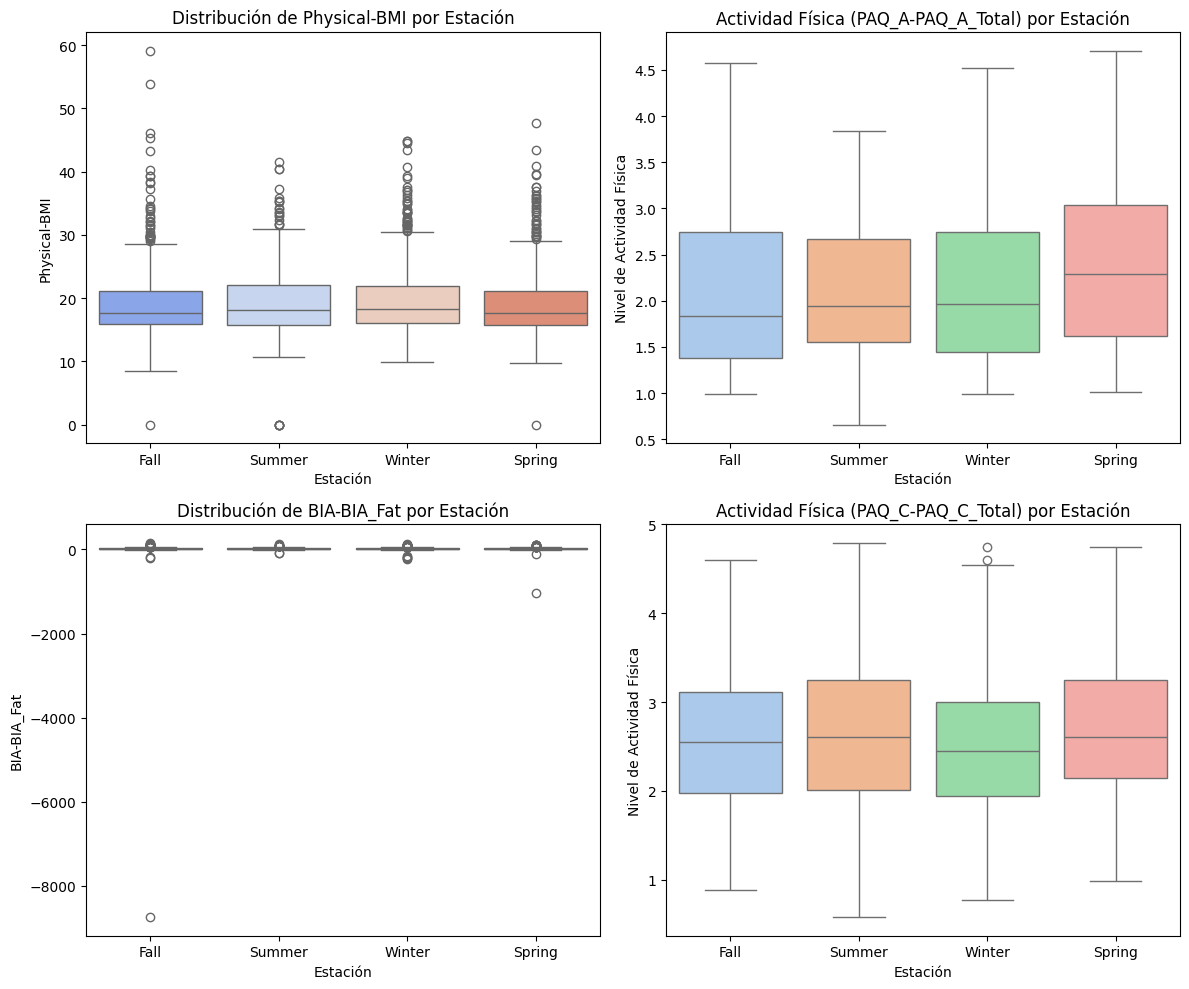

In [ ]:
imc_vars = ['Physical-BMI', 'BIA-BIA_Fat']
actividad_fisica = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']

fig, axes = plt.subplots(len(imc_vars), 2, figsize=(12, len(imc_vars) * 5))

for i, var in enumerate(imc_vars):
    sns.boxplot(x='Basic_Demos-Enroll_Season', y=var,hue="Basic_Demos-Enroll_Season", data=df_train, ax=axes[i, 0], palette="coolwarm")
    axes[i, 0].set_title(f'Distribución de {var} por Estación')
    axes[i, 0].set_xlabel('Estación')
    axes[i, 0].set_ylabel(var)
    
    sns.boxplot(x='Basic_Demos-Enroll_Season', y=actividad_fisica[i], hue="Basic_Demos-Enroll_Season", data=df_train, ax=axes[i, 1], palette="pastel")
    axes[i, 1].set_title(f'Actividad Física ({actividad_fisica[i]}) por Estación')
    axes[i, 1].set_xlabel('Estación')
    axes[i, 1].set_ylabel('Nivel de Actividad Física')

plt.tight_layout()
plt.show()


IMC por estación (arriba izquierda)

* No hay variaciones drásticas en el IMC según la estación. Una distribución bastante estable, con valores atípicos en todas las estaciones.
* Se observa una ligera tendencia a valores más bajos en invierno y primavera.

Porcentaje de grasa corporal (abajo izquierda)

* Exceptuando los outliers, la distribución parece bastante estable a lo largo de las estaciones.

Actividad física (PAQ_A-PAQ_A_Total) por estación (arriba derecha)

* La actividad física es similar en todas las estaciones, sin cambios bruscos.

4Actividad física (PAQ_C-PAQ_C_Total) por estación (abajo derecha)

* No hay indicios claros de que las personas reduzcan o aumenten actividad física en invierno o verano.

En general no se observa una relación clara entre IMC, actividad física y estaciones. A excepción de la posible variabilidad en primavera, los datos sugieren que la actividad física y el IMC se mantienen relativamente estables a lo largo del año.

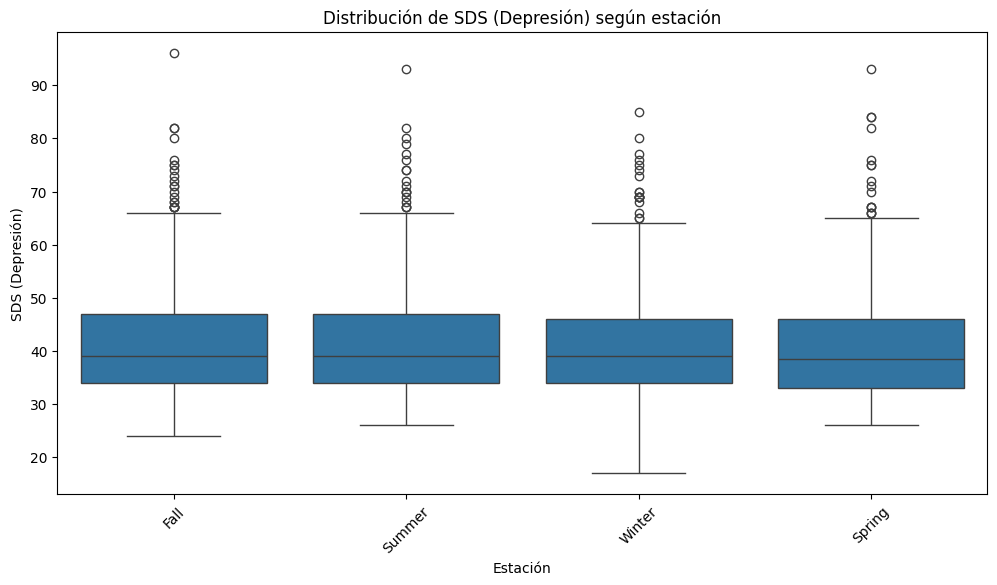

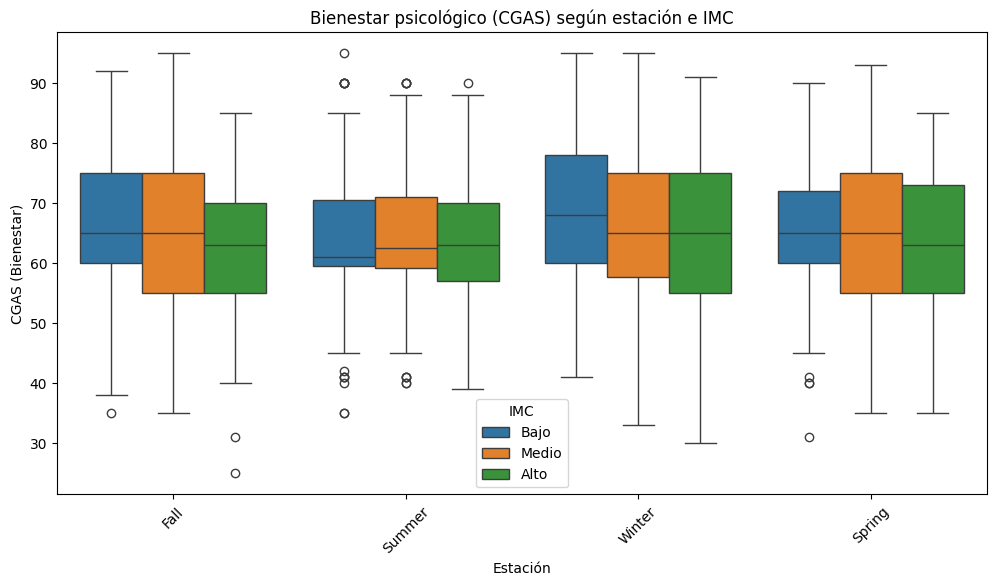

In [22]:
sds_column = "SDS-SDS_Total_Raw"
cgas_column = "CGAS-CGAS_Score"
imc_column = "Physical-BMI"
season_columns = [col for col in df_train.columns if "Season" in col and "_sin" not in col and "_cos" not in col]

df_train[sds_column] = pd.to_numeric(df_train[sds_column], errors='coerce')
df_train[cgas_column] = pd.to_numeric(df_train[cgas_column], errors='coerce')
df_train[imc_column] = pd.to_numeric(df_train[imc_column], errors='coerce')

# Análisis de SDS según estación
if season_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_train[season_columns[0]], y=df_train[sds_column])
    plt.title('Distribución de SDS (Depresión) según estación')
    plt.xlabel('Estación')
    plt.ylabel('SDS (Depresión)')
    plt.xticks(rotation=45)
    plt.show()

# Análisis de bienestar según IMC y estación
if season_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_train[season_columns[0]], y=df_train[cgas_column], hue=pd.qcut(df_train[imc_column], q=3, labels=['Bajo', 'Medio', 'Alto']))
    plt.title('Bienestar psicológico (CGAS) según estación e IMC')
    plt.xlabel('Estación')
    plt.ylabel('CGAS (Bienestar)')
    plt.legend(title='IMC')
    plt.xticks(rotation=45)
    plt.show()


1. No parece haber un patrón estacional en la depresión
2. El bienestar psicológico parece estar más relacionado con el IMC que con la estación del año. Personas con IMC más alto pueden tener un bienestar ligeramente menor.


## Santiago


### Distribuciones de las variables

In [68]:
def pciat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-BMI
    """
    COLUMNS = "PCIAT-PCIAT_Total"
    # Esta es la excepcion, asumimos que esta correcto y no quitamos "outliers"
    data = [df[COLUMNS] for df in dfs.values()]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("PCIAT-PCIAT_Total")


compare_functions.append(pciat)


def bmi(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-BMI
    """
    COLUMNS = "Physical-BMI"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-BMI")


compare_functions.append(bmi)


def fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo BIA-BIA_Fat
    """

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    COLUMNS = ["BIA-BIA_FFM", "BIA-BIA_Fat"]
    data = [filter_outliers(df, COLUMNS) for df in dfs.values()]
    data = [compose_values(df[COLUMNS]) for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Fat %")


compare_functions.append(fat)


def bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo BIA-BIA_BMC
    """
    COLUMNS = "BIA-BIA_BMC"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("BMC")


compare_functions.append(bone)


def bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-HeartRate
    """
    COLUMNS = "Physical-HeartRate"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-HeartRate")


compare_functions.append(bpm)


def systolic(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas de violines para todos los Dataframes en
    la misma grafica diferenciados por colores comparando el campo Physical-Systolic_BP
    """
    COLUMNS = "Physical-Systolic_BP"
    data = [filter_outliers(df, [COLUMNS]) for df in dfs.values()]
    data = [df[COLUMNS] for df in data]

    quantiles = [[0.25, 0.5, 0.75] for _ in range(len(data))]
    parts = ax.violinplot(data, showmeans=True, quantiles=quantiles)
    quantile = parts["cquantiles"]
    quantile.set_linestyle("--")

    center = parts["cbars"]
    center.set_linewidth(0.5)

    mean = parts["cmeans"]
    mean.set_edgecolor("yellow")
    mean.set_label("Mean")

    ax.set_xticks(range(1, len(dfs) + 1))
    ax.set_xticklabels(dfs.keys())
    ax.set_ylabel("Physical-Systolic_BP")


compare_functions.append(systolic)


### Correlaciones entre variables

In [69]:
def bmi_bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y Phisical-HeartRate
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "Physical-HeartRate"])
        ax.scatter(
            data["Physical-BMI"],
            data["Physical-HeartRate"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("Physical-HeartRate")
    ax.legend()


compare_functions.append(bmi_bpm)


def bmi_systolic(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-Systolic_BP and BIA-BIA_BMI
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-Systolic_BP", "BIA-BIA_BMI"])
        ax.scatter(
            data["BIA-BIA_BMI"],
            data["Physical-Systolic_BP"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_BMI")
    ax.set_ylabel("Physical-Systolic")
    ax.legend()


compare_functions.append(bmi_systolic)


def bmi_fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            data["Physical-BMI"],
            compose_values(data),
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("BIA-BIA_Fat")
    ax.legend()


compare_functions.append(bmi_fat)


def fat_bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-HeartRate y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-HeartRate", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            compose_values(data),
            data["Physical-HeartRate"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_Fat")
    ax.set_ylabel("Physical-HeartRate")
    ax.legend()


compare_functions.append(fat_bpm)


def fat_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["BIA-BIA_BMC", "BIA-BIA_Fat", "BIA-BIA_FFM"])
        ax.scatter(
            compose_values(data),
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("BIA-BIA_Fat")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(fat_bone)


def bpm_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y Physical-HeartRate
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-HeartRate", "BIA-BIA_BMC"])
        ax.scatter(
            data["Physical-HeartRate"],
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-HeartRate")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(bpm_bone)


def bmi_bone(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos BIA-BIA_BMC y Physical-BMI
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        data = filter_outliers(df, ["Physical-BMI", "BIA-BIA_BMC"])
        ax.scatter(
            data["Physical-BMI"],
            data["BIA-BIA_BMC"],
            label=name,
            color=colormap(i),
        )

    ax.set_xlabel("Physical-BMI")
    ax.set_ylabel("BIA-BIA_BMC")
    ax.legend()


compare_functions.append(bmi_bone)


## Ejecucion de redes


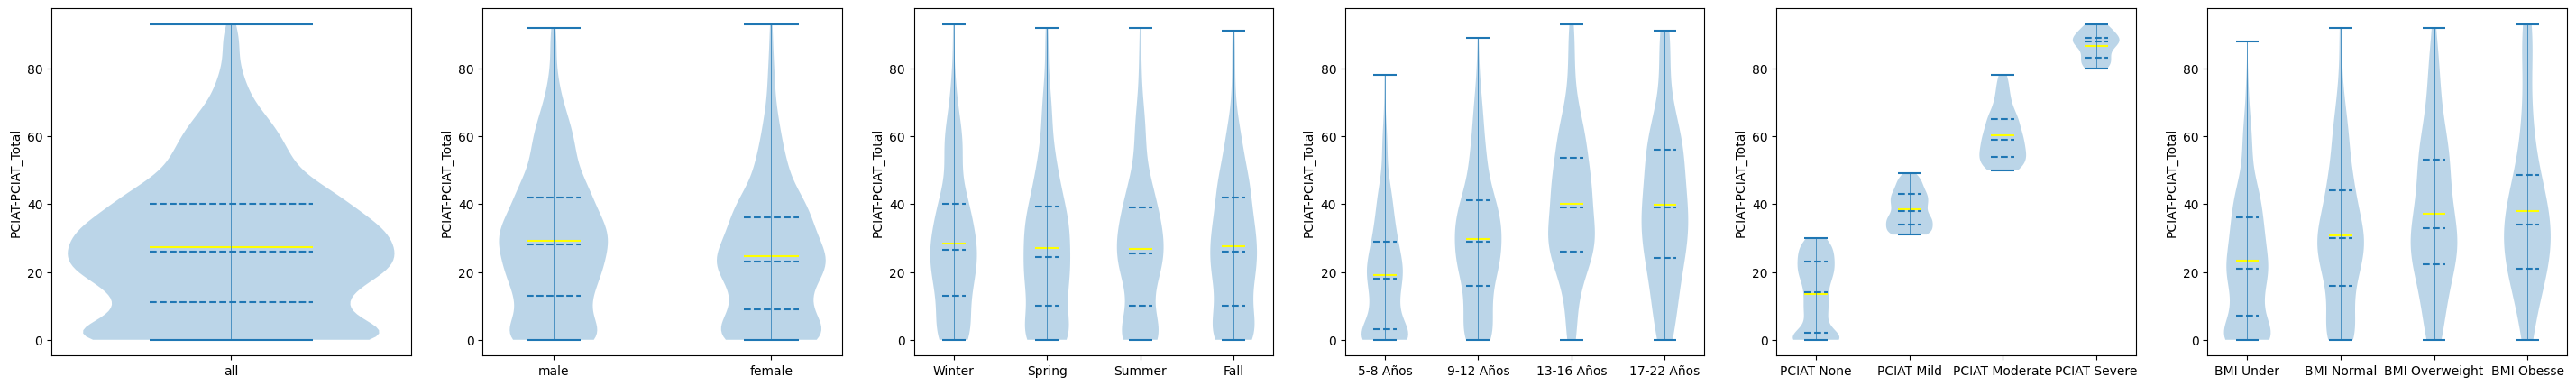

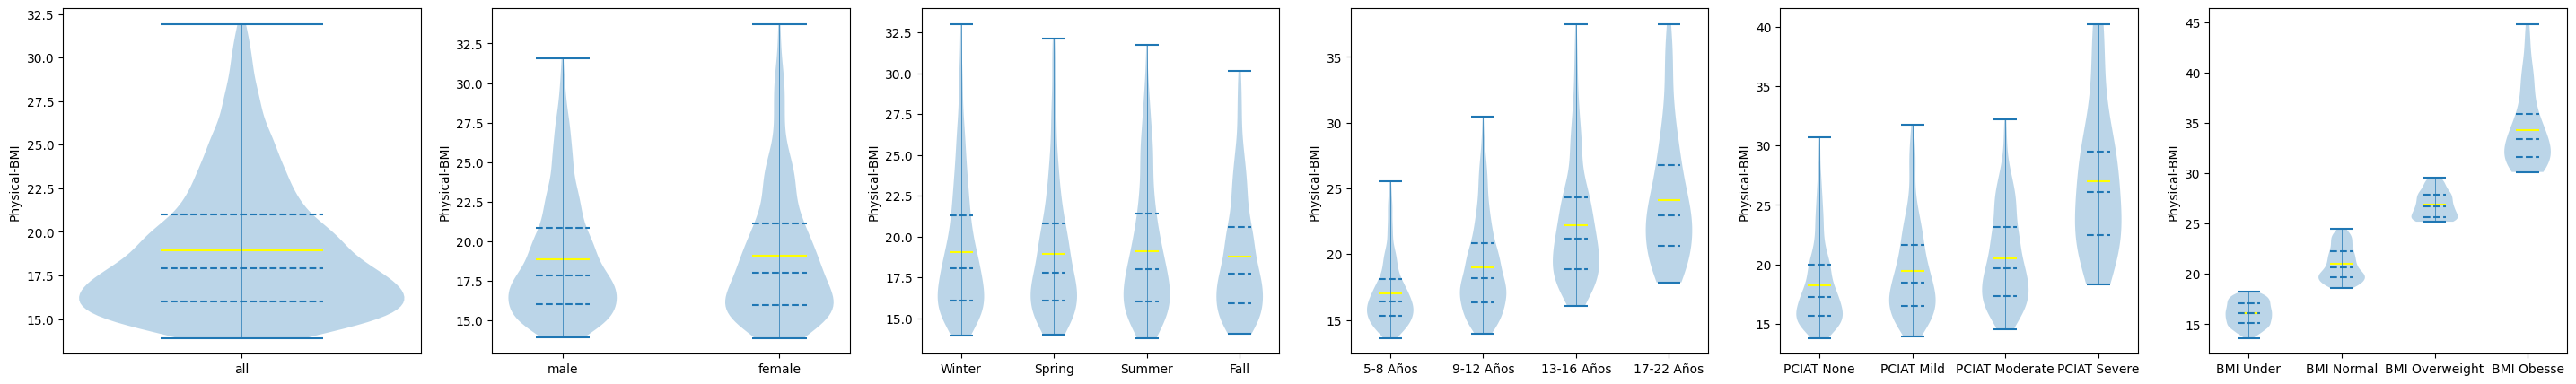

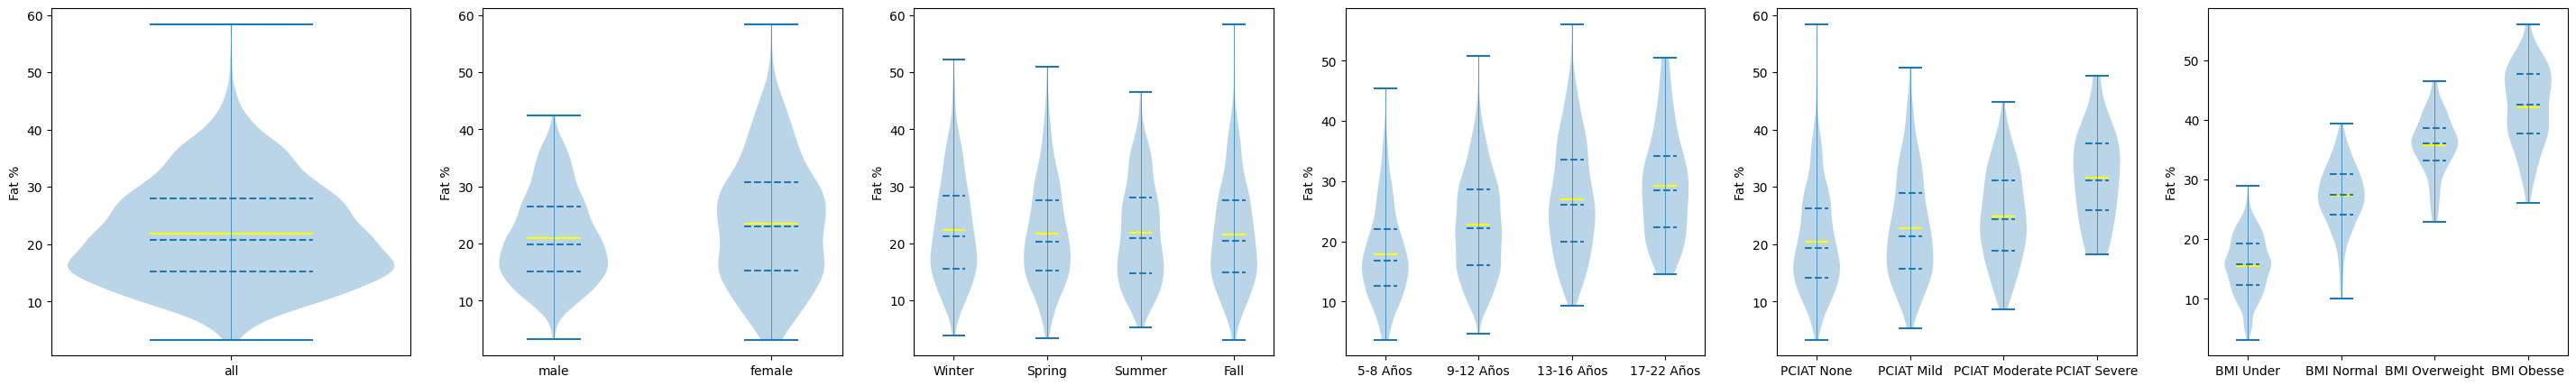

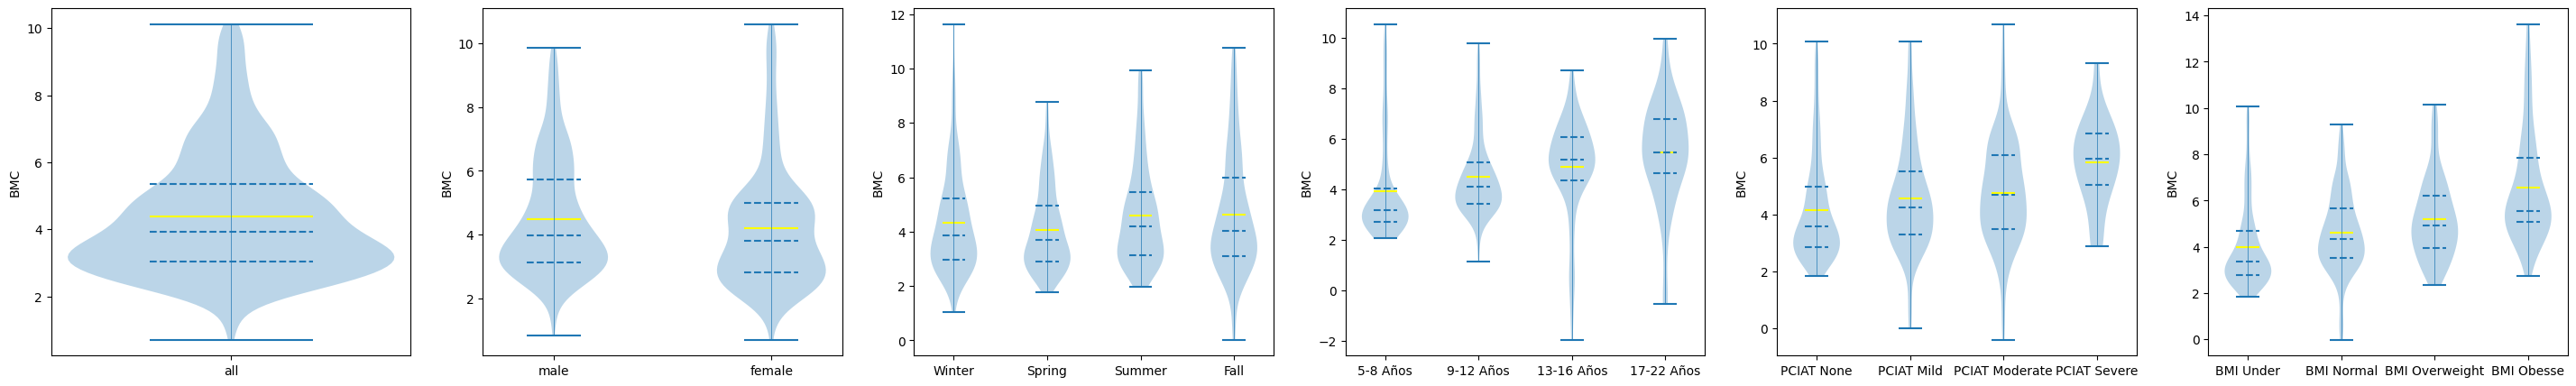

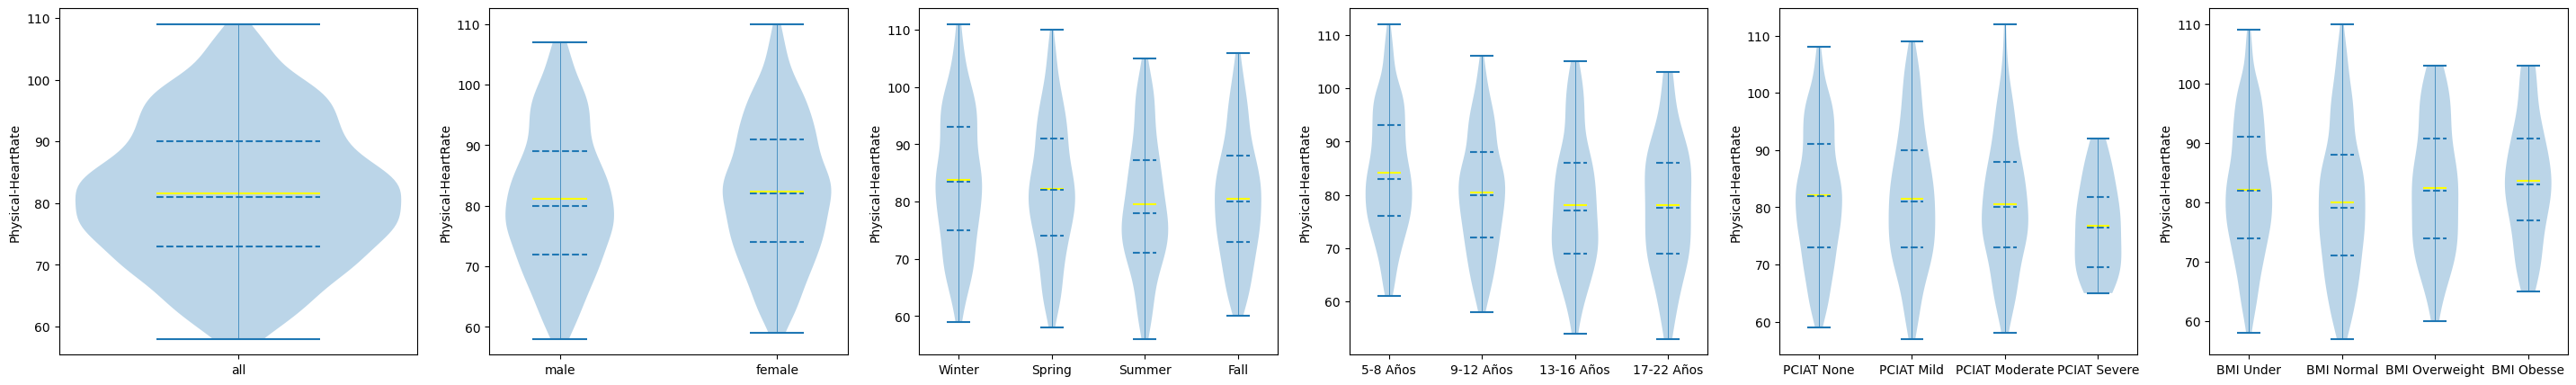

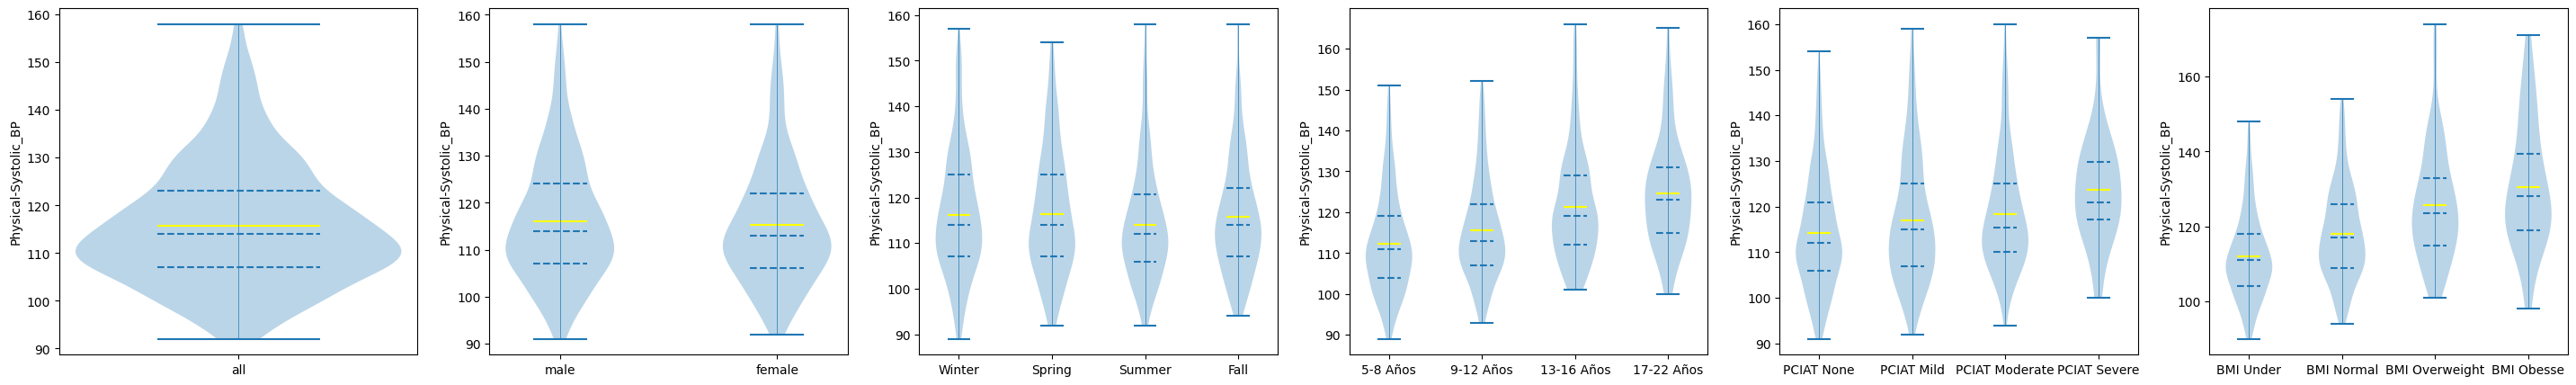

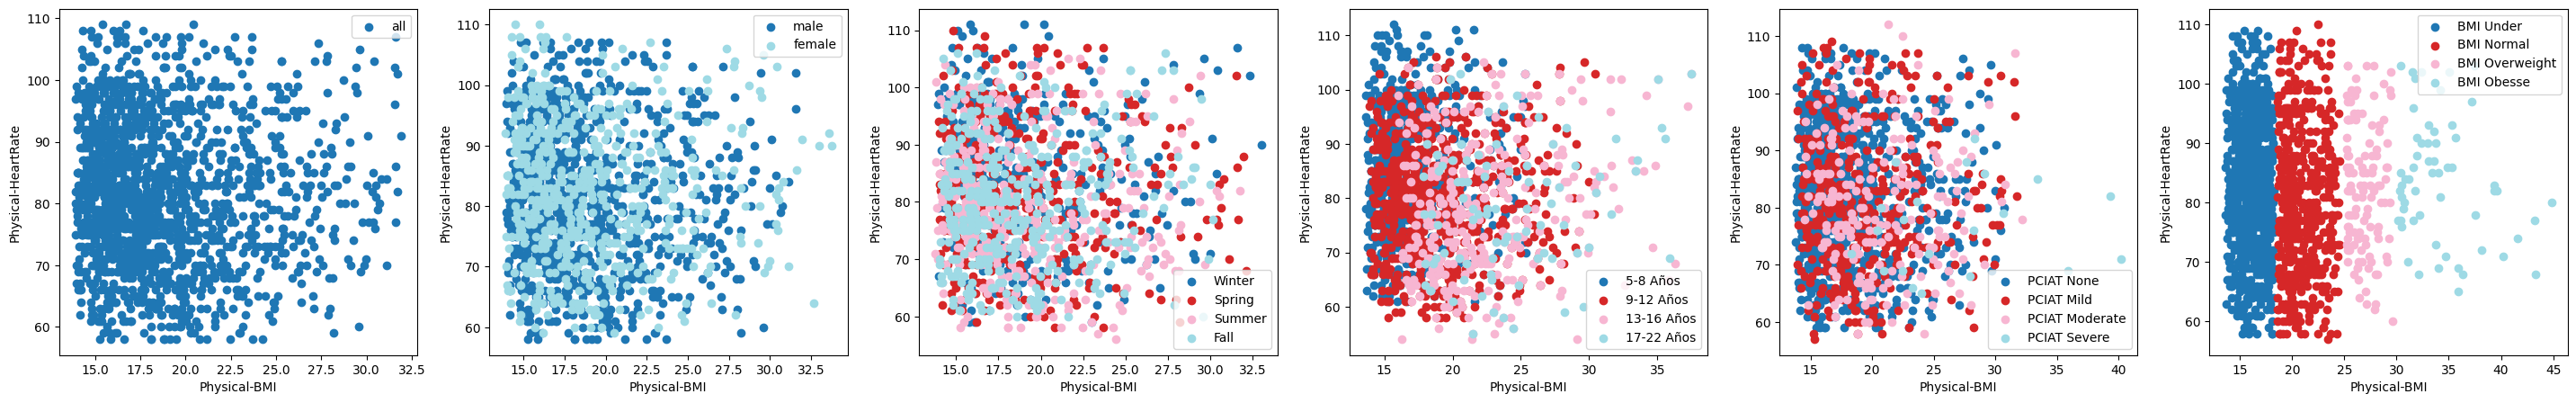

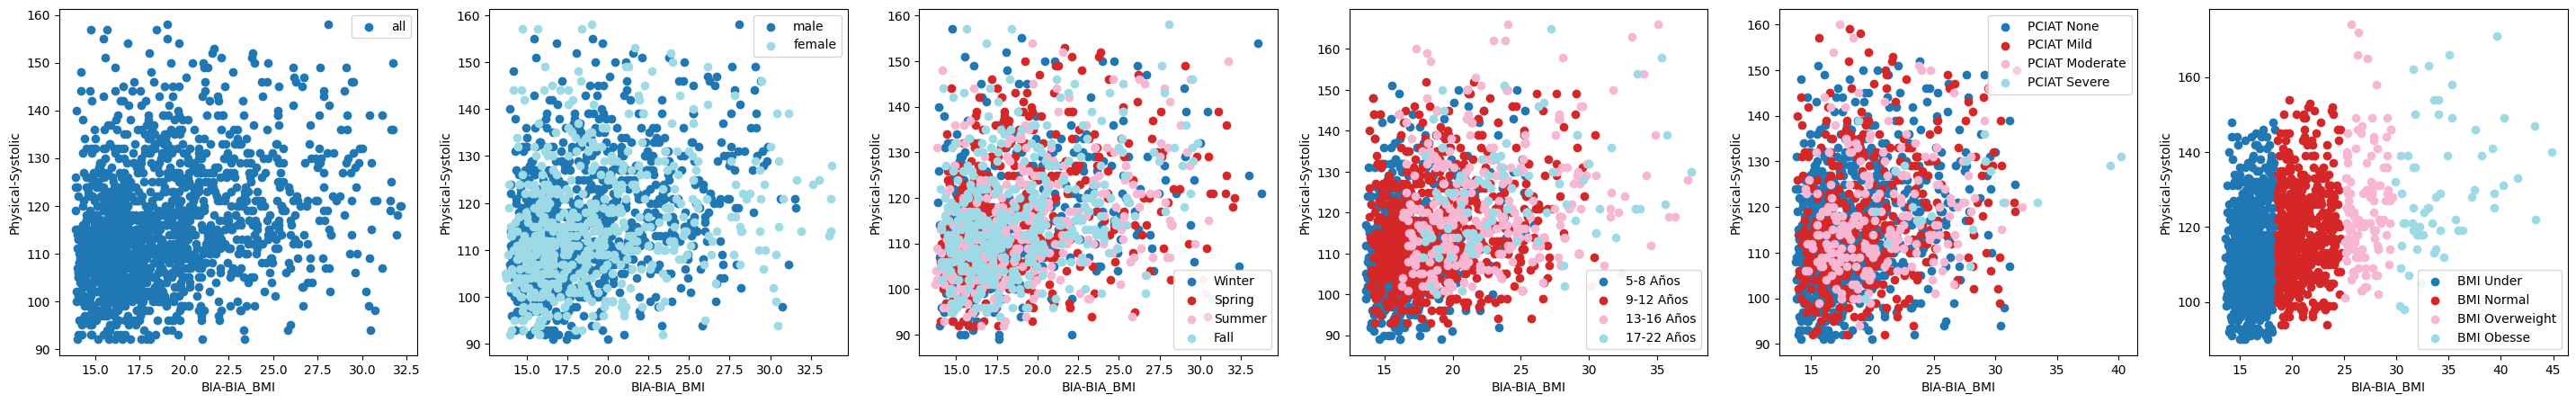

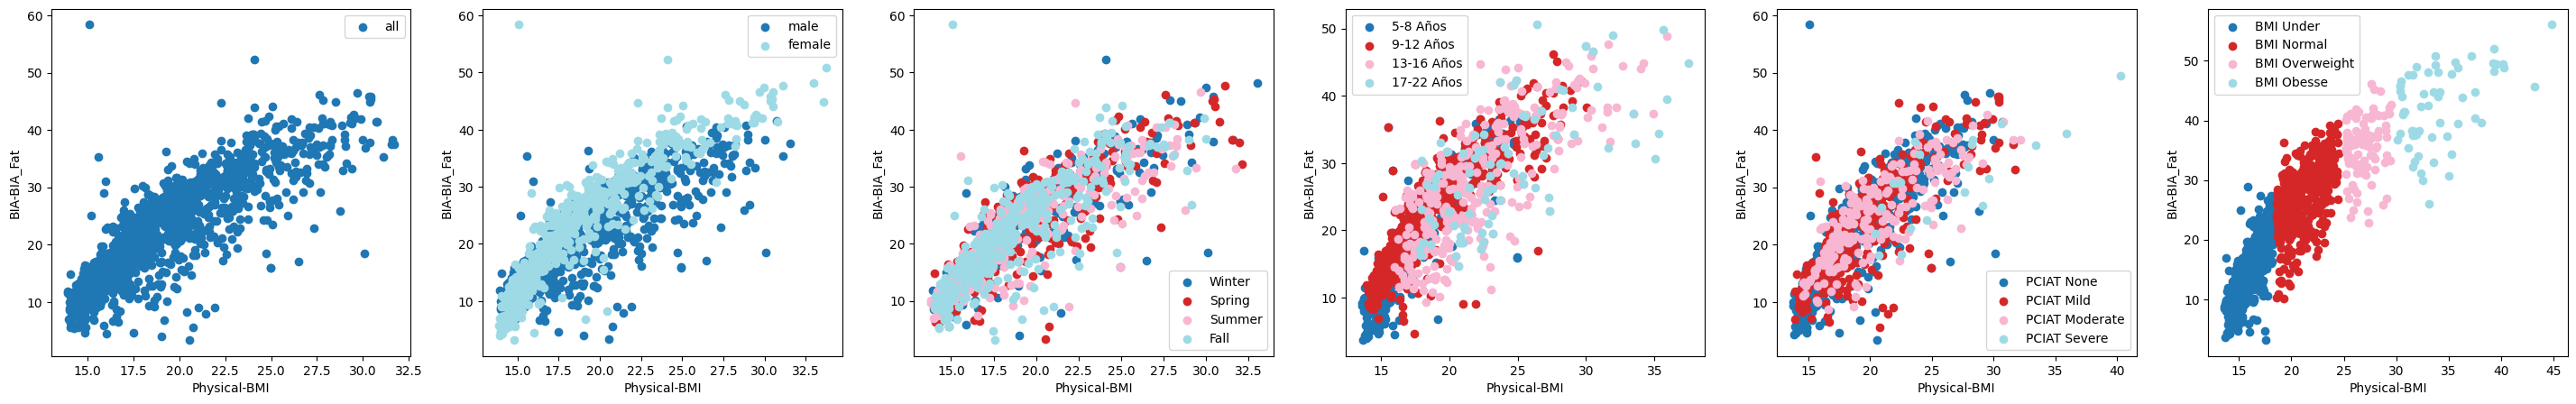

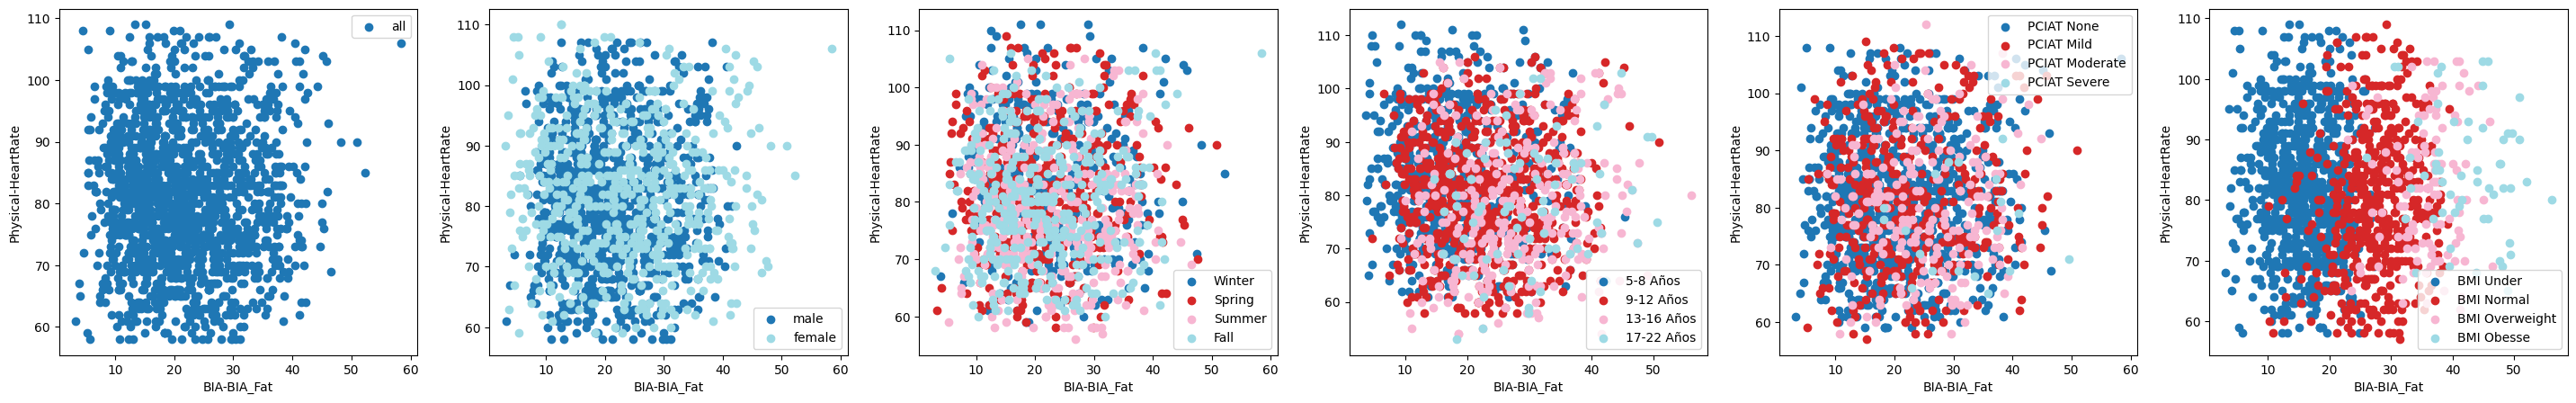

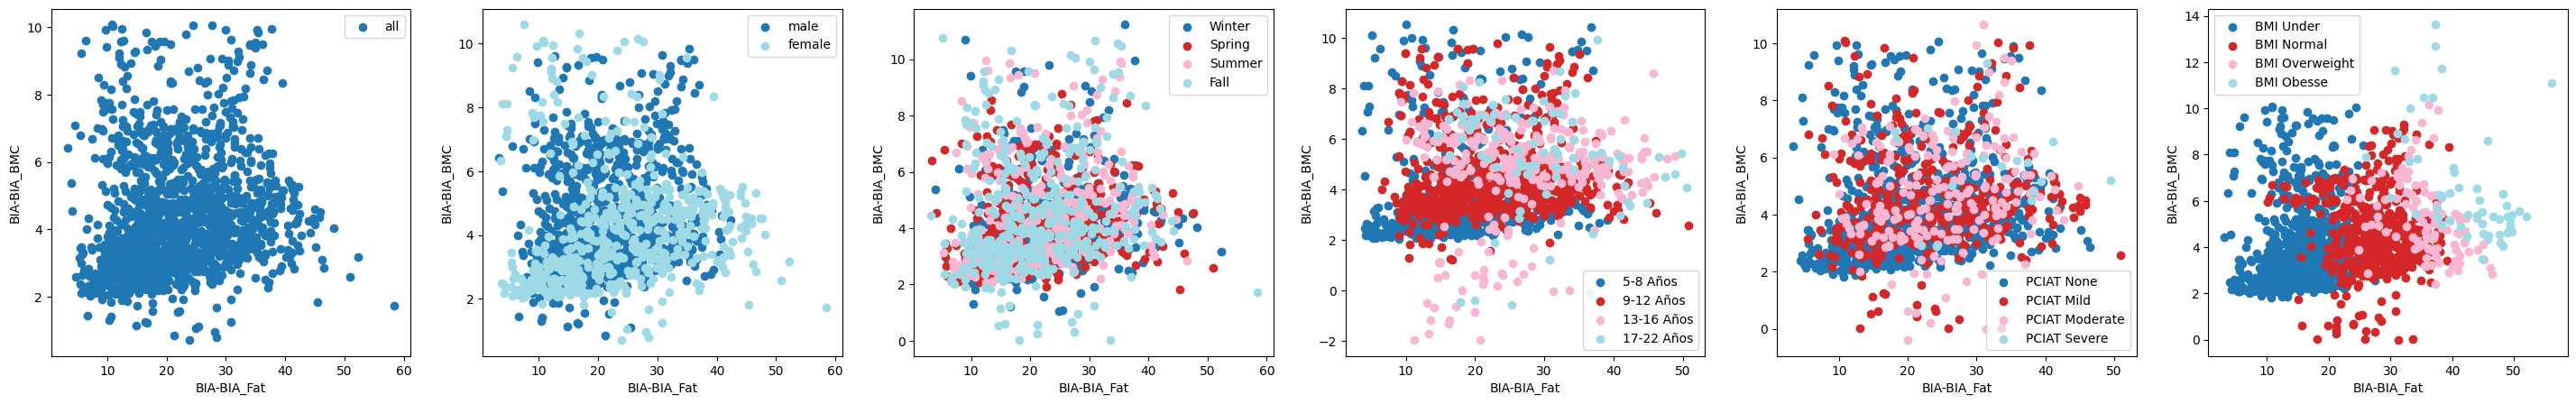

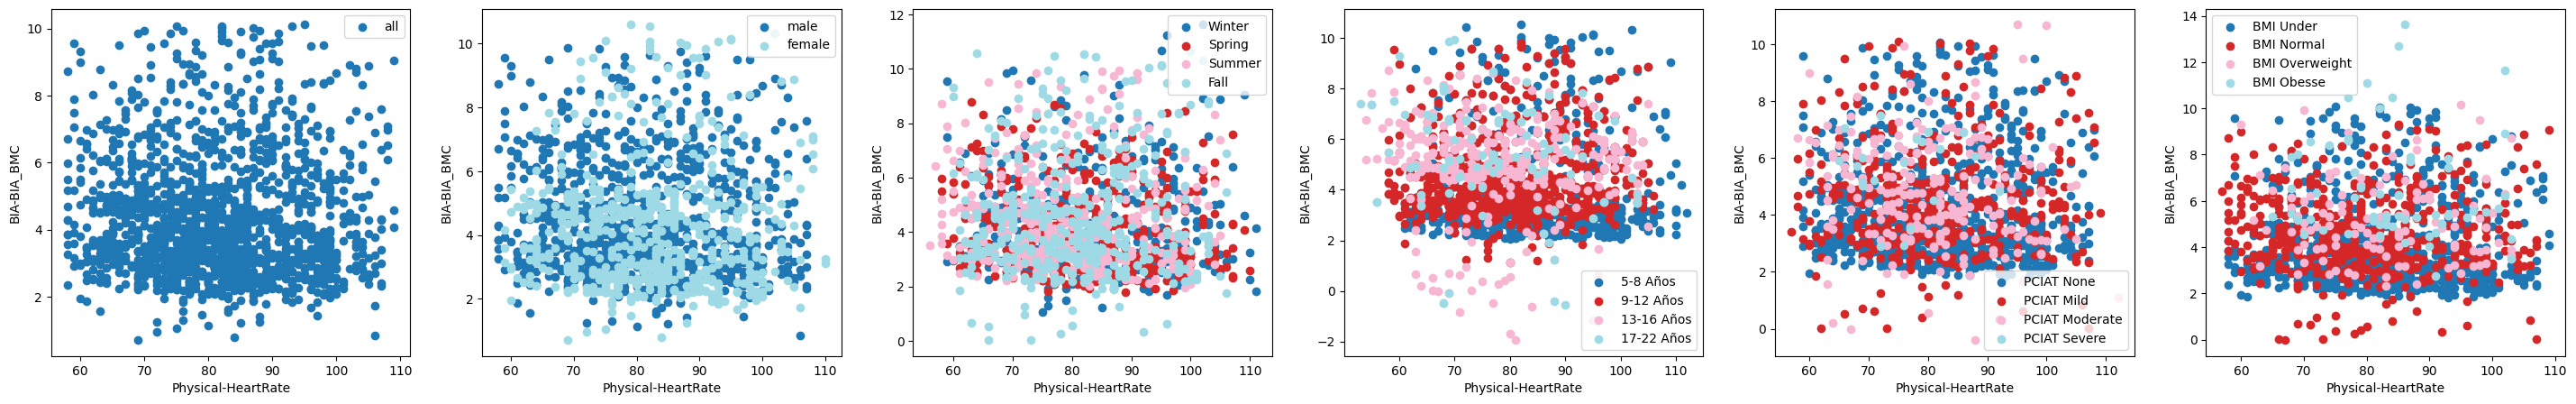

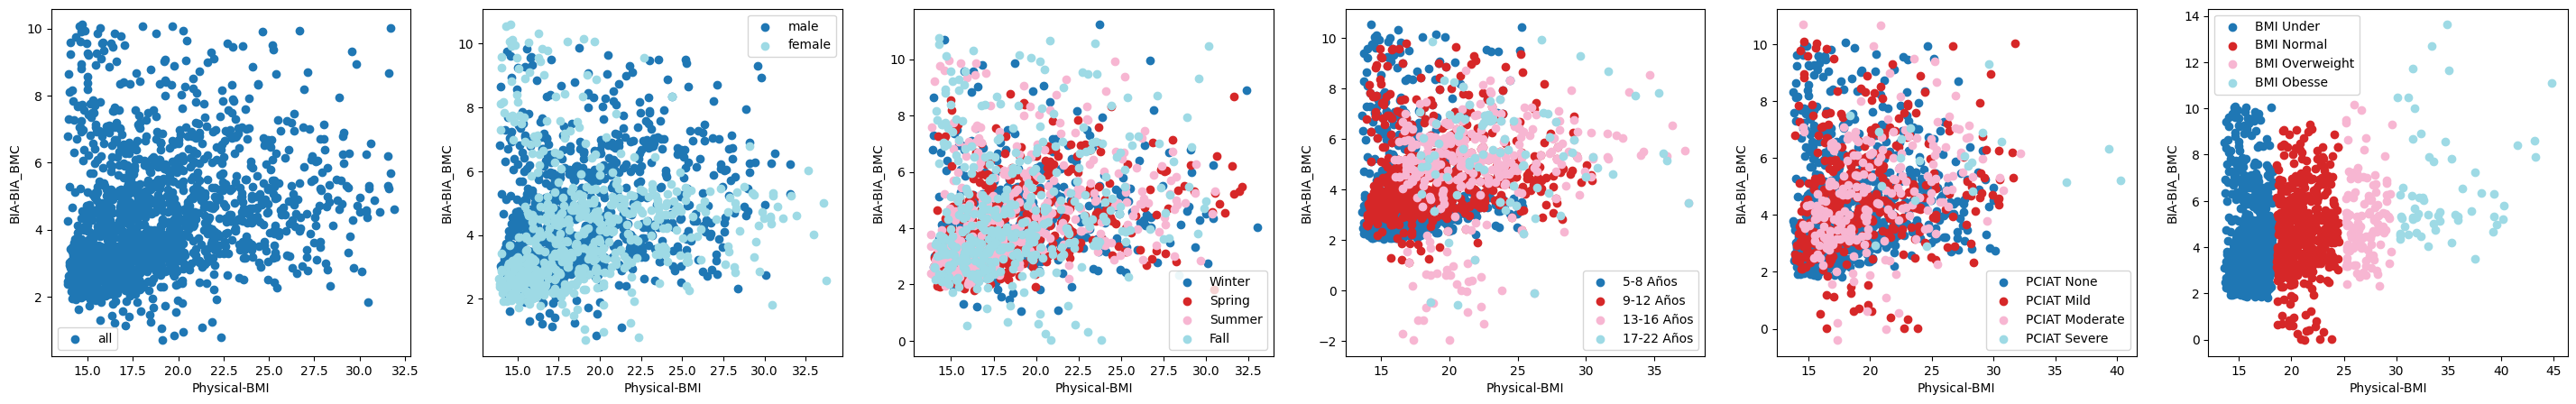

In [70]:
comparative_data: list[dict[str, pd.DataFrame]] = []

# COMPARACIONS 1
data_dict = {"all": data_df}
comparative_data.append(data_dict)

# COMPARACIONS 2
data_dict = {}
data_dict["male"] = data_df[data_df["Basic_Demos-Sex"] == 0]
data_dict["female"] = data_df[data_df["Basic_Demos-Sex"] == 1]
comparative_data.append(data_dict)

# COMPARACIONS 3
data_dict = {}

data_dict["Winter"] = data_df[data_df["Physical-Season"] == "Winter"]
data_dict["Spring"] = data_df[data_df["Physical-Season"] == "Spring"]
data_dict["Summer"] = data_df[data_df["Physical-Season"] == "Summer"]
data_dict["Fall"] = data_df[data_df["Physical-Season"] == "Fall"]
comparative_data.append(data_dict)

# COMPARACIONS 4
data_dict = {}
data_dict["5-8 Años"] = data_df[data_df["Basic_Demos-Age"].between(5, 9)]
data_dict["9-12 Años"] = data_df[data_df["Basic_Demos-Age"].between(9, 13)]
data_dict["13-16 Años"] = data_df[data_df["Basic_Demos-Age"].between(13, 17)]
data_dict["17-22 Años"] = data_df[data_df["Basic_Demos-Age"].between(17, 23)]
comparative_data.append(data_dict)

# COMPARACIONS 5
data_dict = {}
data_dict["PCIAT None"] = data_df[data_df["PCIAT-PCIAT_Total"].between(0, 30)]
data_dict["PCIAT Mild"] = data_df[data_df["PCIAT-PCIAT_Total"].between(31, 49)]
data_dict["PCIAT Moderate"] = data_df[data_df["PCIAT-PCIAT_Total"].between(50, 79)]
data_dict["PCIAT Severe"] = data_df[data_df["PCIAT-PCIAT_Total"].between(80, 100)]
comparative_data.append(data_dict)


# COMPARACIONS 6
data_dict = {}
data_dict["BMI Under"] = data_df[data_df["Physical-BMI"] < 18.4]
data_dict["BMI Normal"] = data_df[data_df["Physical-BMI"].between(18.5, 24.9)]
data_dict["BMI Overweight"] = data_df[data_df["Physical-BMI"].between(25, 29.9)]
data_dict["BMI Obesse"] = data_df[data_df["Physical-BMI"] > 30]
comparative_data.append(data_dict)


for compare_function in compare_functions:
    fig, ax = plt.subplots(1, len(comparative_data), figsize=(len(comparative_data) * 6, 5))
    for i, data_dict in enumerate(comparative_data):
        compare_function(data_dict, ax[i])


En los gráficos de violin:

* Relaciones entre medidas físicas: Como era de esperar, hay una conexión fuerte entre el BMI, el peso y la circunferencia de la cintura. También se nota que la presión sistólica y diastólica van de la mano, algo bastante lógico.

* Cambios según la edad y la temporada: No se ven diferencias brutales entre estaciones, aunque en primavera parece haber más dispersión en los datos. En cuanto a la edad, la resistencia y el fitness mejoran a medida que se crece hasta la adolescencia, luego se estabilizan.

* Tiempo en internet y salud: Aquí hay una relación clara: cuanto más tiempo pasan en internet, más alto suele ser el PCIAT, lo que indica posibles problemas con el uso excesivo. También se nota que quienes pasan más horas conectados tienden a tener un BMI más alto, lo que podría estar relacionado con el sedentarismo.

* Diferencias entre hombres y mujeres: Hay pequeñas variaciones, como en la frecuencia cardiaca o la fuerza de agarre, pero en general, no hay diferencias gigantescas entre sexos.

En los diagramas de dispersión:

Los gráficos muestran la relación entre diferentes variables físicas, como IMC (BMI), grasa corporal (Fat), ritmo cardíaco (HeartRate), presión arterial sistólica (Systolic BP), densidad ósea (BMC), y niveles de PCIAT (que parece medir algún tipo de condición o índice de salud). Además, estas relaciones se analizan según variables como género, edad, estación del año y categoría de IMC.

Tendencias Claves

* Relación entre IMC y grasa corporal

    * Se observa una fuerte correlación positiva: a medida que el IMC aumenta, la grasa corporal también lo hace.
    * Las personas con BMI en la categoría "Obese" presentan los niveles más altos de grasa corporal.
    * En las categorías "Underweight" y "Normal", la grasa corporal varía más, indicando que hay individuos con bajo peso pero con grasa corporal elevada.

* IMC y ritmo cardíaco

    * No hay una relación clara entre estas dos variables, lo que sugiere que el IMC no es un factor determinante del ritmo cardíaco en reposo.
    * La dispersión de los puntos es muy amplia, lo que indica que en todas las categorías de IMC hay una gran variabilidad en la frecuencia cardíaca.

* IMC y presión arterial sistólica

    * Aquí sí hay una relación moderadamente positiva, es decir, a mayor IMC, la presión arterial tiende a ser más alta.
    * En especial, las personas con BMI "Obese" y "Overweight" tienen presiones arteriales más elevadas en comparación con las categorías "Normal" y "Underweight".
    * Esto concuerda con estudios médicos que vinculan sobrepeso y obesidad con hipertensión.

* IMC y Densidad Ósea (BMC)

    * Se observa una tendencia positiva: a medida que el IMC aumenta, la masa ósea también.
    * Esto tiene sentido, ya que las personas con más masa corporal suelen tener huesos más densos y pesados debido a la carga adicional sobre su estructura ósea.
    
* Ritmo cardíaco y grasa corporal

    * No parece haber una relación clara. La dispersión de los puntos sugiere que los niveles de grasa corporal no afectan directamente la frecuencia cardíaca en reposo.
    * Sin embargo, los individuos con grasa corporal más baja tienden a tener una frecuencia cardíaca más estable, mientras que los valores más altos de grasa muestran más variabilidad en la frecuencia.

* PCIAT y diferentes variables

    * Parece haber una relación con IMC y grasa corporal, donde individuos con valores más altos de PCIAT también tienden a tener mayor grasa y BMI.
    * Esto puede indicar que PCIAT mide alguna condición de salud que se agrava con la obesidad.
    * En contraste, los individuos con PCIAT bajo tienden a tener menor IMC y menos grasa corporal.

Conclusiones más relevantes

* IMC y grasa corporal están fuertemente correlacionados, lo que indica que personas con mayor peso corporal también tienen más porcentaje de grasa.
* El IMC y la presión arterial tienen una relación moderada, lo que sugiere que un mayor peso puede estar vinculado a hipertensión.
* No hay una relación clara entre el IMC y el ritmo cardíaco, lo que indica que otros factores pueden influir más en la frecuencia cardíaca en reposo.
* Las personas con mayor IMC tienden a tener una mayor densidad ósea, lo que sugiere que la masa corporal influye en la estructura ósea.
* PCIAT parece estar relacionado con el IMC y la grasa corporal, lo que podría indicar que mide algún índice de salud o condición que se ve afectada por el sobrepeso y la obesidad.